In [1]:
# Used hp_opt env
# Import Libraries
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt, seaborn as sns, keras_tuner as kt, tensorflow as tf
import os, datetime, progressbar, sys
import tensorflow_probability as tfp

# import method
sys.path.insert(1, '/Users/tashaleebillings/Desktop/Tasha_Desktop/ThesisResearch/ML/scripts/')
import not_sure_what_to_call_this as script

tfd = tfp.distributions

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical, plot_model
from keras.callbacks import ModelCheckpoint#, TensorBoard                                                                      
from keras import backend as K
from livelossplot import PlotLossesKeras

from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hypermodel import HyperModel
from keras_tuner.engine.hyperparameters import HyperParameters
#from tensorboard.plugins.hparams import api as hp                                                                             
#from keras.utils.generic_utils import get_custom_objects                                                                      

import gc
gc.enable()

hp = HyperParameters()
plotlosses = PlotLossesKeras()

In [2]:
pwd

'/Users/tashaleebillings/Desktop/Tasha_Desktop/ThesisResearch/ML/notebooks'

In [3]:
# load data
toy_model = np.load('toy_models_32x32.npz')
nx, ny, ntrain = toy_model['training_data'].shape
training_data = toy_model['training_data'].T
labels = toy_model['labels']

outputdir = "./"
idx = "32"
project_name='toy_model_tuner_{}'.format(idx)
HP_EPOCH = 30
HP_BATCH_SIZE = 5
factor = 100
num_models = 25

Load toy model. The image pixel sizes are small. Only 32x32 so that I can get quick results.

In [4]:
# Normalizing the data
X_train = training_data[0:8000,:,:].reshape(8000,nx,ny,1)
y_train = labels[0:8000]*factor
X_test = training_data[8000:,:,:].reshape(2000,nx,ny,1)
y_test = labels[8000:]*factor

print("training", X_train.shape)
print("validation", X_test.shape)

# load divegence normalization function
kl_divergence_function = script.kl_divergence_normalization_term(TRAINING_DATA=training_data)

training (8000, 32, 32, 1)
validation (2000, 32, 32, 1)


In [5]:
# make custom functions callable with keras
keras.utils.get_custom_objects().update({'Mean_Squared_over_true_Error':script.custom_loss.Mean_Squared_over_true_Error,
                                         'neg_log_likelihood': script.custom_loss.neg_log_likelihood, 
                                         'kl_divergence':script.custom_loss.kl_divergence,
                                         'elbo':script.custom_loss.elbo})


Selected a single image in the training dataset. The ionized pixels are labels 0 and all other pixels have non-zero values.

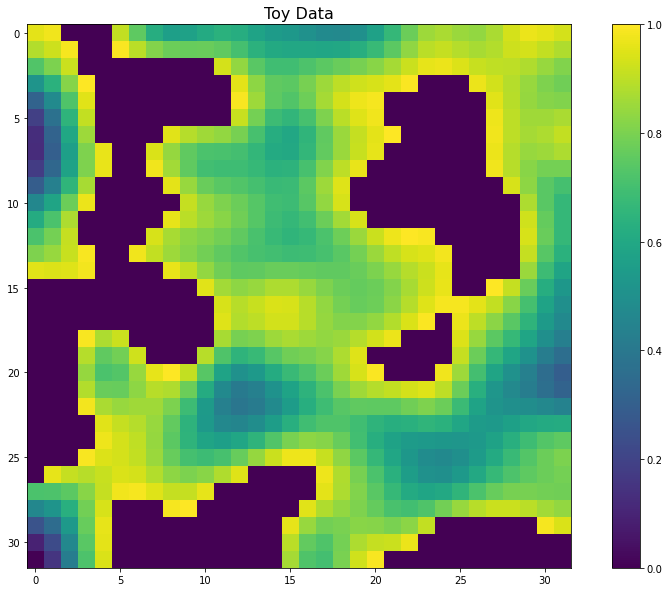

In [6]:
plt.figure(figsize=(15, 10))
plt.imshow(X_train[0,:,:,0])
plt.title("Toy Data",size = 16 )
plt.colorbar()
#plt.legend()

Looking at the distribution of the labeled pixel values. It should be uniform because we want to sample the space evenly. 

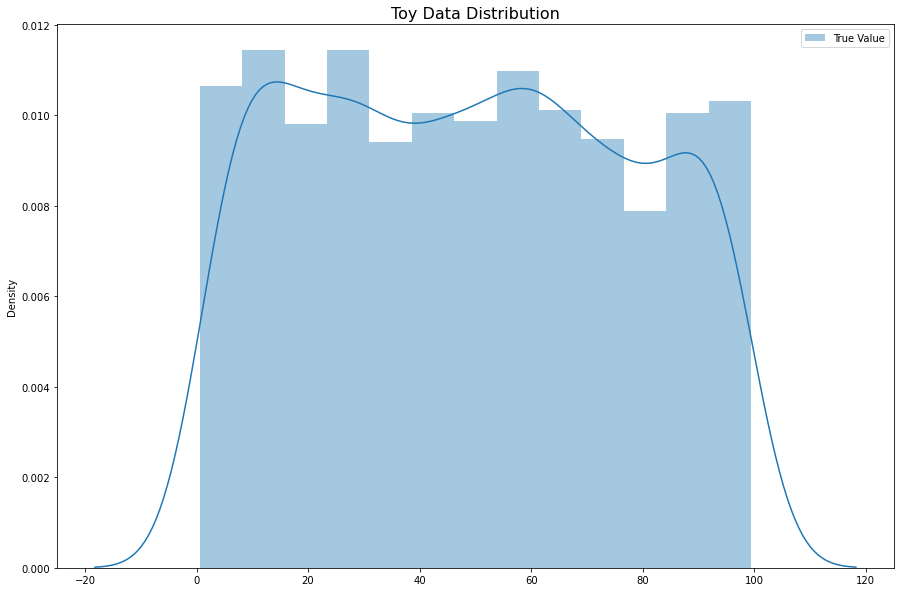

In [7]:
plt.figure(figsize=(15, 10))
sns.distplot(y_test,label="True Value")
plt.title("Toy Data Distribution",size = 16 )
#plt.xlim([0, 1.25])
plt.legend()

# Model 1

## Train Model Using Deterministic Loss Function

Build a simple probiblistic model and train it using deterministic loss functins to see which ne performs well. It's clear from the one-to-one plots that the all of the the loss types except for **loss_type: Mean_Squared_over_true_Error** work well forr this model. In general **mse** performs the best with other CNN architectures (not demonstrated in this notebook). The cool things is that for this particular dataset size (32x32) we acheive good results with few training steps (only 5).  

I used kera-tuner to randomly search the turning space. Unfortunately it seems a s though I cannot trust which model says is the best model because although in most cases the model with the lowest validation loss is the best model... that's not true here. The best model doesn't have the smallest validation loss. So this isn't a good way of finding the best model... But it is an easy way to train multiple models... So yeah that's why I'm using it.

In [8]:

if os.path.isdir(project_name): # check to see if path exists
    os.system("rm -rvf {}".format(project_name))

def train_test_og_model(hp):
    # Making a model.                                                                                                                                                                       
    model = Sequential()
    
    model.add(tfp.layers.Convolution2DFlipout(filters = 16, 
                                              input_shape=(nx, ny, 1), kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu'
                                              #, padding = 'same'
                                             ))
    model.add(tfp.layers.Convolution2DFlipout(filters = 8, 
                                              kernel_size=3, activation = 'relu', 
                                              kernel_divergence_fn=kl_divergence_function,
                                              #padding = 'same'
                                             ))
    model.add(Flatten())
    model.add(tfp.layers.DenseFlipout(1, activation="linear", kernel_divergence_fn=kl_divergence_function,))
    
    #for l in range(hp.Int('loss', 0, len(losses))):
    model.compile(optimizer= "adam", loss = hp.Choice('loss_type', ["mse", "mae", "mape", "Mean_Squared_over_true_Error"], ordered=False, default="mse"), metrics=["mse"])
    
    # Visualize Model                                                                                                                                                                      
    print(model.summary())
    
    return model#, history
    
    

In [9]:
# Random searrch through choices
tuner_models = script.random_search(model= train_test_og_model,
                                    num_models= num_models,
                                    outputdir= outputdir,
                                    project_name= project_name,
                                    X_train= X_train, 
                                    y_train= y_train,
                                    X_test= X_test, 
                                    y_test= y_test,
                                    epochs= HP_EPOCH,
                                    HP_BATCH_SIZE=HP_BATCH_SIZE,
                                   )


Trial 4 Complete [00h 06m 16s]
val_loss: 1.6111491918563843

Best val_loss So Far: 0.05612518638372421
Total elapsed time: 00h 24m 27s
INFO:tensorflow:Oracle triggered exit
--------------------------------------------------
Tuning Summary
--------------------------------------------------
Results summary
Results in ./toy_model_tuner_32
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
loss_type: Mean_Squared_over_true_Error
Score: 0.05612518638372421
Trial summary
Hyperparameters:
loss_type: mae
Score: 1.6111491918563843
Trial summary
Hyperparameters:
loss_type: mse
Score: 1.8561763763427734
Trial summary
Hyperparameters:
loss_type: mape
Score: 3.352632999420166
Search space summary
Default search space size: 1
loss_type (Choice)
{'default': 'mse', 'conditions': [], 'values': ['mse', 'mae', 'mape', 'Mean_Squared_over_true_Error'], 'ordered': False}
Model: "sequential"
_________________________________________________________________
Layer

In [10]:
# print best performing model's loss function
tuner_models[0].loss

'Mean_Squared_over_true_Error'

In [11]:
# returns a list of model
tuner_models

In [12]:
# List of losses: the quantity that a model should seek to minimize during training.
tuner_models[0].losses

[<tf.Tensor 'conv2d_flipout/divergence_kernel:0' shape=() dtype=float32>,
 <tf.Tensor 'conv2d_flipout_1/divergence_kernel:0' shape=() dtype=float32>,
 <tf.Tensor 'dense_flipout/divergence_kernel:0' shape=() dtype=float32>]

### Monte Carlo 

Use Monte Carlo sampling of the models and average the predicted predictions to get the predicted values and make one-to-one plot. In the plot below I compare the models and then from there it's clear who doesn't do well at all (blue line). Obvisouly, if I trained the model for a longer time then I would expect it to improve the other predictions but this is good enough. 

In [13]:
# make list of predictions using the best model
pred = script.mc_pred(bestmodel=tuner_models[-1], X_test=X_test)

In [14]:
# make list of predictions using all of the model
predictions = script.mc_pred_tuner_models(tuner_models=tuner_models, X_test=X_test)

(2000, 32, 32, 1)
(5, 2000)


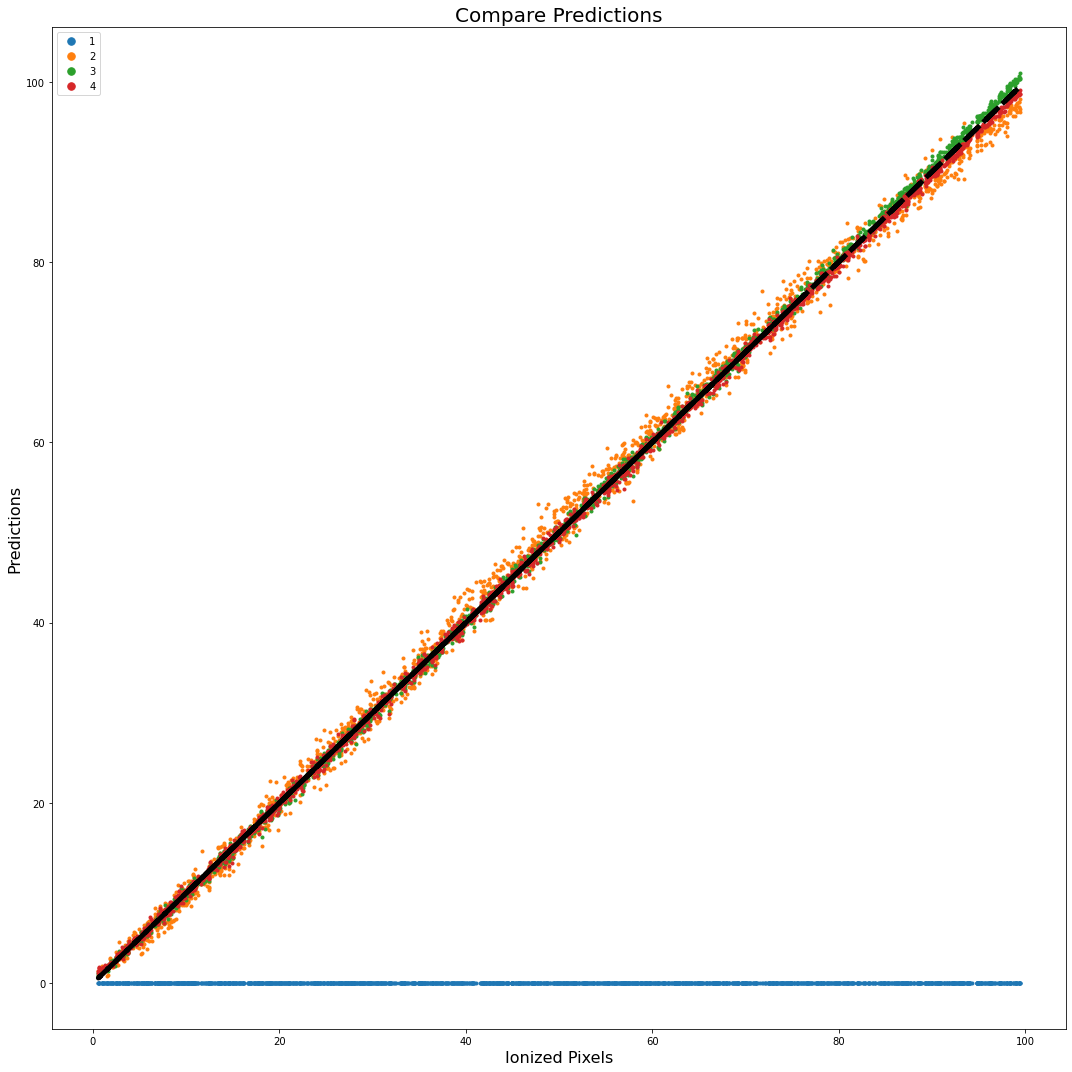

In [15]:
script.plot_one_to_one_pred(tuner_models= tuner_models, y_test= y_test, predictions=predictions)

In the plot below I look at a subset of predicted ionized pixel values. I would have selected any range but I chose 0-2. Well, the good thing is that it looks like the model doesn't try to guess values less than 0... That would make no sense. We do see multiple peaks. More than two peaks is no longer a bimodal distribution. It's a Multimidal distribution and would also represent multiple local maximums; these are points where the data points stop increasing and start decreasing.  

https://www.statisticshowto.com/what-is-a-bimodal-distribution/

No handles with labels found to put in legend.


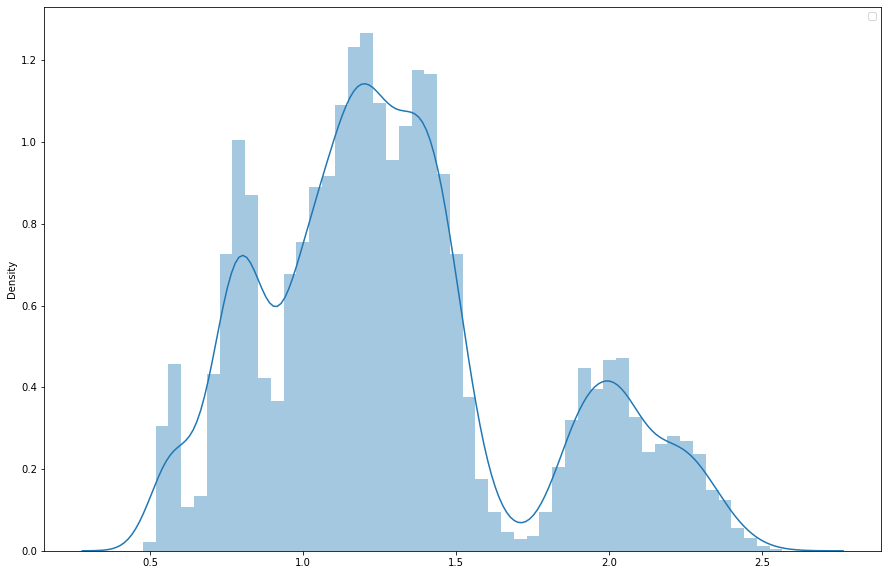

In [37]:
script.plot_pred_distribution_range(predictions=pred, y_test=y_test, upper_lim=2, lower_lim=0)

Ideally we would want this distribution to be centred at zero because we are looking at the distribution of the difference between the pred and the true value. There is clearly some presence of divergence the distribution. I can't see much skewed behavior but I do see the presenece of kurtosis (positive and negative).  Some of thee distributions have pretty fat tails too.

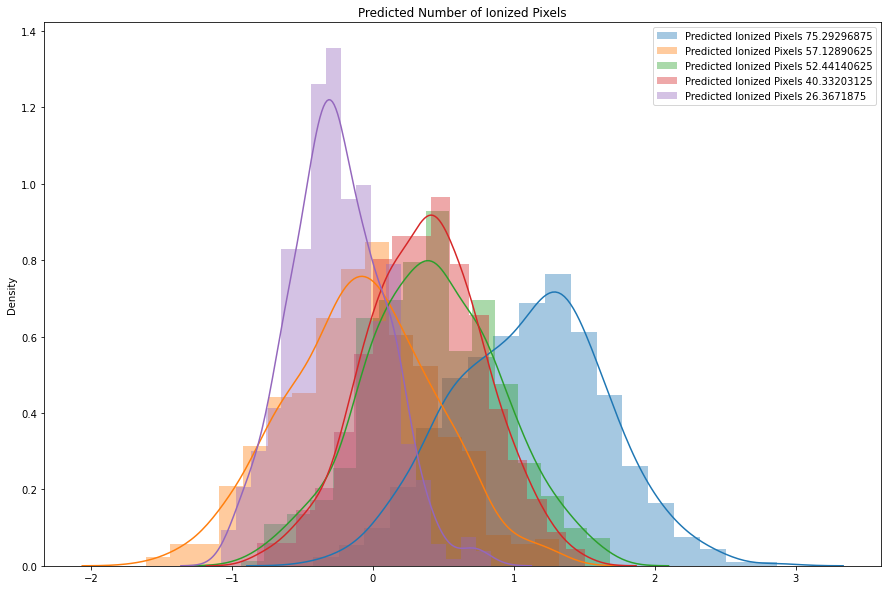

In [17]:
script.plot_pred_distribution(predictions= pred, y_test= y_test)

### Empirical Examination of Posterior Distribution

Looks like the std of the weights areen't negative... Good. There are very clear double peaks (bimodal distirbution?).  

Weight distribution says something interesting I think. Going from the 1st convolution layer to the second more weights are zero. So, they aren't important when looking at this data.

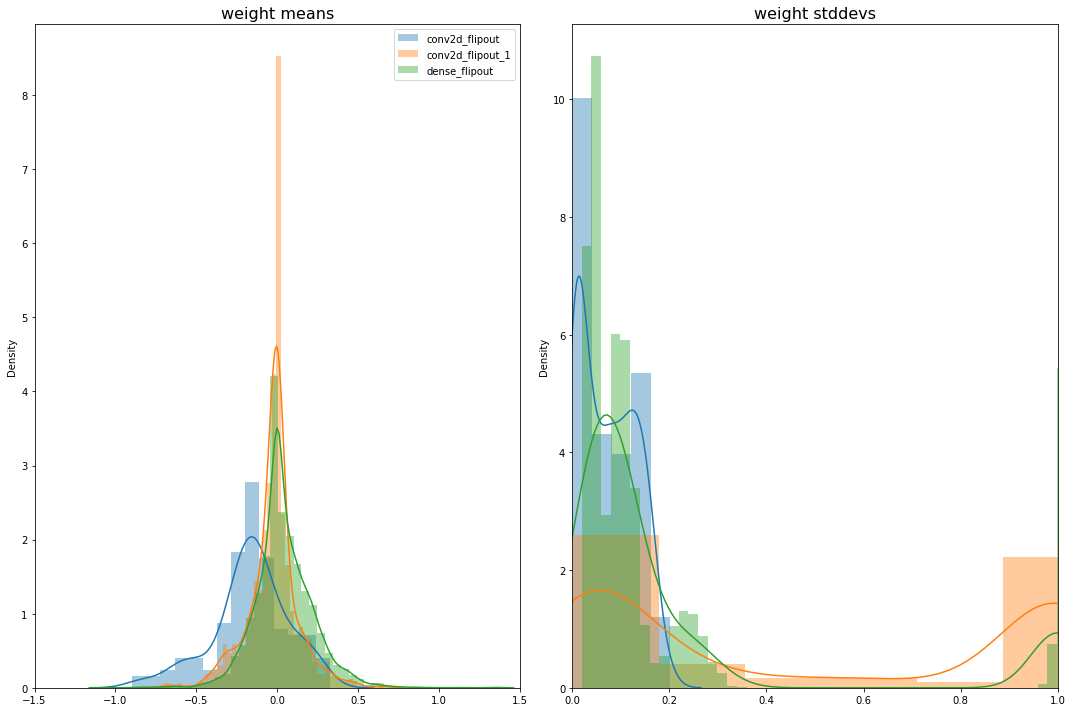

In [18]:
script.plot_qm_qs_vals(bnn_model= tuner_models[-1])

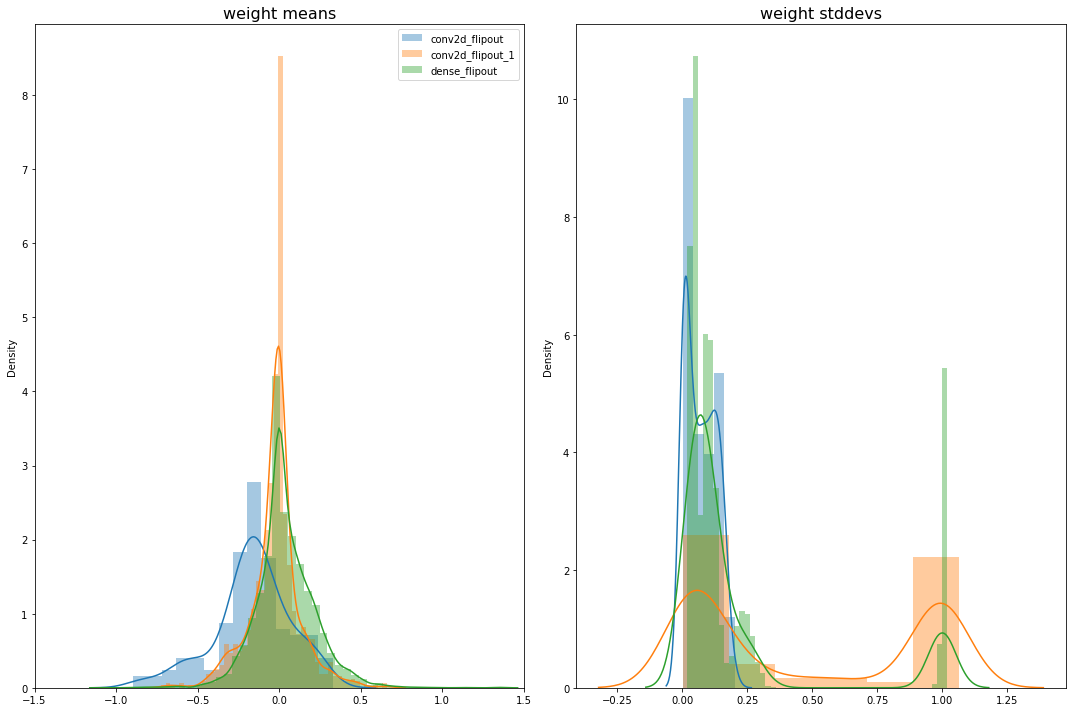

In [40]:
def plot_qm_qs_vals(bnn_model=tuner_models[-1]):
    
    names = [layer.name for layer in bnn_model.layers if "flipout" in layer.name]
    
    qm_vals = [
        layer.kernel_posterior.mean()
        for layer in bnn_model.layers
        if "flipout" in layer.name
    ]
    qs_vals = [
        layer.kernel_posterior.stddev()
        for layer in bnn_model.layers
        if "flipout" in layer.name
    ]


    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(1, 2, 1)
    for n, qm in zip(names, qm_vals):
        sns.distplot(tf.reshape(qm, shape=[-1]), ax=ax, label=n)
    ax.set_title("weight means",size = 16 )
    ax.set_xlim([-1.5, 1.5])
    ax.legend()
    ax = fig.add_subplot(1, 2, 2)
    for n, qs in zip(names, qs_vals):
        sns.distplot(tf.reshape(qs, shape=[-1]), ax=ax)
    ax.set_title("weight stddevs", size = 16)
    #ax.set_xlim([0, 1.0])
    fig.tight_layout()
    plt.show()
    
plot_qm_qs_vals(bnn_model=tuner_models[-1])

## Train Model Using Probabilistic Loss Function

This is the same architecture as above but instead train the model using a non-deterministic loss function and train it 6 times as long. This does extremely well as you can see in the one-to-one. I shuold try this with "elbo" loss function too. You can also compare the performance of the twoo models because they have a common metric "mse". In the model above "Score: 1.8561763763427734". In this model the "Score: 1.650"

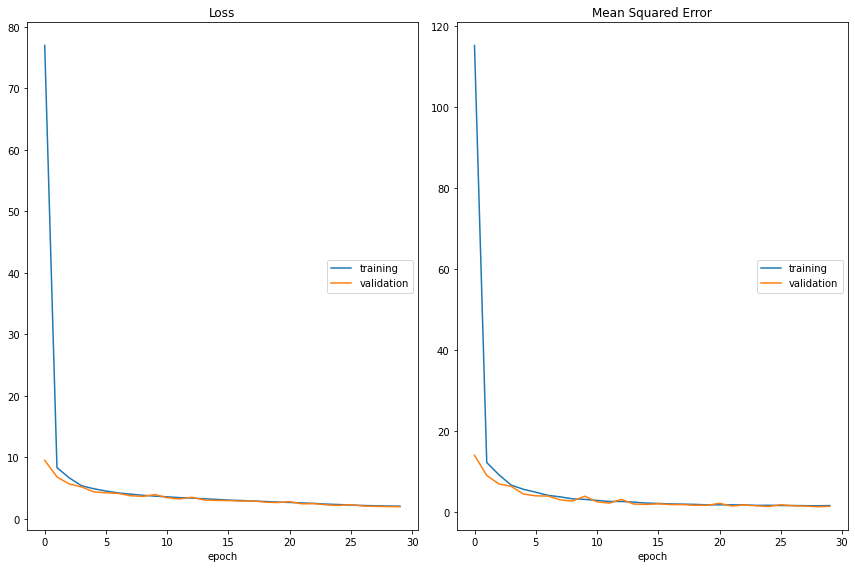

Loss
	training         	 (min:    2.089, max:   76.960, cur:    2.089)
	validation       	 (min:    1.994, max:    9.541, cur:    1.994)
Mean Squared Error
	training         	 (min:    1.598, max:  115.147, cur:    1.650)
	validation       	 (min:    1.364, max:   14.083, cur:    1.460)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout_2 (Conv2DFlip (None, 30, 30, 16)        304       
_________________________________________________________________
conv2d_flipout_3 (Conv2DFlip (None, 28, 28, 8)         2312      
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_flipout_1 (DenseFlipou (None, 1)                 12545     
_________________________________________________________________
distribution_lambda (Distrib m

In [19]:
def train_test_og_model():
    # Making a model.                                                                                                                                                                       
    model = Sequential()
    
    model.add(tfp.layers.Convolution2DFlipout(filters = 16, 
                                              input_shape=(nx, ny, 1), kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu'
                                              #, padding = 'same'
                                             ))
    model.add(tfp.layers.Convolution2DFlipout(filters = 8, 
                                              kernel_size=3, activation = 'relu', 
                                              kernel_divergence_fn=kl_divergence_function,
                                              #padding = 'same'
                                             ))
    model.add(Flatten())
    model.add(tfp.layers.DenseFlipout(1, activation="linear", kernel_divergence_fn=kl_divergence_function,))
    model.add(tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           #scale = 1)))
                           scale=1e-3 + tf.math.softplus(0.01 * t[..., :1]))))
    

    model.compile(optimizer= "adam", loss = "neg_log_likelihood", metrics=["mse"])
    
    plotlosses = PlotLossesKeras()

    model.fit(X_train, y_train, validation_data=(X_test, y_test),
            epochs=HP_EPOCH, batch_size=HP_BATCH_SIZE,
            callbacks=[plotlosses],
            verbose=1)
    
    # Visualize Model                                                                                                                                                                      
    print(model.summary())

    loss = model.evaluate(X_test, y_test)
    return model
                                                                                                                                                                                      
model = train_test_og_model()



### Monte Carlo 

In [20]:
# make predictions  
pred_distLambda = script.mc_pred(bestmodel=model, X_test=X_test)

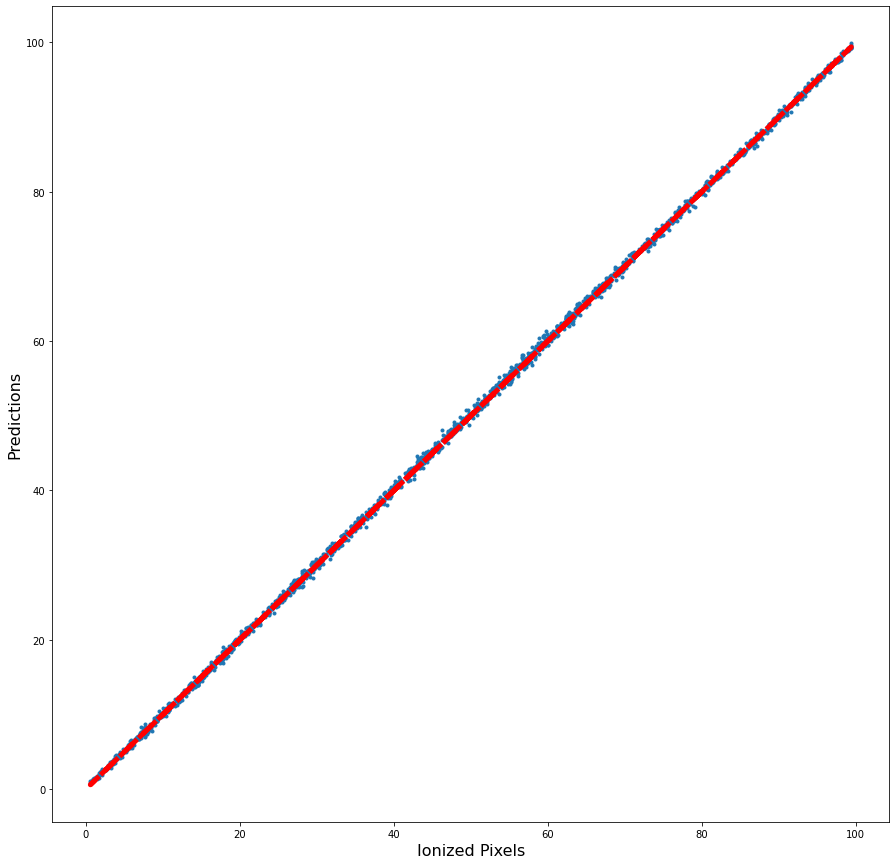

In [21]:
# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("")
plt.xlabel("Ionized Pixels", size = 16)
plt.ylabel("Predictions", size = 16)
plt.plot(y_test, np.mean(np.array(pred_distLambda), axis=0), '.')
plt.plot(y_test,y_test, "r--", linewidth=5)

These distibutions have fat tails too but they are closer to being centered at zero.

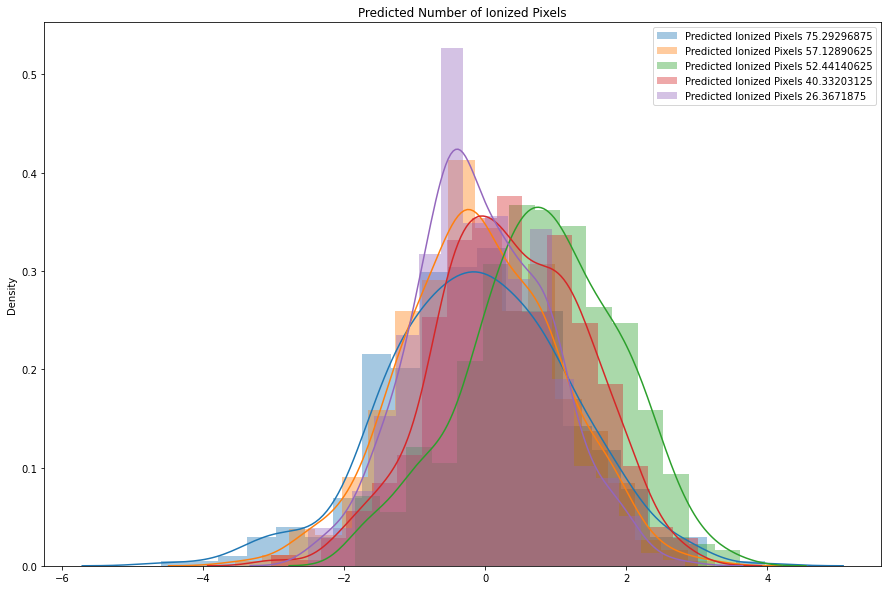

In [22]:
script.plot_pred_distribution(predictions= pred_distLambda, y_test= y_test)

### Plot the distribution of the predictions within a certain range.

No handles with labels found to put in legend.


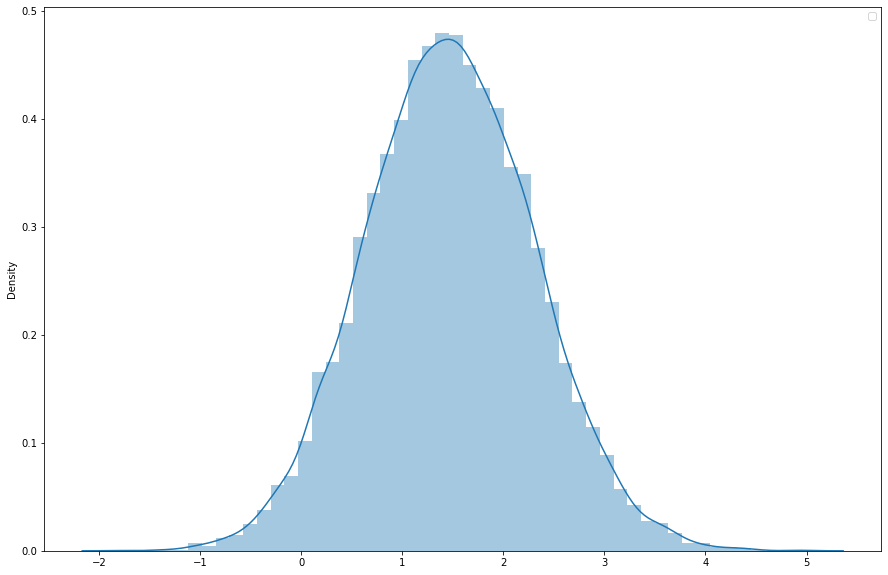

In [23]:
script.plot_pred_distribution_range(predictions=pred_distLambda, y_test=y_test, upper_lim=2, lower_lim=0)

No handles with labels found to put in legend.


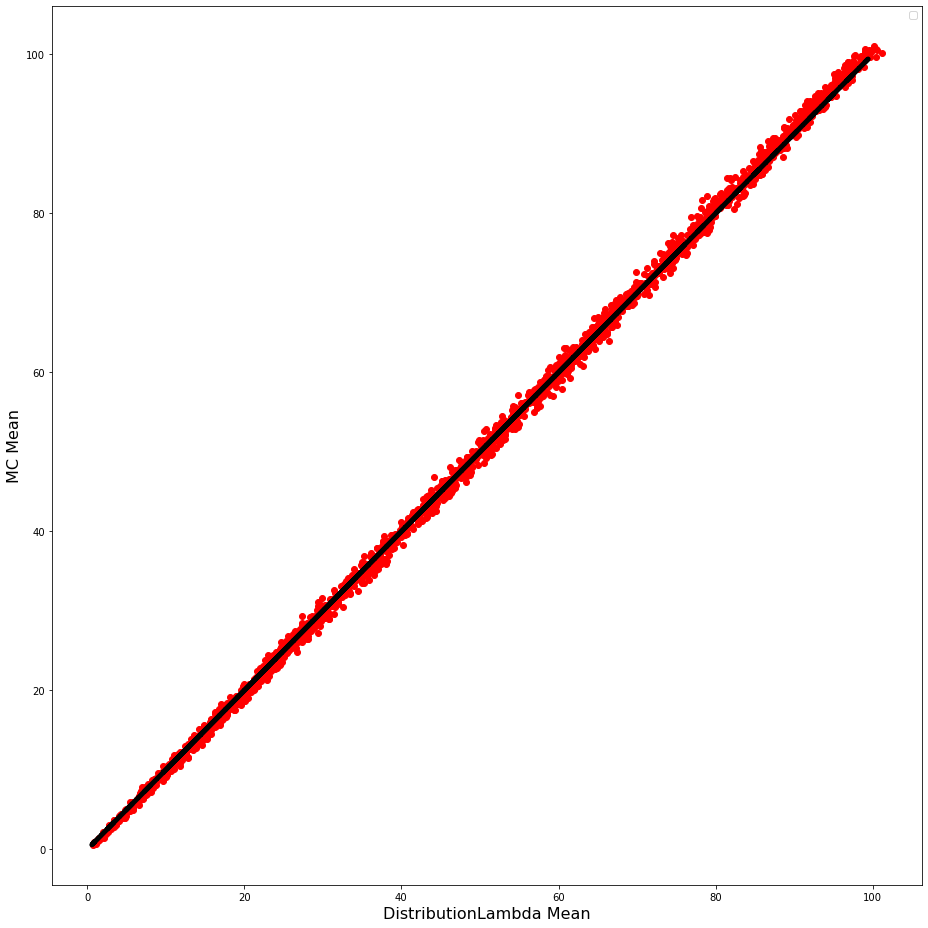

In [25]:
script.plot_compare_pred_values(yhat=model(X_test), predictions= pred, y_test= y_test)

... Very unclear what this shape means... I keep seeing it... idk...

No handles with labels found to put in legend.


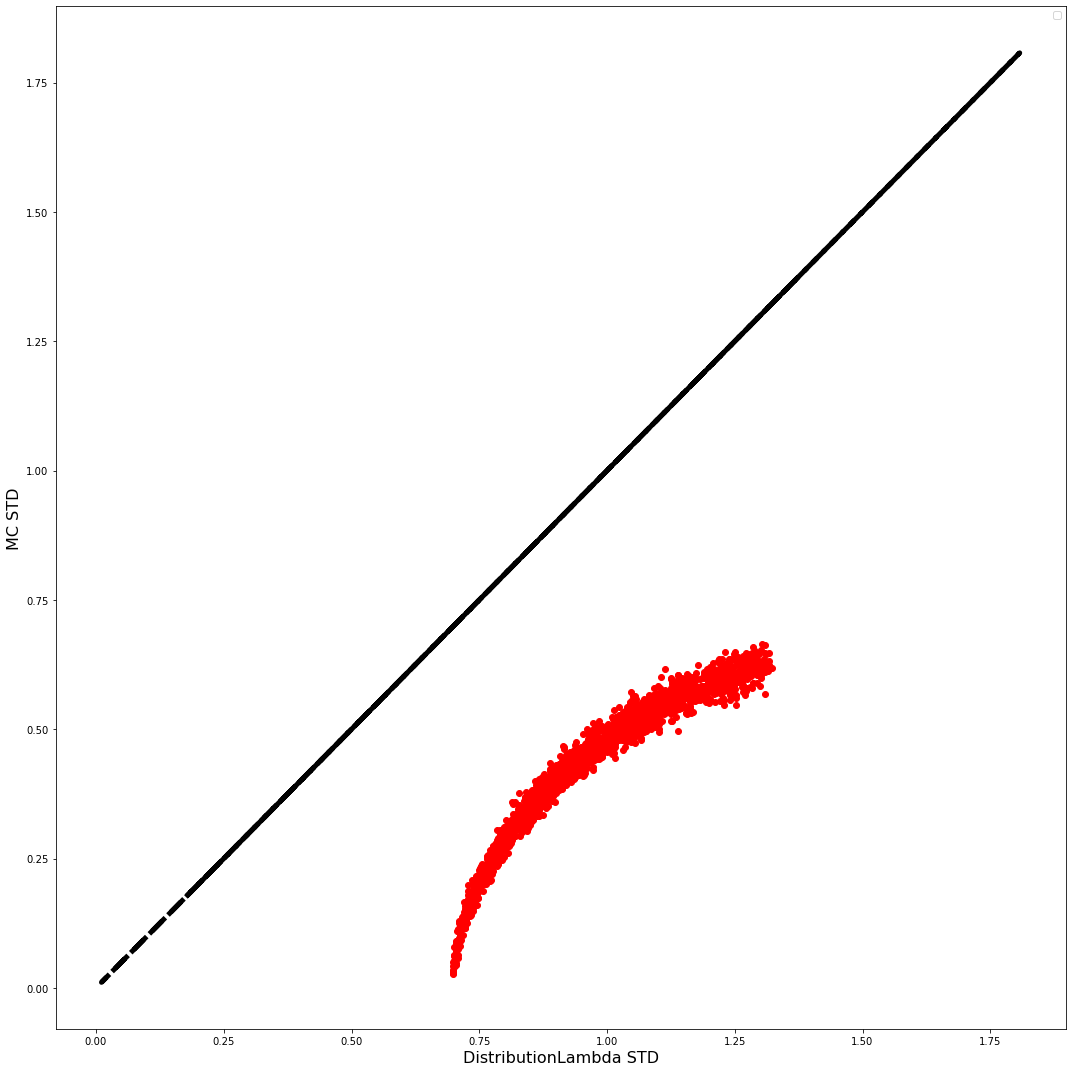

In [26]:
script.plot_compare_STDs(yhat=model(X_test), predictions= pred, y_test= y_test)

### Empirical Examination of Posterior Distribution

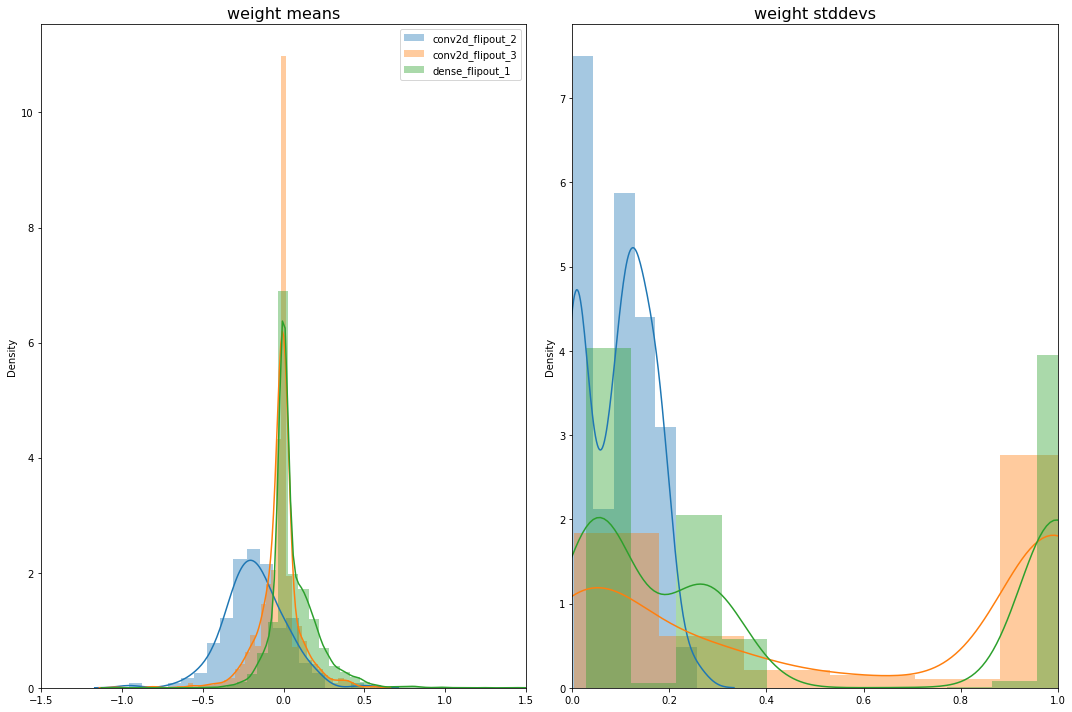

In [31]:
script.plot_qm_qs_vals(bnn_model= model)

## Learn STD and Mean

### Error Bars

METHOD 1:  Empirical error bars for the posterior using Monte Carlo  

METHOD 2: Sigma in output layer  

In [24]:
yhat = model(X_test) # model.predict(X_test)

MC predictions do really well here but what happens when we sample from the Lambda_distribution function?

Compare two prediction methods. MC sampling and Disttribution lambda are about the same so this is really good. MC can take a very long time so I guess this means in this case I don't need to use the MC sampling of the model.

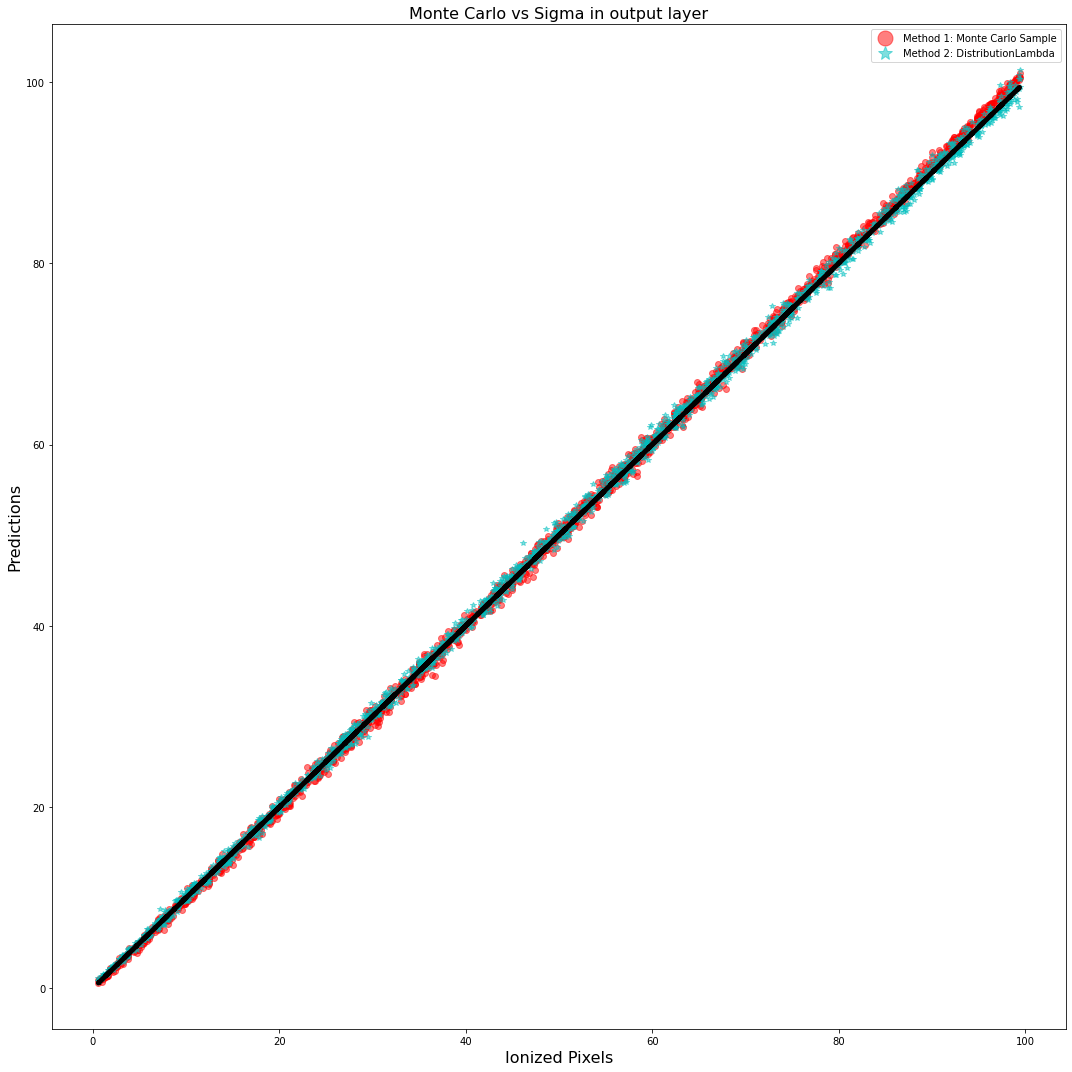

In [27]:
script.plot_one_to_one_pred_MC_DistributionLambda(yhat=model(X_test), predictions= pred, y_test= y_test)

We see some divergence as the number of ionized pixels increases. This is probably because I'm plotting the absolute error instead of the relative error. That could fix things maybe?

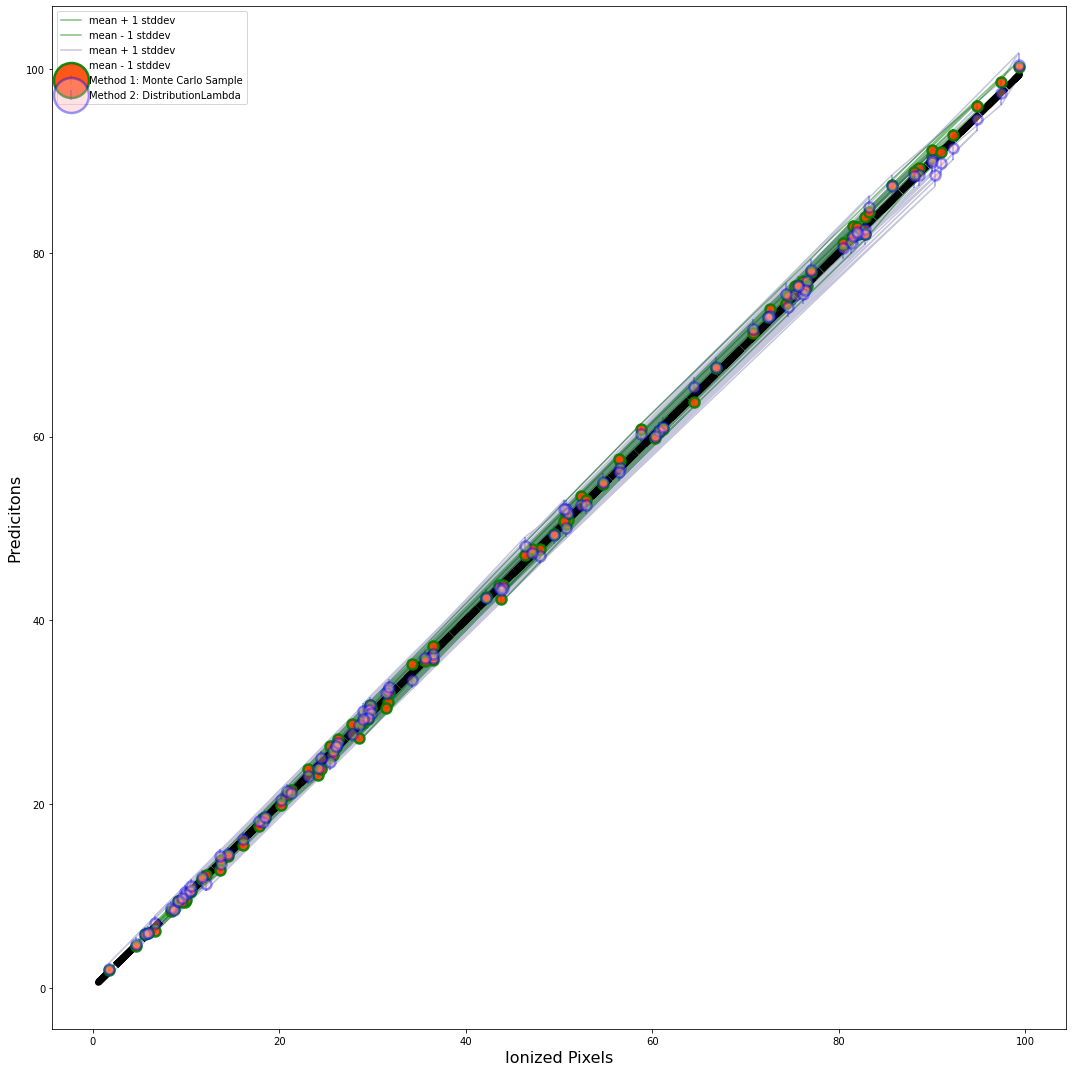

In [28]:
script.plot_error1(yhat=model(X_test), predictions= pred, y_test= y_test)

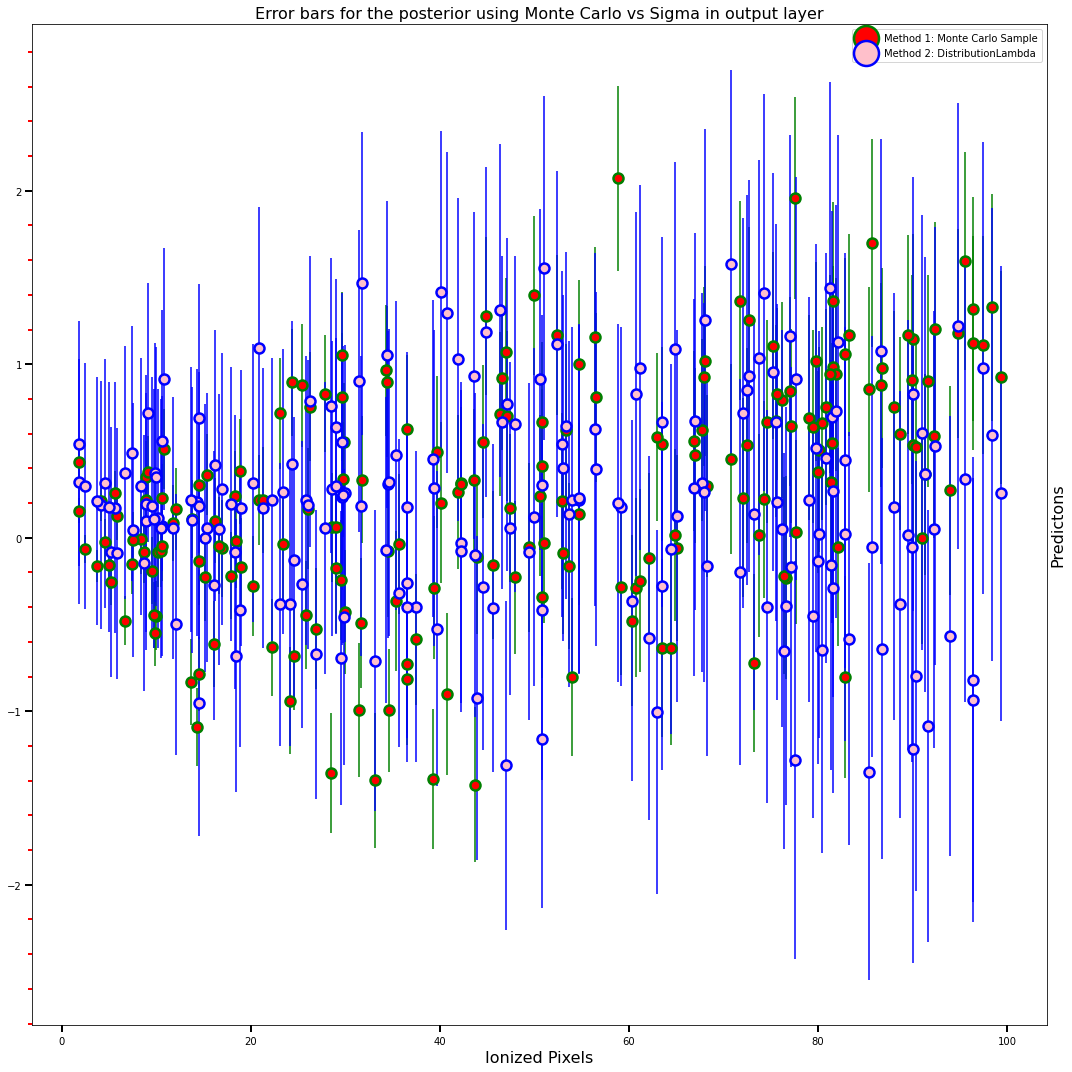

In [29]:
script.plot_error2(yhat=model(X_test), predictions= pred, y_test= y_test)

The variance of the predictions using the DistributionLambda method is approximately uniform

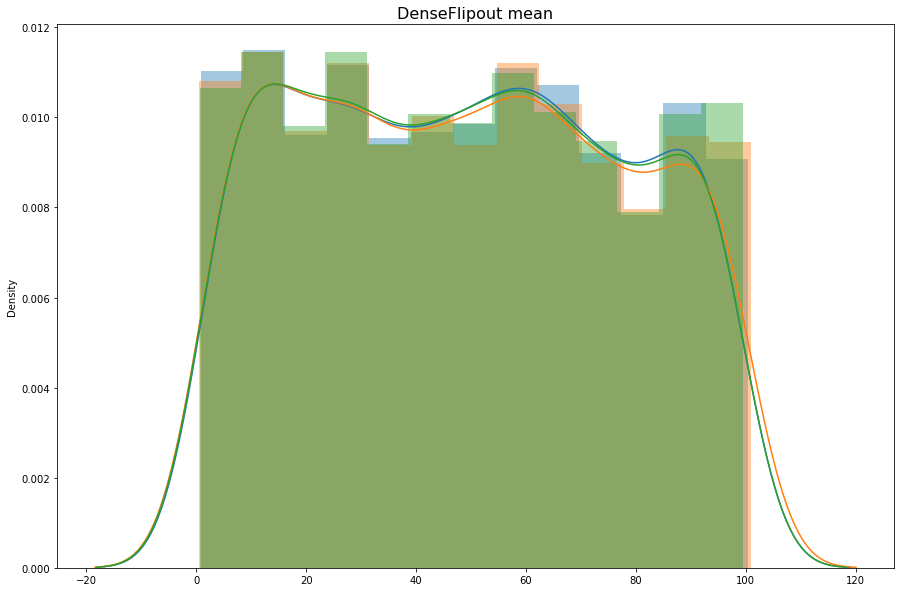

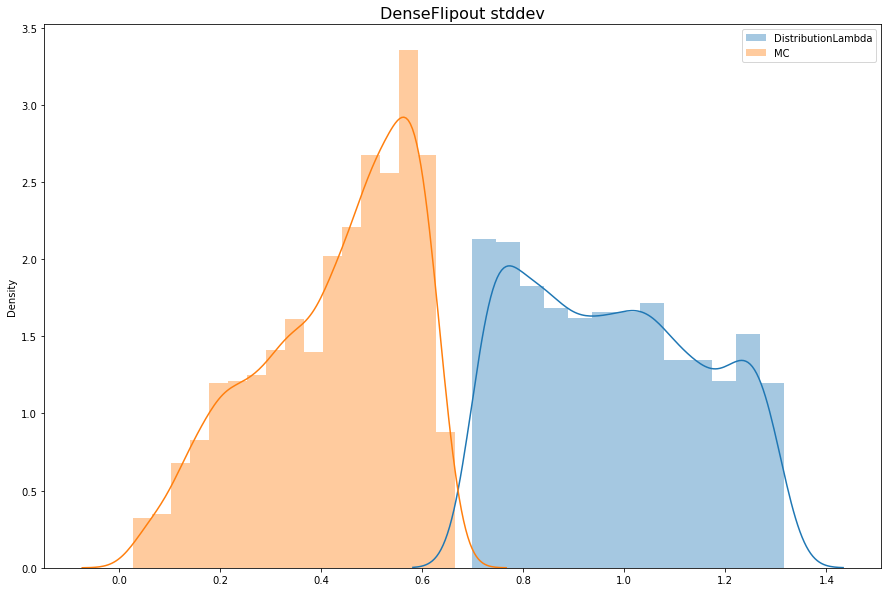

In [30]:
script.plot_distribution_mean_std(yhat=model(X_test), predictions= pred, y_test= y_test)

# Model 2

## Train Model Using Deterministic Loss Function



In [45]:
outputdir = ""
if os.path.isdir(project_name): # check to see if path exists
    os.system("rm -rvf {}".format(project_name))

def model2_dloss(hp):

    # Making a model.
    model = Sequential()

    # Added Layers.
    model.add(tfp.layers.Convolution2DFlipout(filters = 16,
                                              input_shape=(nx, ny, 1), kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu'
                                              , padding = 'valid',
                                              ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(tfp.layers.DenseFlipout(8, activation="relu", kernel_divergence_fn=kl_divergence_function,))
    model.add(tfp.layers.Convolution2DFlipout(filters = 8,
                                              kernel_size=3, activation = 'relu',
                                              kernel_divergence_fn=kl_divergence_function,
                                              padding = 'same'
                                              ))
    model.add(BatchNormalization())

    model.add(tfp.layers.DenseFlipout(4, activation="relu", kernel_divergence_fn=kl_divergence_function,))
    model.add(tfp.layers.Convolution2DFlipout(filters = 4,
                                              kernel_size=3, activation = 'relu',
                                              kernel_divergence_fn=kl_divergence_function,
                                              padding = 'same'
                                              ))
    model.add(BatchNormalization())

    model.add(tfp.layers.DenseFlipout(2, activation="relu", kernel_divergence_fn=kl_divergence_function,))
    model.add(tfp.layers.Convolution2DFlipout(filters = 2,
                                              kernel_size=3, activation = 'relu',
                                              kernel_divergence_fn=kl_divergence_function,
                                              padding = 'same'
                                              ))
    model.add(BatchNormalization())

    model.add(tfp.layers.DenseFlipout(4, activation="relu", kernel_divergence_fn=kl_divergence_function,))
    model.add(tfp.layers.Convolution2DFlipout(filters = 4,
                                              kernel_size=3, activation = 'relu',
                                              kernel_divergence_fn=kl_divergence_function,
                                              padding = 'same'
                                              ))
    model.add(BatchNormalization())

    model.add(tfp.layers.DenseFlipout(2, activation="relu", kernel_divergence_fn=kl_divergence_function,))
    model.add(tfp.layers.Convolution2DFlipout(filters = 2,
                                              kernel_size=3, activation = 'relu',
                                              kernel_divergence_fn=kl_divergence_function,
                                              padding = 'same'
                                              ))
    model.add(BatchNormalization())

    model.add(tfp.layers.DenseFlipout(1, activation="relu", kernel_divergence_fn=kl_divergence_function,))
    model.add(tfp.layers.Convolution2DFlipout(filters = 1,
                                              kernel_size=3, activation = 'relu',
                                              kernel_divergence_fn=kl_divergence_function,
                                              padding = 'same'
                                              ))
    model.add(BatchNormalization())

    model.add(tfp.layers.Convolution2DFlipout(filters = 1,
                                              kernel_size=3, activation = 'relu',
                                              kernel_divergence_fn=kl_divergence_function,
                                              padding = 'same'
                                              ))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(tfp.layers.DenseFlipout(1, activation="linear", kernel_divergence_fn=kl_divergence_function,))

    #for l in range(hp.Int('loss', 0, len(losses))):
    model.compile(optimizer= "adam", loss = hp.Choice('loss_type', ["mse", "mae", "mape", "Mean_Squared_over_true_Error"], ordered=False, default="mse"), metrics=["mse"])

    # Visualize Model
    print(model.summary())

    return model

In [46]:
# Random searrch through choices
tuner_models = script.random_search(model= model2_dloss,
                                    num_models= num_models,
                                    outputdir= outputdir,
                                    project_name= project_name,
                                    X_train= X_train, 
                                    y_train= y_train,
                                    X_test= X_test, 
                                    y_test= y_test,
                                    epochs= HP_EPOCH,
                                    HP_BATCH_SIZE=HP_BATCH_SIZE,
                                   )


Trial 4 Complete [00h 11m 56s]
val_loss: 1.3613228797912598

Best val_loss So Far: 0.16472406685352325
Total elapsed time: 00h 48m 16s
INFO:tensorflow:Oracle triggered exit
--------------------------------------------------
Tuning Summary
--------------------------------------------------
Results summary
Results in ./toy_model_tuner_32
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
loss_type: Mean_Squared_over_true_Error
Score: 0.16472406685352325
Trial summary
Hyperparameters:
loss_type: mae
Score: 1.3613228797912598
Trial summary
Hyperparameters:
loss_type: mse
Score: 1.5379669666290283
Trial summary
Hyperparameters:
loss_type: mape
Score: 84.56525421142578
Search space summary
Default search space size: 1
loss_type (Choice)
{'default': 'mse', 'conditions': [], 'values': ['mse', 'mae', 'mape', 'Mean_Squared_over_true_Error'], 'ordered': False}
Model: "sequential"
_________________________________________________________________
Layer

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 30, 30, 16)        304       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 16)        0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 15, 15, 8)         264       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 15, 15, 8)         1160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 8)         32        
_________________________________________________________________
dense_flipout_1 (DenseFlipou (None, 15, 15, 4)         6

In [47]:
# print best performing model's loss function
tuner_models[0].loss

'Mean_Squared_over_true_Error'

In [48]:
# returns a list of model
tuner_models

In [49]:
# List of losses: the quantity that a model should seek to minimize during training.
tuner_models[0].losses

[<tf.Tensor 'conv2d_flipout/divergence_kernel:0' shape=() dtype=float32>,
 <tf.Tensor 'dense_flipout/divergence_kernel:0' shape=() dtype=float32>,
 <tf.Tensor 'conv2d_flipout_1/divergence_kernel:0' shape=() dtype=float32>,
 <tf.Tensor 'dense_flipout_1/divergence_kernel:0' shape=() dtype=float32>,
 <tf.Tensor 'conv2d_flipout_2/divergence_kernel:0' shape=() dtype=float32>,
 <tf.Tensor 'dense_flipout_2/divergence_kernel:0' shape=() dtype=float32>,
 <tf.Tensor 'conv2d_flipout_3/divergence_kernel:0' shape=() dtype=float32>,
 <tf.Tensor 'dense_flipout_3/divergence_kernel:0' shape=() dtype=float32>,
 <tf.Tensor 'conv2d_flipout_4/divergence_kernel:0' shape=() dtype=float32>,
 <tf.Tensor 'dense_flipout_4/divergence_kernel:0' shape=() dtype=float32>,
 <tf.Tensor 'conv2d_flipout_5/divergence_kernel:0' shape=() dtype=float32>,
 <tf.Tensor 'dense_flipout_5/divergence_kernel:0' shape=() dtype=float32>,
 <tf.Tensor 'conv2d_flipout_6/divergence_kernel:0' shape=() dtype=float32>,
 <tf.Tensor 'conv2d_fl

### Monte Carlo 

Use Monte Carlo sampling of the models and average the predicted predictions to get the predicted values and make one-to-one plot. In the plot below I compare the models and then from there it's clear who doesn't do well at all (blue line). Obvisouly, if I trained the model for a longer time then I would expect it to improve the other predictions but this is good enough. 

In [51]:
# make list of predictions using all of the model
predictions = script.mc_pred_tuner_models(tuner_models=tuner_models, X_test=X_test)

(2000, 32, 32, 1)
(5, 2000)


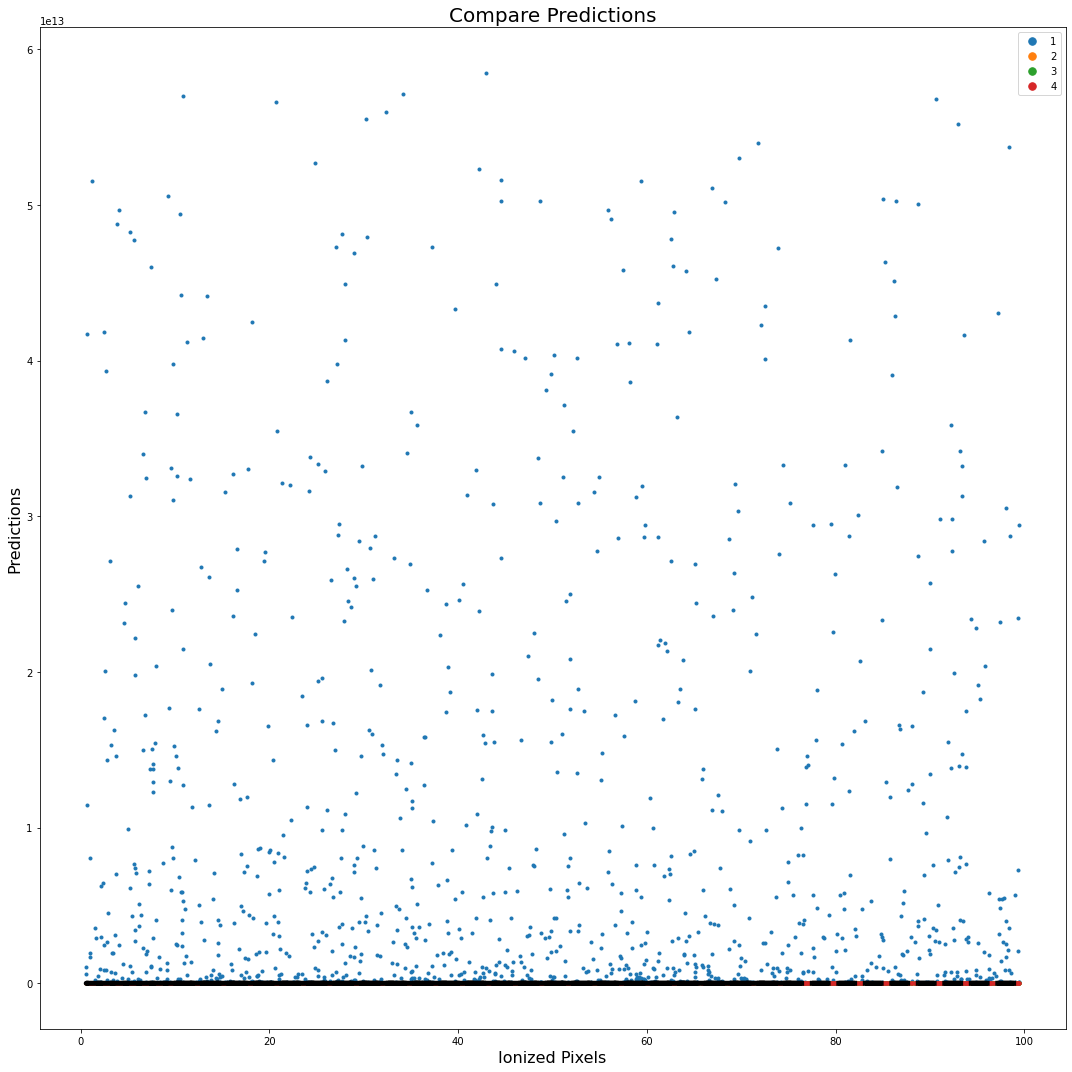

In [52]:
script.plot_one_to_one_pred(tuner_models= tuner_models, y_test= y_test, predictions=predictions)

In [70]:
predictions.shape

(5, 2000)

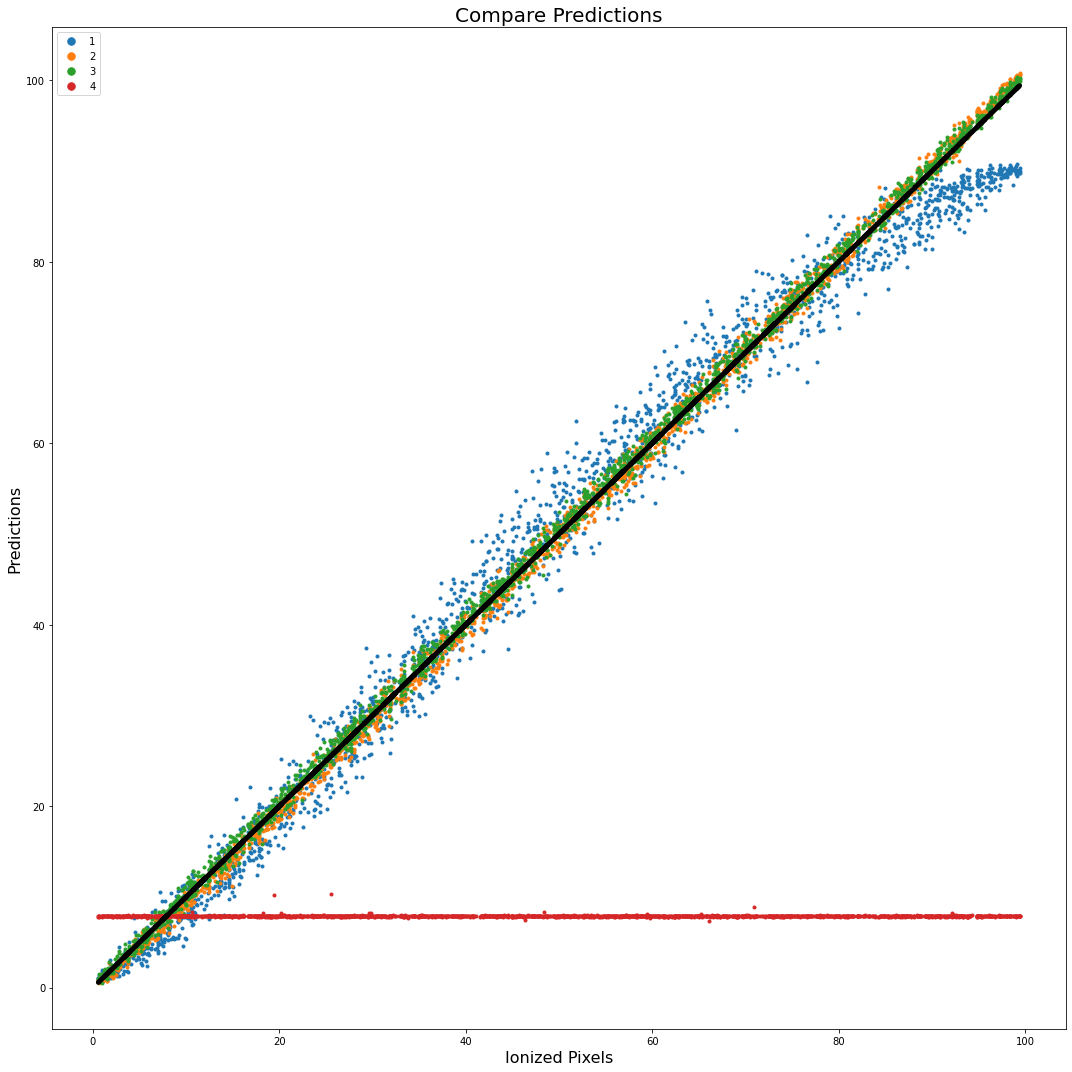

In [73]:
script.plot_one_to_one_pred(tuner_models= tuner_models, y_test= y_test, predictions=predictions[1:,:])

In [76]:
tuner_models[-2].loss

'mse'

In [77]:
# make list of predictions using the best model
pred = script.mc_pred(bestmodel=tuner_models[-2], X_test=X_test)

In the plot below I look at a subset of predicted ionized pixel values. I would have selected any range but I chose 0-2. Well, the good thing is that it looks like the model doesn't try to guess values less than 0... That would make no sense. We do see multiple peaks. More than two peaks is no longer a bimodal distribution. It's a Multimidal distribution and would also represent multiple local maximums; these are points where the data points stop increasing and start decreasing.  

https://www.statisticshowto.com/what-is-a-bimodal-distribution/

No handles with labels found to put in legend.


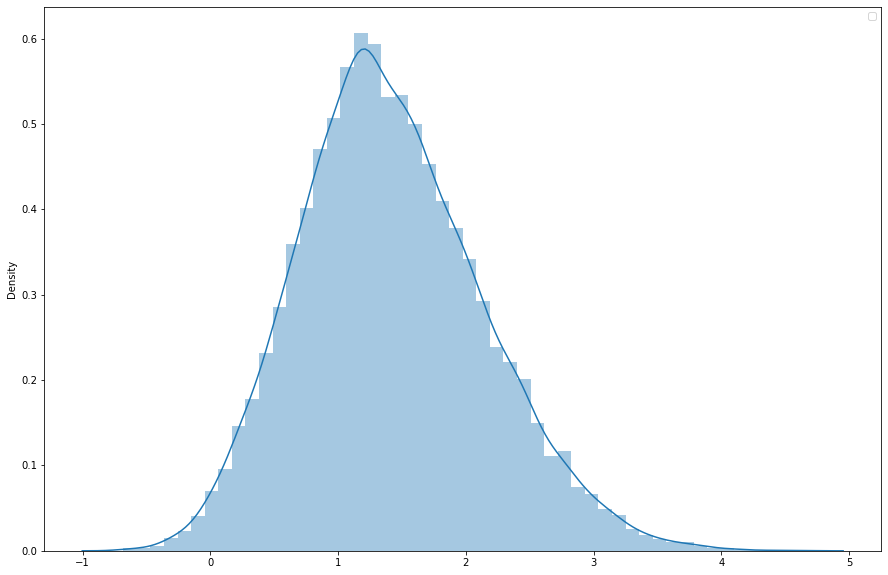

In [78]:
script.plot_pred_distribution_range(predictions=pred, y_test=y_test, upper_lim=2, lower_lim=0)

Ideally we would want this distribution to be centred at zero because we are looking at the distribution of the difference between the pred and the true value. There is clearly some presence of divergence the distribution. I can't see much skewed behavior but I do see the presenece of kurtosis (positive and negative).  Some of thee distributions have pretty fat tails too.

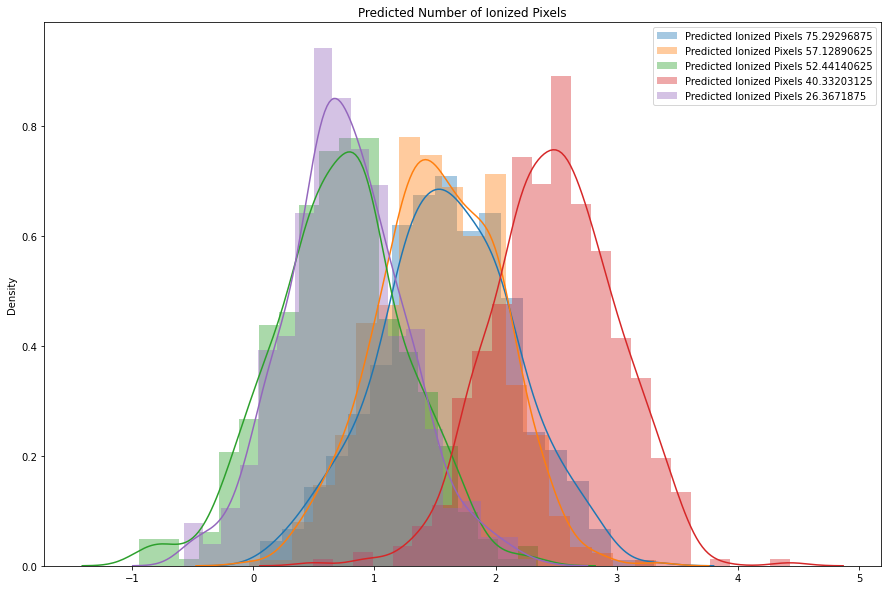

In [79]:
script.plot_pred_distribution(predictions= pred, y_test= y_test)

### Empirical Examination of Posterior Distribution

Looks like the std of the weights areen't negative... Good. There are very clear double peaks (bimodal distirbution?).  

Weight distribution says something interesting I think. Going from the 1st convolution layer to the second more weights are zero. So, they aren't important when looking at this data.

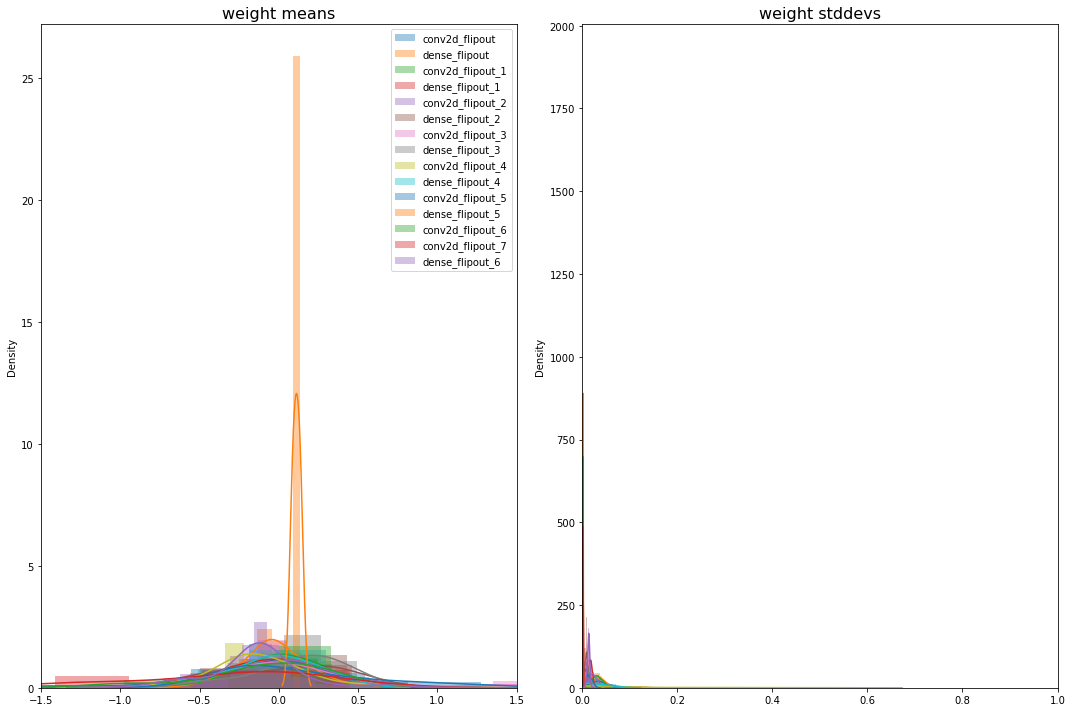

In [80]:
script.plot_qm_qs_vals(bnn_model= tuner_models[-2])

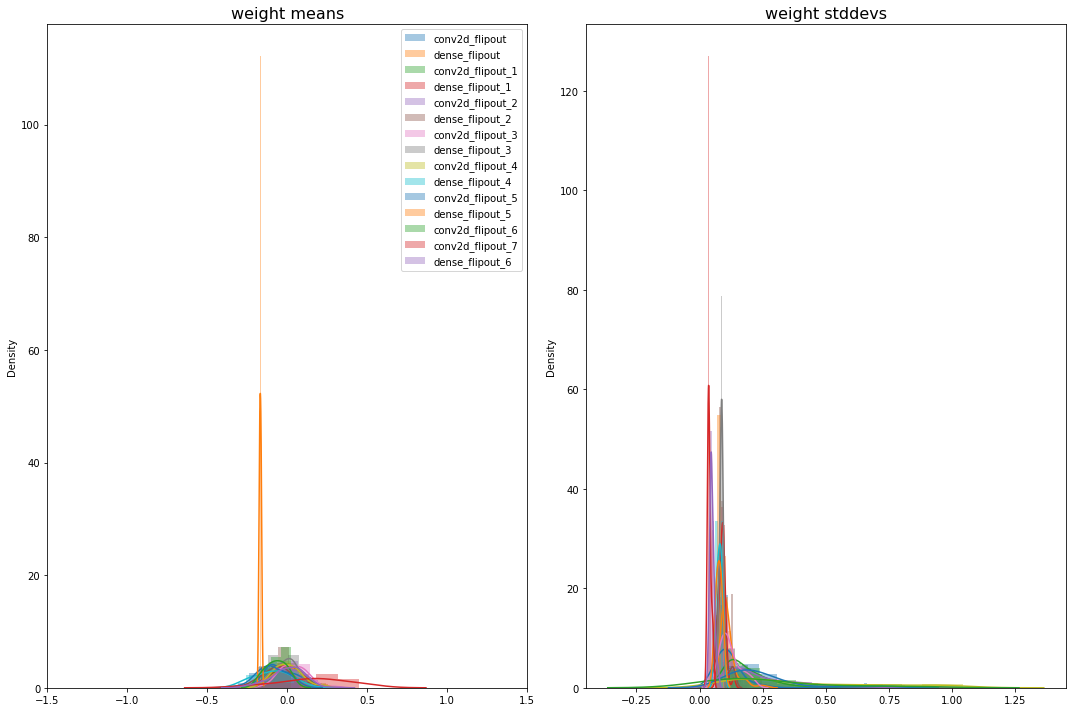

In [81]:
def plot_qm_qs_vals(bnn_model=tuner_models[-2]):
    
    names = [layer.name for layer in bnn_model.layers if "flipout" in layer.name]
    
    qm_vals = [
        layer.kernel_posterior.mean()
        for layer in bnn_model.layers
        if "flipout" in layer.name
    ]
    qs_vals = [
        layer.kernel_posterior.stddev()
        for layer in bnn_model.layers
        if "flipout" in layer.name
    ]


    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(1, 2, 1)
    for n, qm in zip(names, qm_vals):
        sns.distplot(tf.reshape(qm, shape=[-1]), ax=ax, label=n)
    ax.set_title("weight means",size = 16 )
    ax.set_xlim([-1.5, 1.5])
    ax.legend()
    ax = fig.add_subplot(1, 2, 2)
    for n, qs in zip(names, qs_vals):
        sns.distplot(tf.reshape(qs, shape=[-1]), ax=ax)
    ax.set_title("weight stddevs", size = 16)
    #ax.set_xlim([0, 1.0])
    fig.tight_layout()
    plt.show()
    
plot_qm_qs_vals(bnn_model=tuner_models[-1])

## Train Model Using Probabilistic Loss Function

This is the same architecture as above but instead train the model using a non-deterministic loss function and train it 6 times as long. This does extremely well as you can see in the one-to-one. I shuold try this with "elbo" loss function too. You can also compare the performance of the twoo models because they have a common metric "mse". In the model above "Score: 1.8561763763427734". In this model the "Score: 1.650"

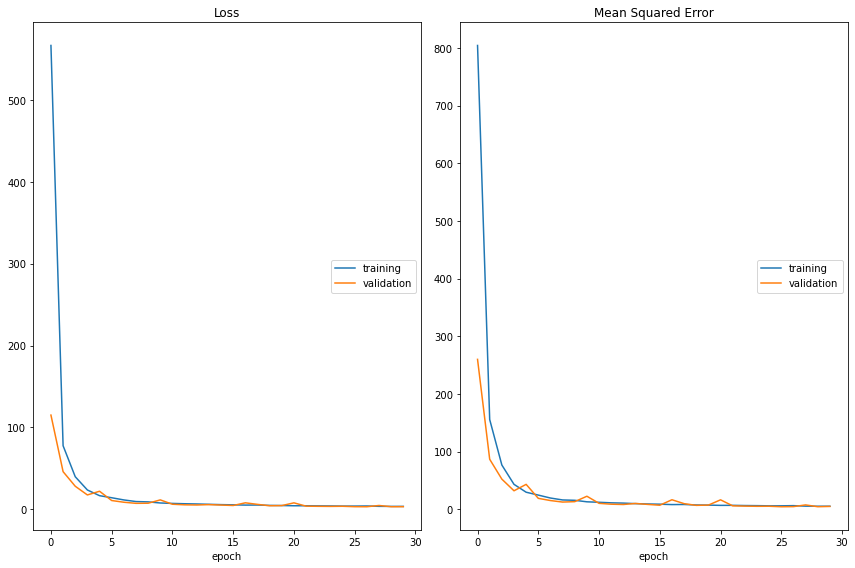

Loss
	training         	 (min:    3.579, max:  566.390, cur:    3.589)
	validation       	 (min:    3.173, max:  115.073, cur:    3.257)
Mean Squared Error
	training         	 (min:    5.132, max:  804.115, cur:    5.161)
	validation       	 (min:    4.272, max:  259.810, cur:    4.816)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout_16 (Conv2DFli (None, 30, 30, 16)        304       
_________________________________________________________________
batch_normalization_16 (Batc (None, 30, 30, 16)        64        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
dense_flipout_14 (DenseFlipo (None, 15, 15, 8)         264       
_________________________________________________________________
conv2d_flipout_17 (Conv2DFli (

In [88]:
def model2_ploss():

    # Making a model.
    model = Sequential()

    # Added Layers.
    model.add(tfp.layers.Convolution2DFlipout(filters = 16,
                                              input_shape=(nx, ny, 1), kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu'
                                              , padding = 'valid',
                                              ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(tfp.layers.DenseFlipout(8, activation="relu", kernel_divergence_fn=kl_divergence_function,))
    model.add(tfp.layers.Convolution2DFlipout(filters = 8,
                                              kernel_size=3, activation = 'relu',
                                              kernel_divergence_fn=kl_divergence_function,
                                              padding = 'same'
                                              ))
    model.add(BatchNormalization())

    model.add(tfp.layers.DenseFlipout(4, activation="relu", kernel_divergence_fn=kl_divergence_function,))
    model.add(tfp.layers.Convolution2DFlipout(filters = 4,
                                              kernel_size=3, activation = 'relu',
                                              kernel_divergence_fn=kl_divergence_function,
                                              padding = 'same'
                                              ))
    model.add(BatchNormalization())

    model.add(tfp.layers.DenseFlipout(2, activation="relu", kernel_divergence_fn=kl_divergence_function,))
    model.add(tfp.layers.Convolution2DFlipout(filters = 2,
                                              kernel_size=3, activation = 'relu',
                                              kernel_divergence_fn=kl_divergence_function,
                                              padding = 'same'
                                              ))
    model.add(BatchNormalization())

    model.add(tfp.layers.DenseFlipout(4, activation="relu", kernel_divergence_fn=kl_divergence_function,))
    model.add(tfp.layers.Convolution2DFlipout(filters = 4,
                                              kernel_size=3, activation = 'relu',
                                              kernel_divergence_fn=kl_divergence_function,
                                              padding = 'same'
                                              ))
    model.add(BatchNormalization())

    model.add(tfp.layers.DenseFlipout(2, activation="relu", kernel_divergence_fn=kl_divergence_function,))
    model.add(tfp.layers.Convolution2DFlipout(filters = 2,
                                              kernel_size=3, activation = 'relu',
                                              kernel_divergence_fn=kl_divergence_function,
                                              padding = 'same'
                                              ))
    model.add(BatchNormalization())

    model.add(tfp.layers.DenseFlipout(1, activation="relu", kernel_divergence_fn=kl_divergence_function,))
    model.add(tfp.layers.Convolution2DFlipout(filters = 1,
                                              kernel_size=3, activation = 'relu',
                                              kernel_divergence_fn=kl_divergence_function,
                                              padding = 'same'
                                              ))
    model.add(BatchNormalization())

    model.add(tfp.layers.Convolution2DFlipout(filters = 1,
                                              kernel_size=3, activation = 'relu',
                                              kernel_divergence_fn=kl_divergence_function,
                                              padding = 'same'
                                              ))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(tfp.layers.DenseFlipout(1, activation="linear", kernel_divergence_fn=kl_divergence_function,))

    model.add(tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           #scale = 1)))
                           scale=1e-3 + tf.math.softplus(0.01 * t[..., :1]))))
    

    model.compile(optimizer= "adam", loss = "neg_log_likelihood", metrics=["mse"])
    
    plotlosses = PlotLossesKeras()

    model.fit(X_train, y_train, validation_data=(X_test, y_test),
            epochs=HP_EPOCH, batch_size=HP_BATCH_SIZE,
            callbacks=[plotlosses],
            verbose=1)
    
    # Visualize Model                                                                                                                                                                      
    print(model.summary())

    loss = model.evaluate(X_test, y_test)
    return model
                                                                                                                                                                                      
model = model2_ploss()



### Monte Carlo 

In [58]:
# make predictions  
pred_distLambda = script.mc_pred(bestmodel=model, X_test=X_test)

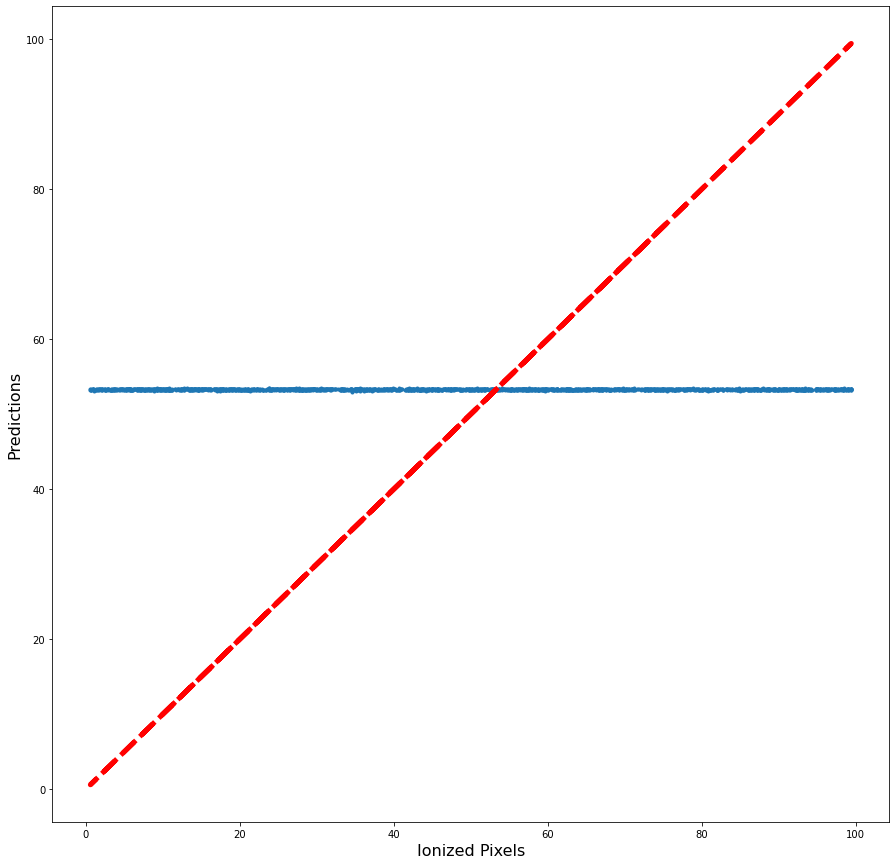

In [59]:
# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("")
plt.xlabel("Ionized Pixels", size = 16)
plt.ylabel("Predictions", size = 16)
plt.plot(y_test, np.mean(np.array(pred_distLambda), axis=0), '.')
plt.plot(y_test,y_test, "r--", linewidth=5)

These distibutions have fat tails too but they are closer to being centered at zero.

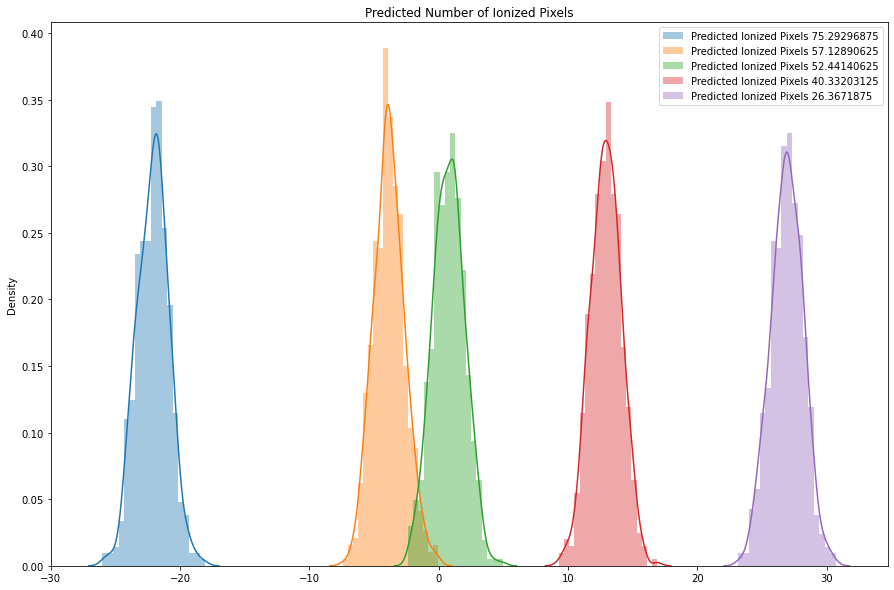

In [60]:
script.plot_pred_distribution(predictions= pred_distLambda, y_test= y_test)

### Plot the distribution of the predictions within a certain range.

No handles with labels found to put in legend.


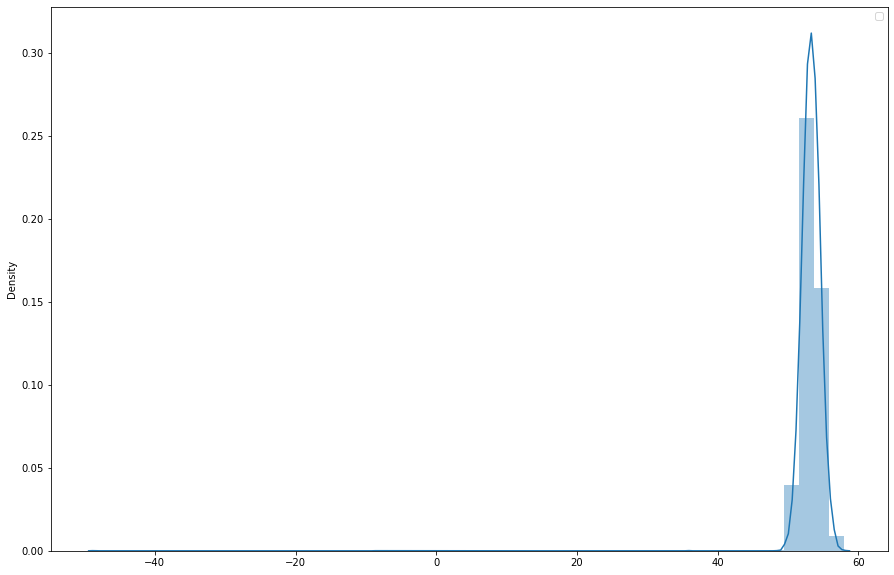

In [61]:
script.plot_pred_distribution_range(predictions=pred_distLambda, y_test=y_test, upper_lim=2, lower_lim=0)

No handles with labels found to put in legend.


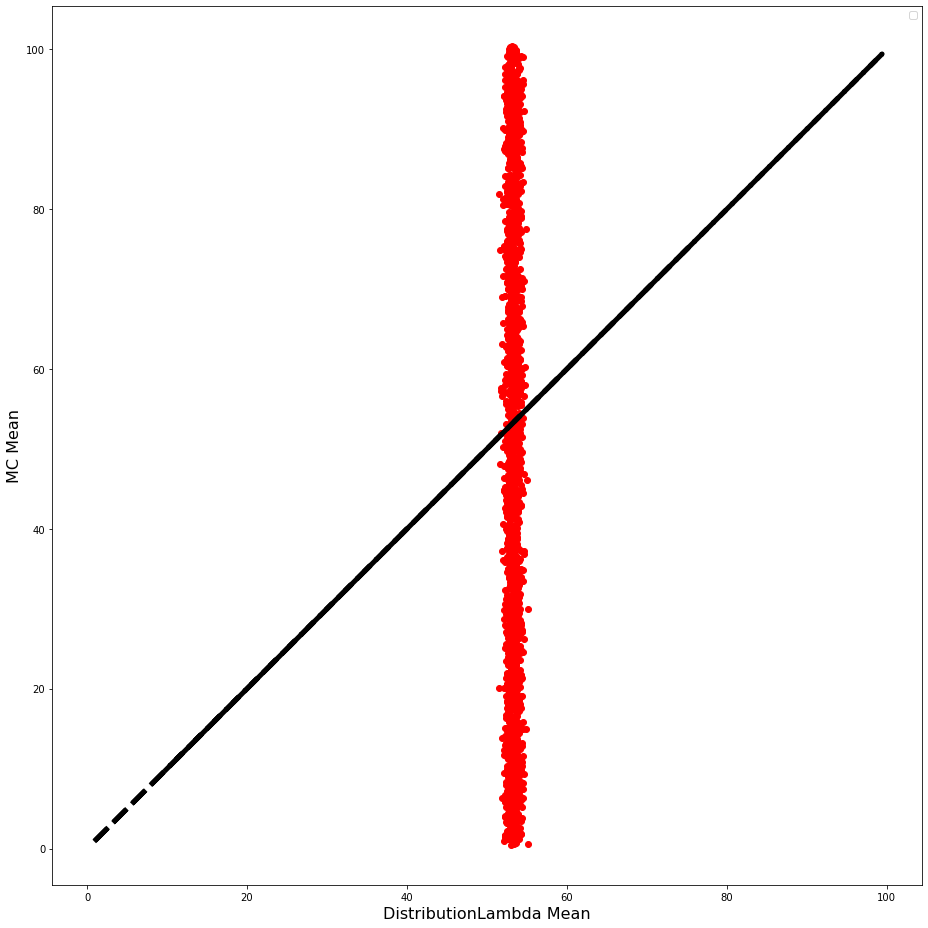

In [82]:
script.plot_compare_pred_values(yhat=model(X_test), predictions= pred, y_test= y_test)

... Very unclear what this shape means... I keep seeing it... idk...

No handles with labels found to put in legend.


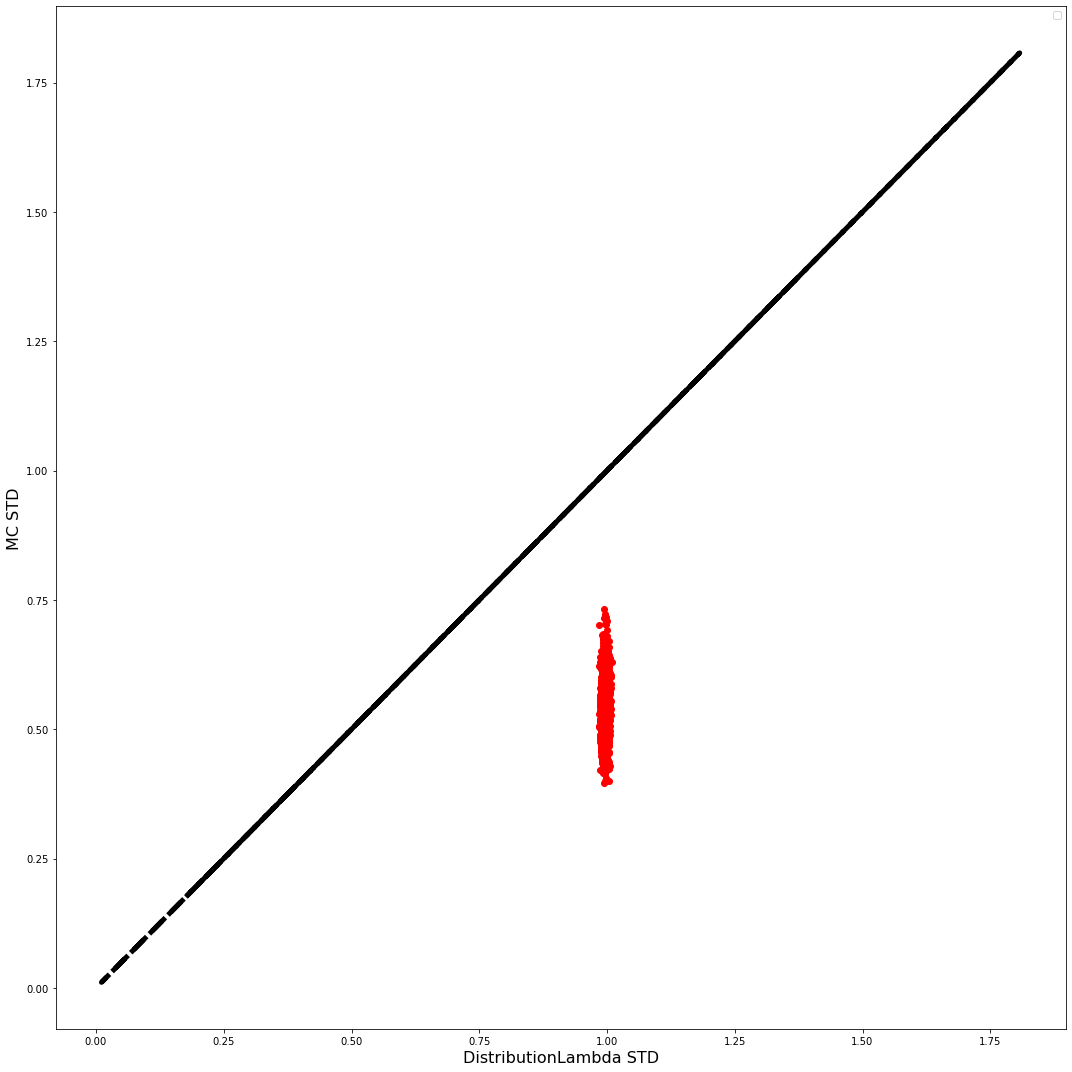

In [83]:
script.plot_compare_STDs(yhat=model(X_test), predictions= pred, y_test= y_test)

### Empirical Examination of Posterior Distribution

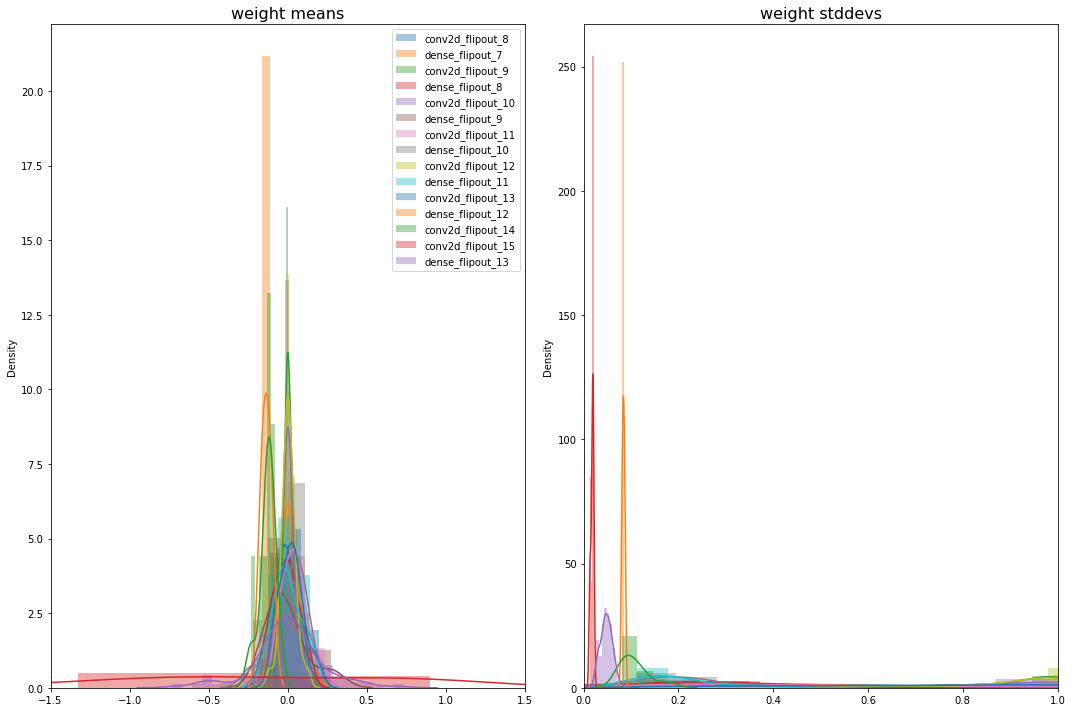

In [64]:
script.plot_qm_qs_vals(bnn_model= model)

## Learn STD and Mean

### Error Bars

METHOD 1:  Empirical error bars for the posterior using Monte Carlo  

METHOD 2: Sigma in output layer  

In [65]:
yhat = model(X_test) # model.predict(X_test)

MC predictions do really well here but what happens when we sample from the Lambda_distribution function?

Compare two prediction methods. MC sampling and Disttribution lambda are about the same so this is really good. MC can take a very long time so I guess this means in this case I don't need to use the MC sampling of the model.

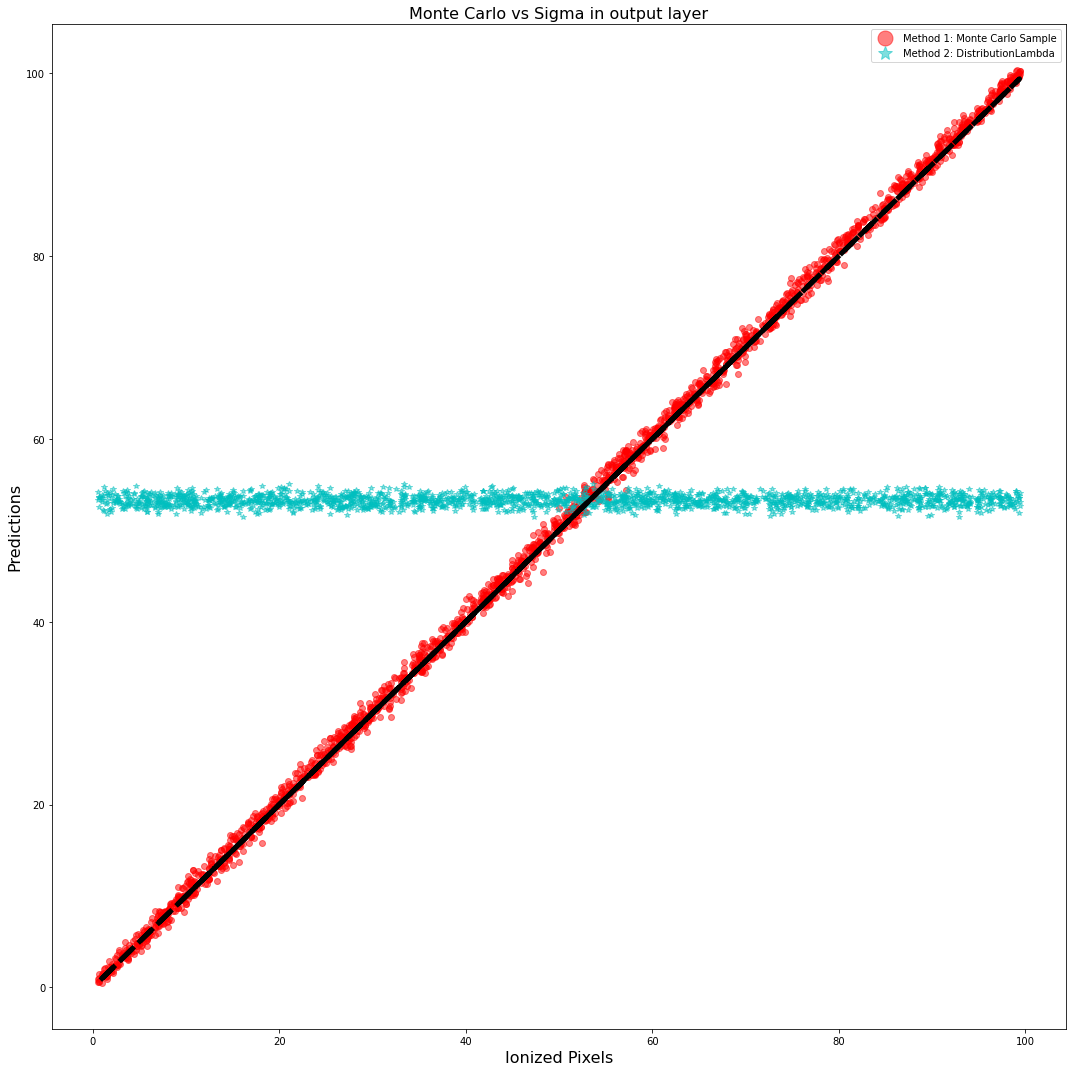

In [84]:
script.plot_one_to_one_pred_MC_DistributionLambda(yhat=model(X_test), predictions= pred, y_test= y_test)

We see some divergence as the number of ionized pixels increases. This is probably because I'm plotting the absolute error instead of the relative error. That could fix things maybe?

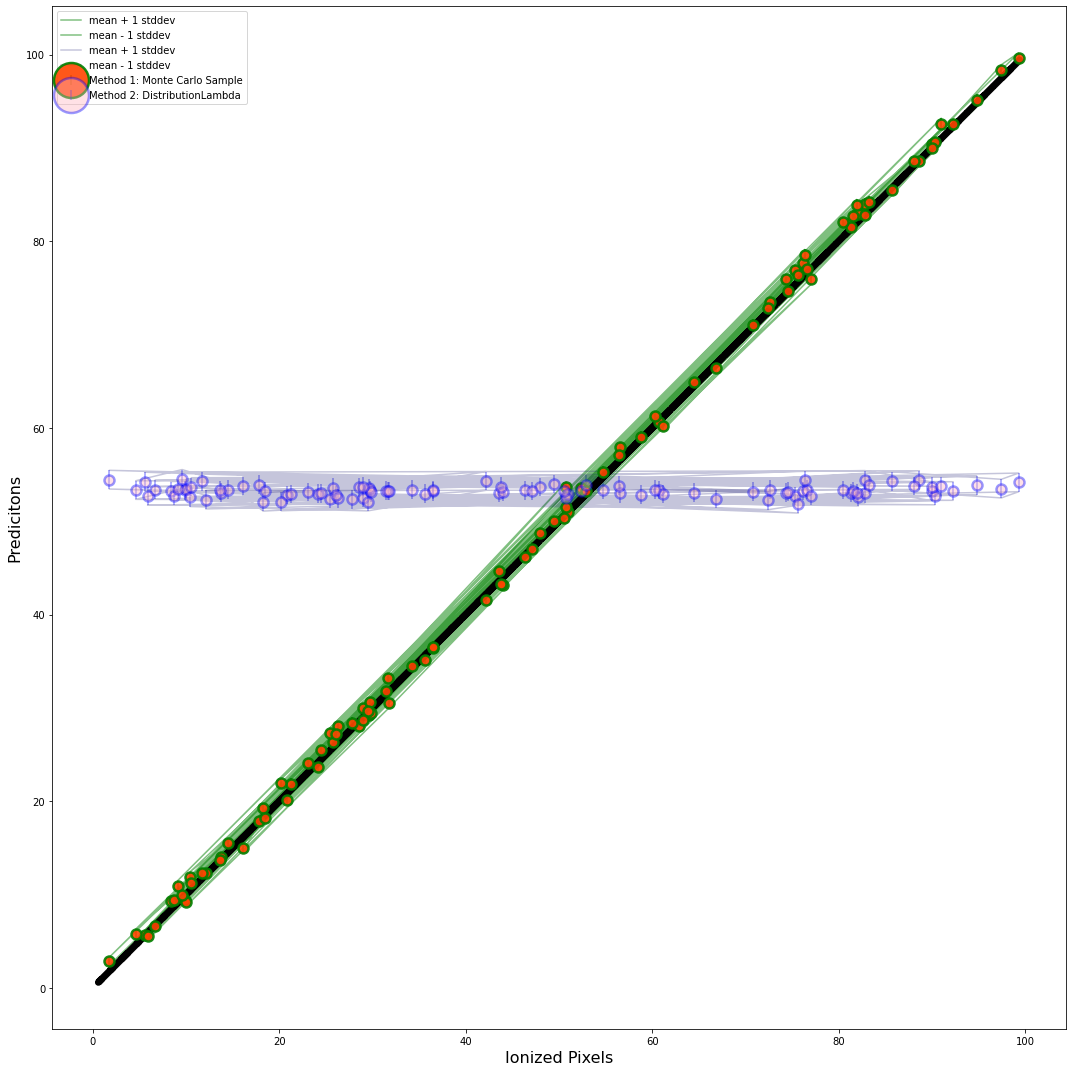

In [85]:
script.plot_error1(yhat=model(X_test), predictions= pred, y_test= y_test)

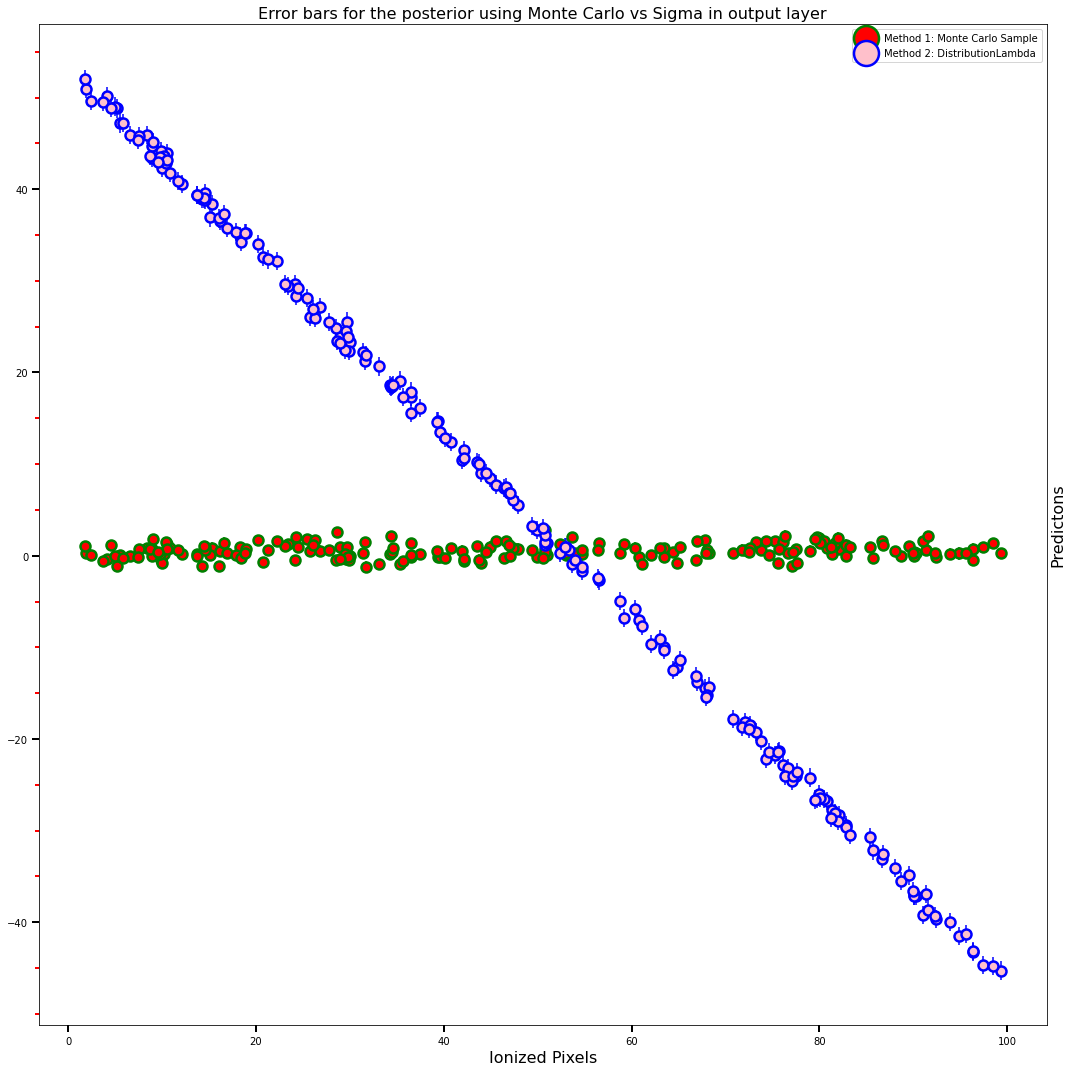

In [86]:
script.plot_error2(yhat=model(X_test), predictions= pred, y_test= y_test)

The variance of the predictions using the DistributionLambda method is approximately uniform

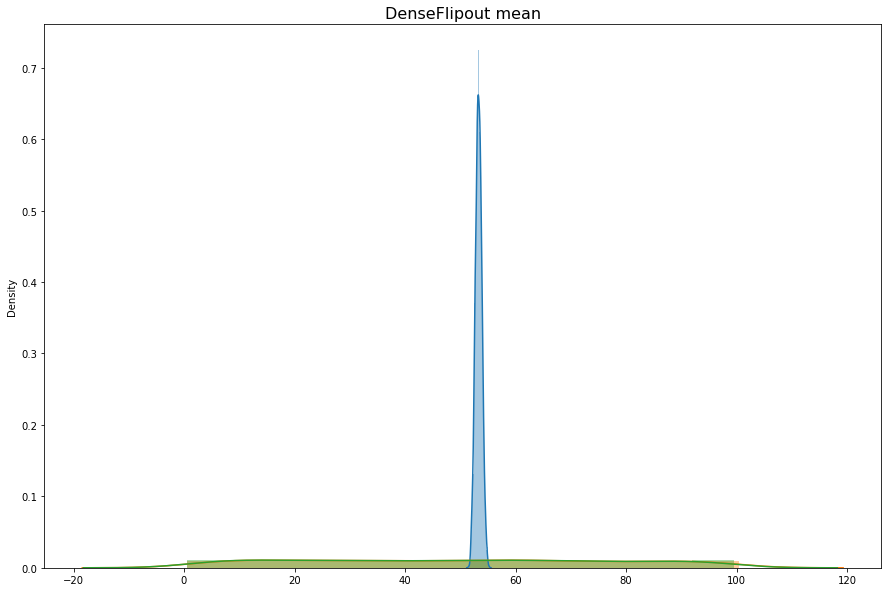

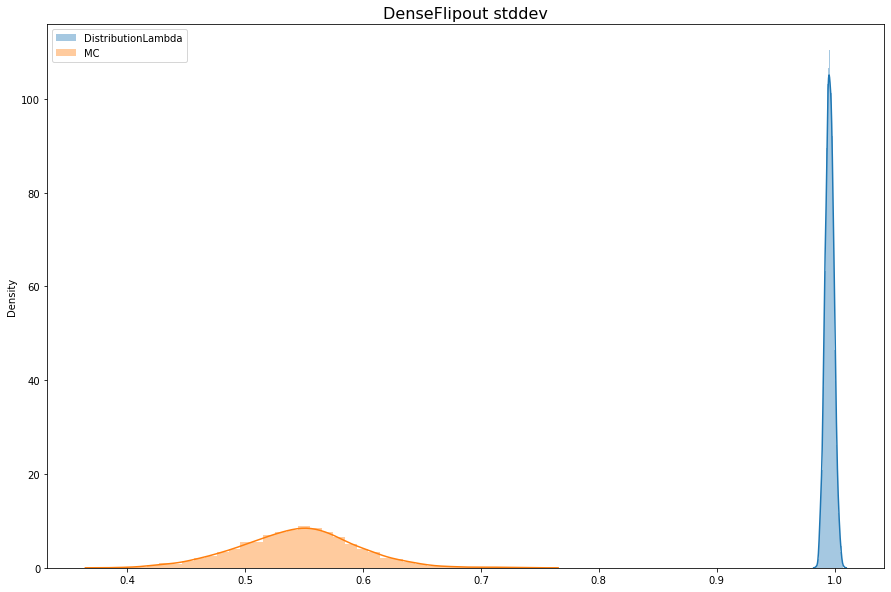

In [87]:
script.plot_distribution_mean_std(yhat=model(X_test), predictions= pred, y_test= y_test)

# Model 3

## Train Model Using Deterministic Loss Function



In [89]:
outputdir = ""
if os.path.isdir(project_name): # check to see if path exists
    os.system("rm -rvf {}".format(project_name))

def model3_dloss(hp):

    # Making a model.
    model = Sequential()

    # Added Layers.
    model.add(tfp.layers.Convolution2DFlipout(filters = 16,
                                              input_shape=(nx, ny, 1), kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu'
                                              , padding = 'valid',
                                              ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(tfp.layers.Convolution2DFlipout(filters = 8,
                                              kernel_size=3, activation = 'relu',
                                              kernel_divergence_fn=kl_divergence_function,
                                              padding = 'same'
                                              ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(tfp.layers.DenseFlipout(1, activation="linear", kernel_divergence_fn=kl_divergence_function,))

    #for l in range(hp.Int('loss', 0, len(losses))):
    model.compile(optimizer= "adam", loss = hp.Choice('loss_type', ["mse", "mae", "mape", "Mean_Squared_over_true_Error"], ordered=False, default="mse"), metrics=["mse"])

    # Visualize Model
    print(model.summary())

    return model

In [90]:
# Random searrch through choices
tuner_models = script.random_search(model= model3_dloss,
                                    num_models= num_models,
                                    outputdir= outputdir,
                                    project_name= project_name,
                                    X_train= X_train, 
                                    y_train= y_train,
                                    X_test= X_test, 
                                    y_test= y_test,
                                    epochs= HP_EPOCH,
                                    HP_BATCH_SIZE=HP_BATCH_SIZE,
                                   )


Trial 4 Complete [00h 06m 18s]
val_loss: 2.0898780822753906

Best val_loss So Far: 0.25609469413757324
Total elapsed time: 00h 24m 48s
INFO:tensorflow:Oracle triggered exit
--------------------------------------------------
Tuning Summary
--------------------------------------------------
Results summary
Results in ./toy_model_tuner_32
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
loss_type: Mean_Squared_over_true_Error
Score: 0.25609469413757324
Trial summary
Hyperparameters:
loss_type: mae
Score: 2.0898780822753906
Trial summary
Hyperparameters:
loss_type: mse
Score: 4.42161750793457
Trial summary
Hyperparameters:
loss_type: mape
Score: 6.73311185836792
Search space summary
Default search space size: 1
loss_type (Choice)
{'default': 'mse', 'conditions': [], 'values': ['mse', 'mae', 'mape', 'Mean_Squared_over_true_Error'], 'ordered': False}
Model: "sequential"
_________________________________________________________________
Layer (t

In [91]:
# print best performing model's loss function
tuner_models[0].loss

'Mean_Squared_over_true_Error'

In [92]:
# returns a list of model
tuner_models

In [93]:
# List of losses: the quantity that a model should seek to minimize during training.
tuner_models[0].losses

[<tf.Tensor 'conv2d_flipout/divergence_kernel:0' shape=() dtype=float32>,
 <tf.Tensor 'conv2d_flipout_1/divergence_kernel:0' shape=() dtype=float32>,
 <tf.Tensor 'dense_flipout/divergence_kernel:0' shape=() dtype=float32>]

### Monte Carlo 

Use Monte Carlo sampling of the models and average the predicted predictions to get the predicted values and make one-to-one plot. In the plot below I compare the models and then from there it's clear who doesn't do well at all (blue line). Obvisouly, if I trained the model for a longer time then I would expect it to improve the other predictions but this is good enough. 

In [94]:
# make list of predictions using all of the model
predictions = script.mc_pred_tuner_models(tuner_models=tuner_models, X_test=X_test)

(2000, 32, 32, 1)
(5, 2000)


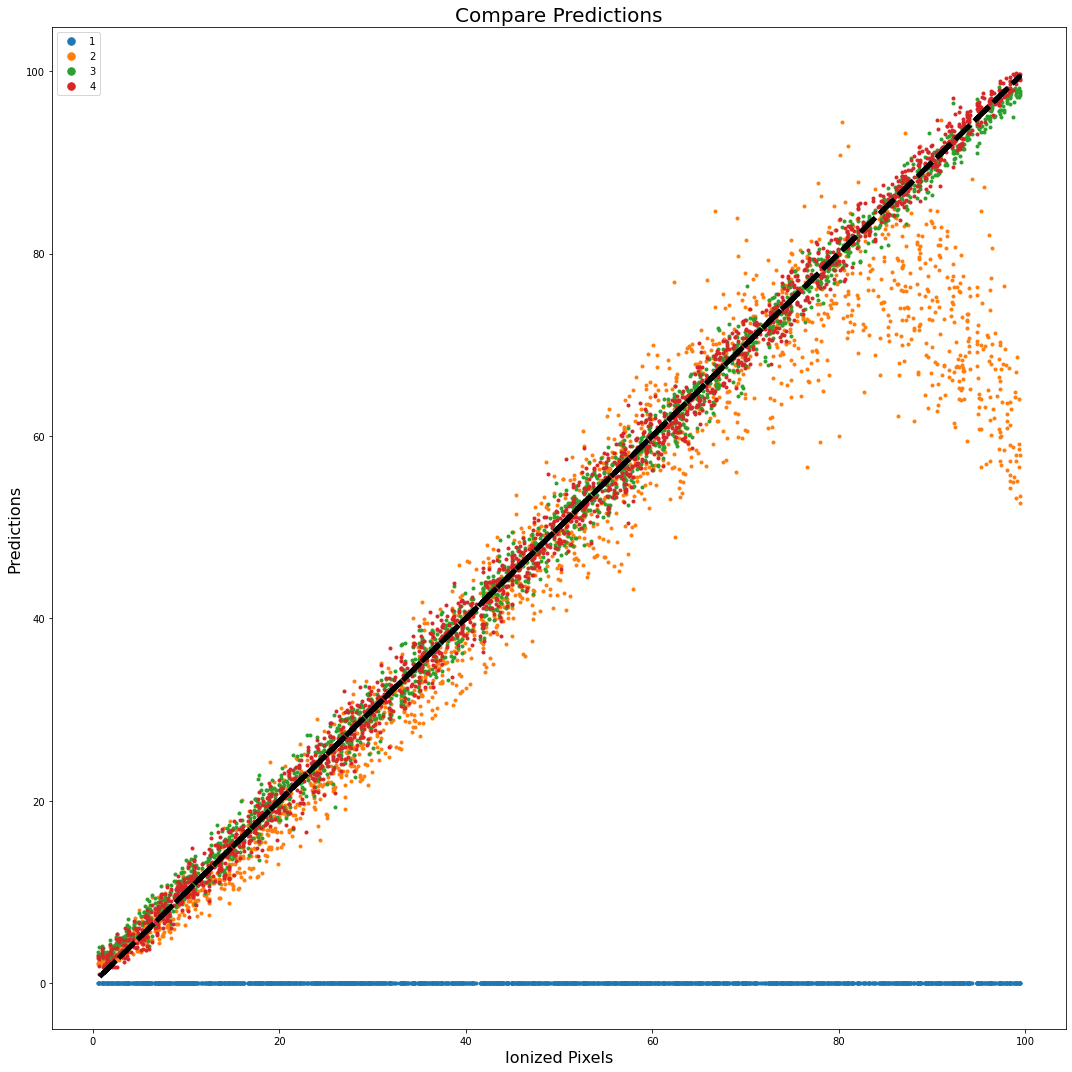

In [95]:
script.plot_one_to_one_pred(tuner_models= tuner_models, y_test= y_test, predictions=predictions)

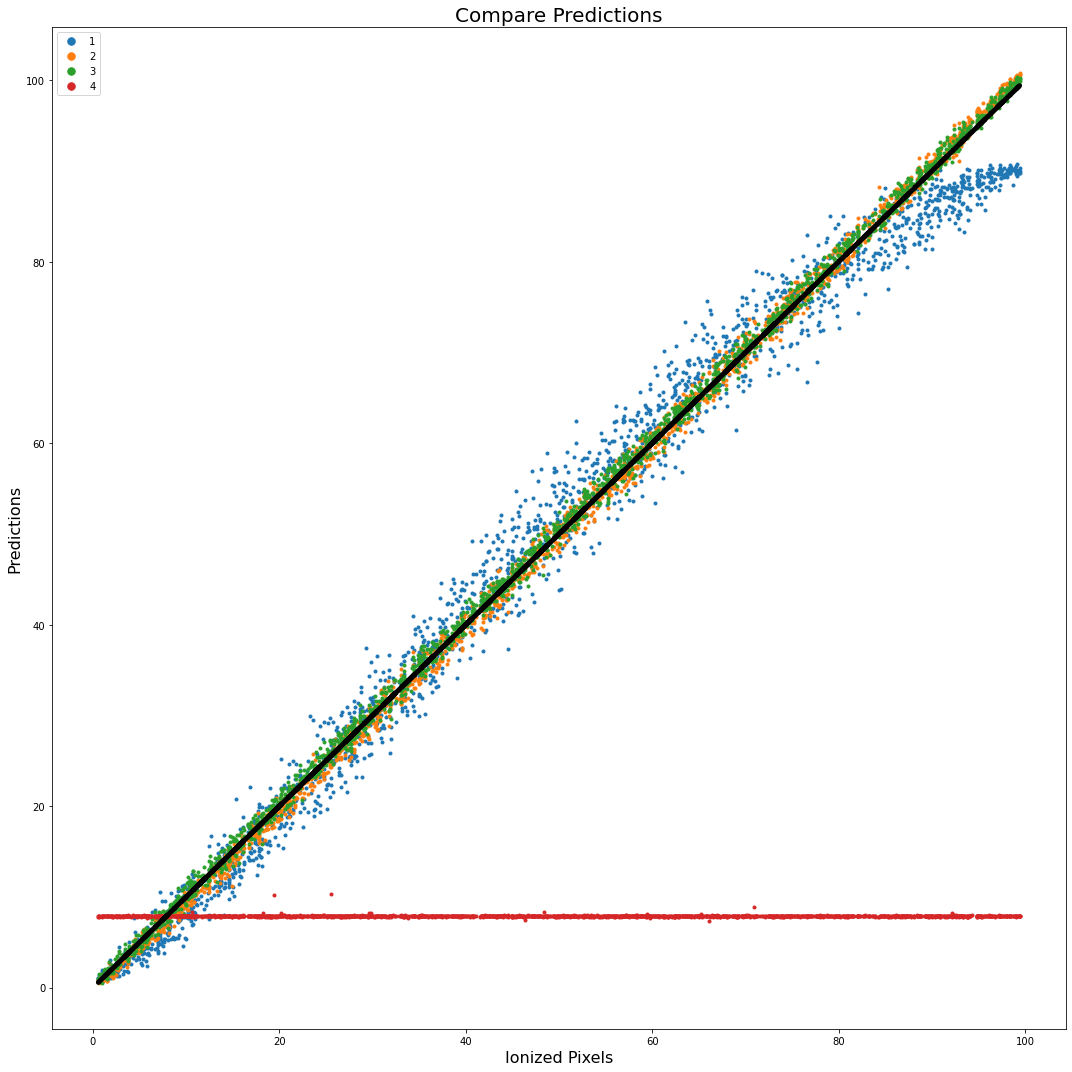

In [73]:
script.plot_one_to_one_pred(tuner_models= tuner_models, y_test= y_test, predictions=predictions[1:,:])

In [96]:
tuner_models[-2].loss

'mse'

In [97]:
# make list of predictions using the best model
pred = script.mc_pred(bestmodel=tuner_models[-2], X_test=X_test)

In the plot below I look at a subset of predicted ionized pixel values. I would have selected any range but I chose 0-2. Well, the good thing is that it looks like the model doesn't try to guess values less than 0... That would make no sense. We do see multiple peaks. More than two peaks is no longer a bimodal distribution. It's a Multimidal distribution and would also represent multiple local maximums; these are points where the data points stop increasing and start decreasing.  

https://www.statisticshowto.com/what-is-a-bimodal-distribution/

No handles with labels found to put in legend.


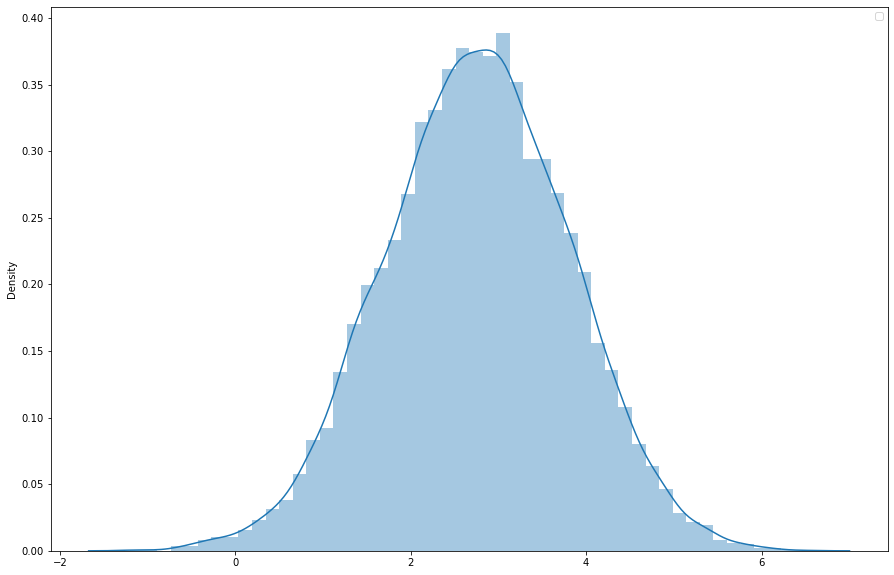

In [98]:
script.plot_pred_distribution_range(predictions=pred, y_test=y_test, upper_lim=2, lower_lim=0)

Ideally we would want this distribution to be centred at zero because we are looking at the distribution of the difference between the pred and the true value. There is clearly some presence of divergence the distribution. I can't see much skewed behavior but I do see the presenece of kurtosis (positive and negative).  Some of thee distributions have pretty fat tails too.

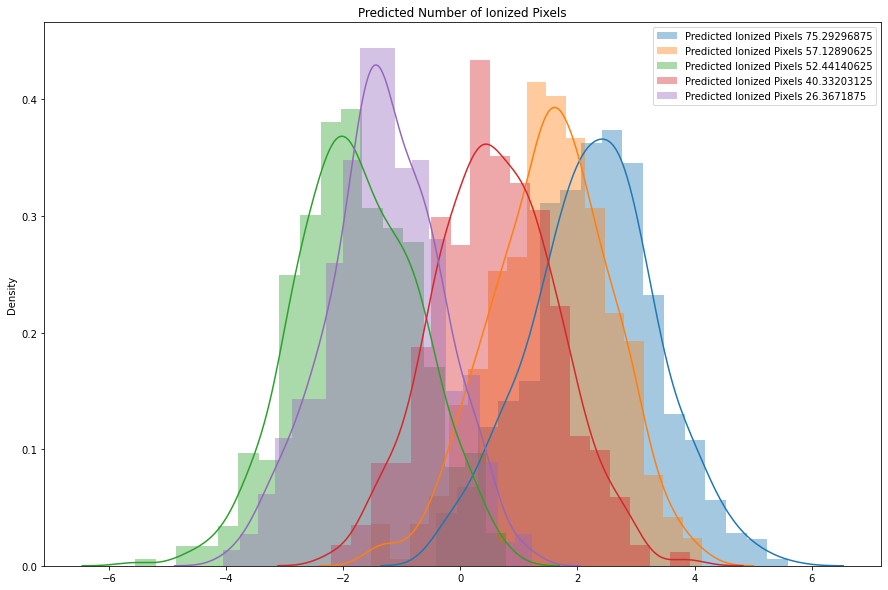

In [99]:
script.plot_pred_distribution(predictions= pred, y_test= y_test)

### Empirical Examination of Posterior Distribution

Looks like the std of the weights areen't negative... Good. There are very clear double peaks (bimodal distirbution?).  

Weight distribution says something interesting I think. Going from the 1st convolution layer to the second more weights are zero. So, they aren't important when looking at this data.

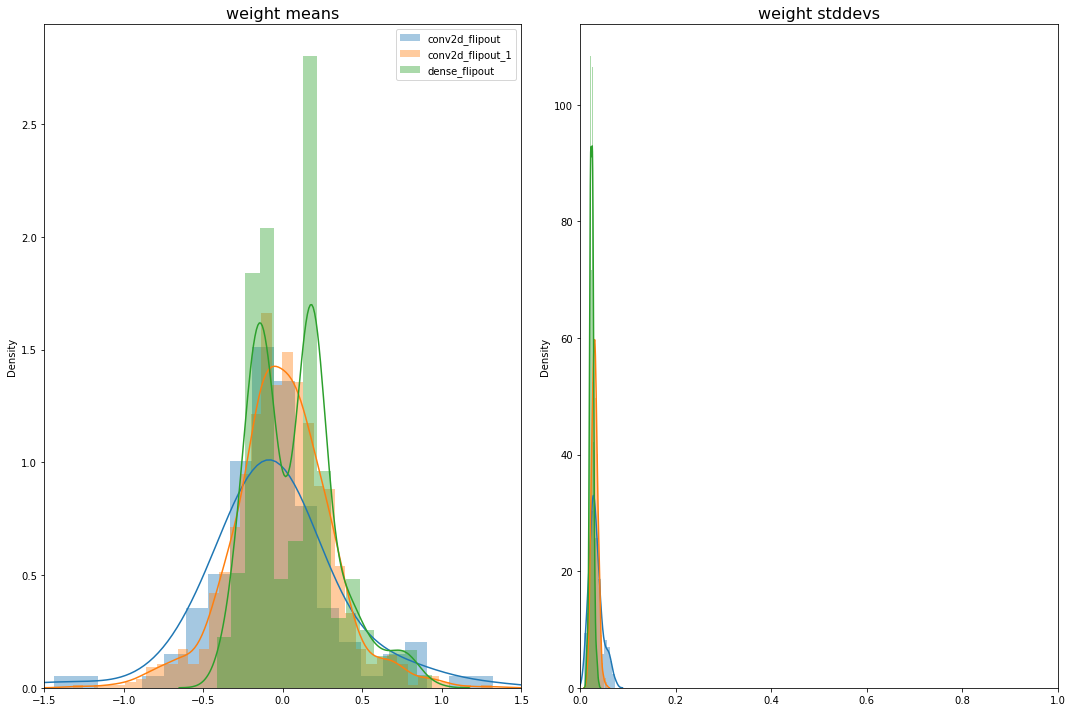

In [100]:
script.plot_qm_qs_vals(bnn_model= tuner_models[-2])

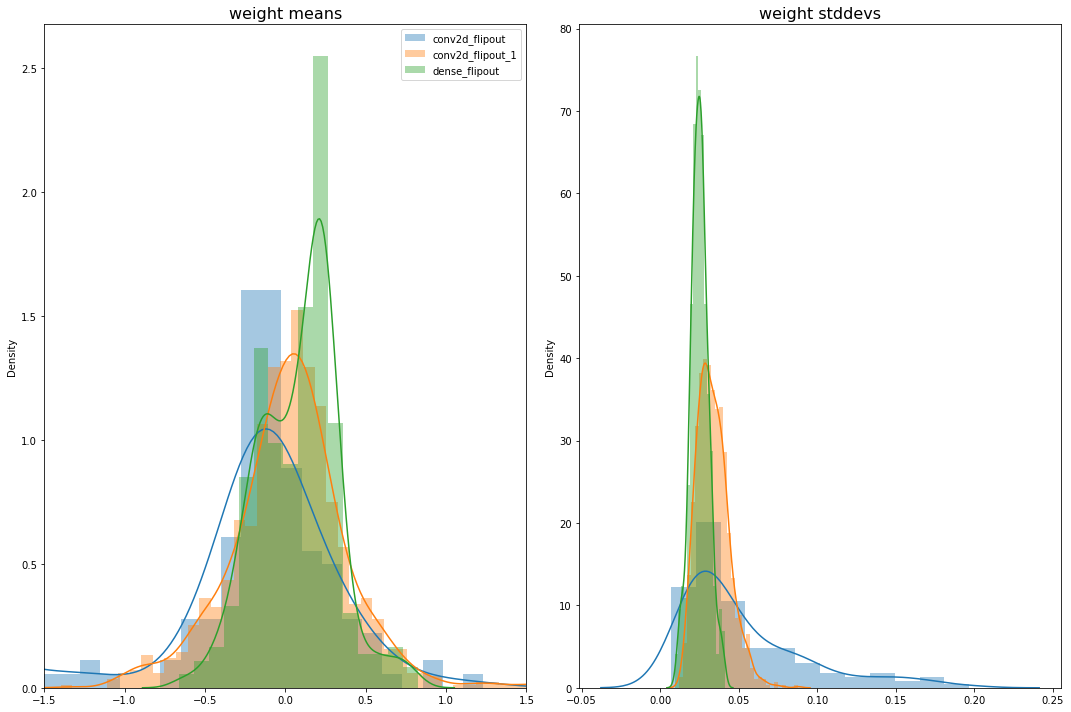

In [101]:
def plot_qm_qs_vals(bnn_model=tuner_models[-2]):
    
    names = [layer.name for layer in bnn_model.layers if "flipout" in layer.name]
    
    qm_vals = [
        layer.kernel_posterior.mean()
        for layer in bnn_model.layers
        if "flipout" in layer.name
    ]
    qs_vals = [
        layer.kernel_posterior.stddev()
        for layer in bnn_model.layers
        if "flipout" in layer.name
    ]


    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(1, 2, 1)
    for n, qm in zip(names, qm_vals):
        sns.distplot(tf.reshape(qm, shape=[-1]), ax=ax, label=n)
    ax.set_title("weight means",size = 16 )
    ax.set_xlim([-1.5, 1.5])
    ax.legend()
    ax = fig.add_subplot(1, 2, 2)
    for n, qs in zip(names, qs_vals):
        sns.distplot(tf.reshape(qs, shape=[-1]), ax=ax)
    ax.set_title("weight stddevs", size = 16)
    #ax.set_xlim([0, 1.0])
    fig.tight_layout()
    plt.show()
    
plot_qm_qs_vals(bnn_model=tuner_models[-1])

## Train Model Using Probabilistic Loss Function

This is the same architecture as above but instead train the model using a non-deterministic loss function and train it 6 times as long. This does extremely well as you can see in the one-to-one. I shuold try this with "elbo" loss function too. You can also compare the performance of the twoo models because they have a common metric "mse". In the model above "Score: 1.8561763763427734". In this model the "Score: 1.650"

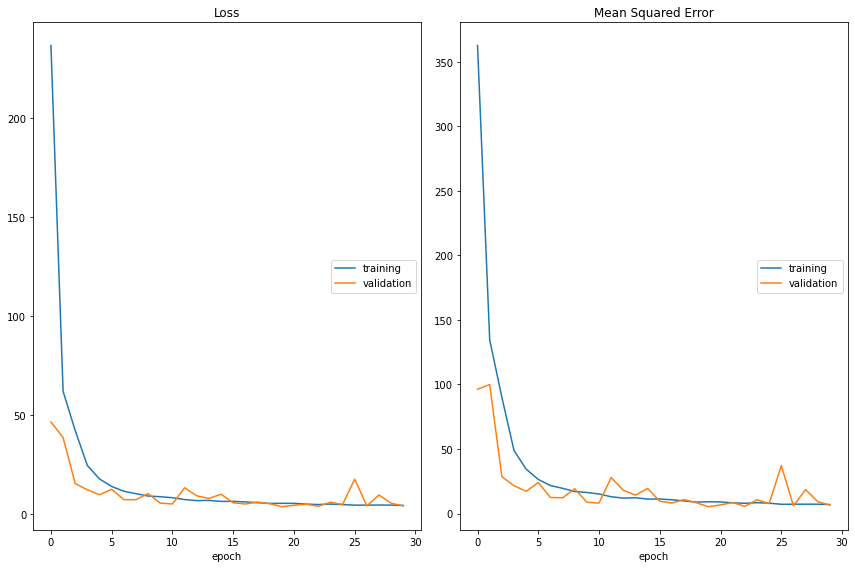

Loss
	training         	 (min:    4.414, max:  236.547, cur:    4.414)
	validation       	 (min:    3.753, max:   46.555, cur:    4.194)
Mean Squared Error
	training         	 (min:    7.023, max:  362.585, cur:    7.023)
	validation       	 (min:    5.305, max:   99.936, cur:    6.588)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout_2 (Conv2DFlip (None, 30, 30, 16)        304       
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 30, 16)        64        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_flipout_3 (Conv2DFlip (None, 15, 15, 8)         2312      
_________________________________________________________________
batch_normalization_3 (Batch (

In [102]:
def model3_ploss():

    # Making a model.
    model = Sequential()

    # Added Layers.
    model.add(tfp.layers.Convolution2DFlipout(filters = 16,
                                              input_shape=(nx, ny, 1), kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu'
                                              , padding = 'valid',
                                              ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(tfp.layers.Convolution2DFlipout(filters = 8,
                                              kernel_size=3, activation = 'relu',
                                              kernel_divergence_fn=kl_divergence_function,
                                              padding = 'same'
                                              ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(tfp.layers.DenseFlipout(1, activation="linear", kernel_divergence_fn=kl_divergence_function,))
    model.add(tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(loc=t[..., :1],
                             #scale = 1)))
                             scale=1e-3 + tf.math.softplus(0.01 * t[..., :1]))))

    model.compile(optimizer= "adam", loss = "neg_log_likelihood", metrics=["mse"])

    plotlosses = PlotLossesKeras()

    model.fit(X_train, y_train, validation_data=(X_test, y_test),
              epochs=HP_EPOCH, batch_size=HP_BATCH_SIZE,
              callbacks=[plotlosses],
              verbose=1)

    # Visualize Model
    print(model.summary())

    loss = model.evaluate(X_test, y_test)
    return model

                                                                                                                                                                                      
model = model3_ploss()



### Monte Carlo 

In [103]:
# make predictions  
pred_distLambda = script.mc_pred(bestmodel=model, X_test=X_test)

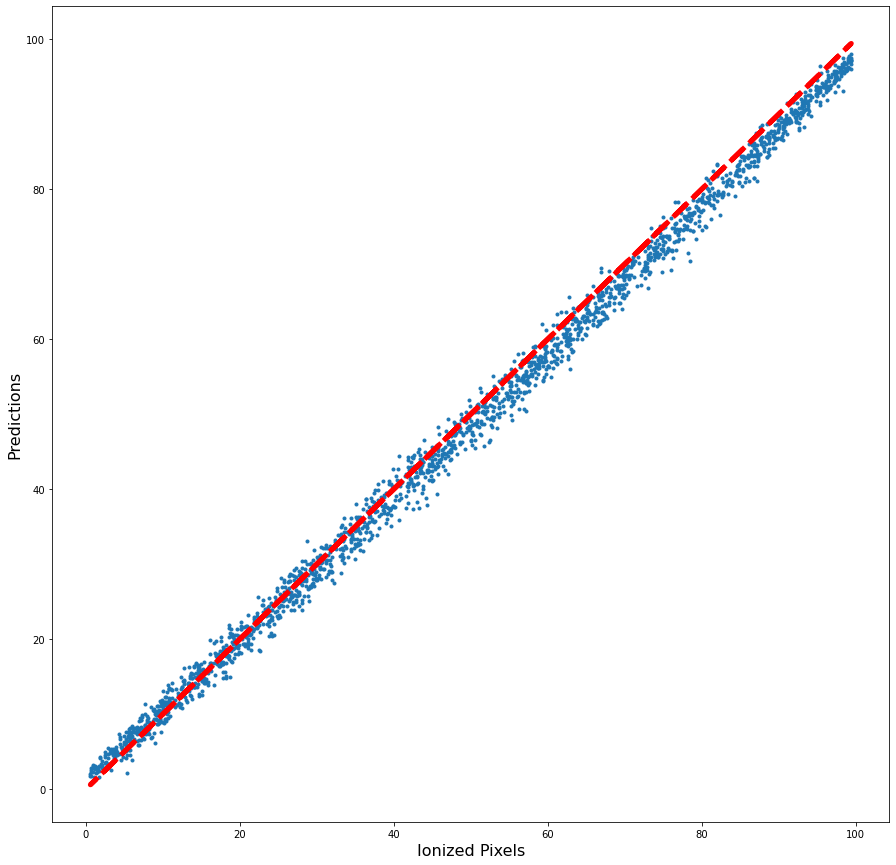

In [104]:
# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("")
plt.xlabel("Ionized Pixels", size = 16)
plt.ylabel("Predictions", size = 16)
plt.plot(y_test, np.mean(np.array(pred_distLambda), axis=0), '.')
plt.plot(y_test,y_test, "r--", linewidth=5)

These distibutions have fat tails too but they are closer to being centered at zero.

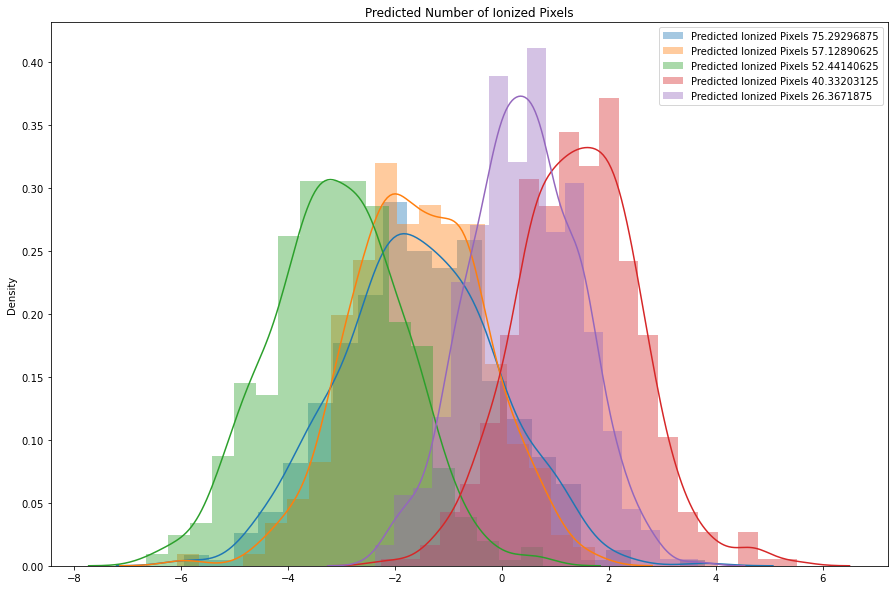

In [105]:
script.plot_pred_distribution(predictions= pred_distLambda, y_test= y_test)

### Plot the distribution of the predictions within a certain range.

No handles with labels found to put in legend.


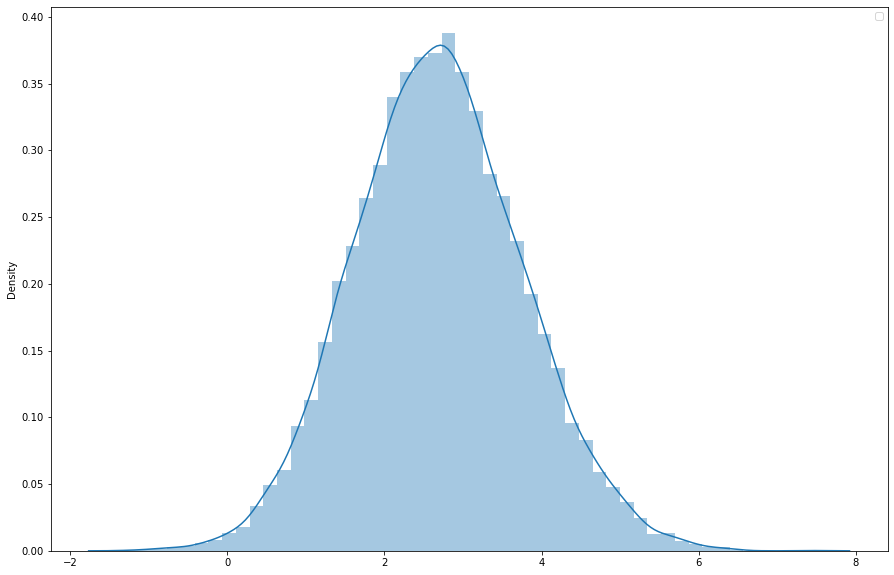

In [106]:
script.plot_pred_distribution_range(predictions=pred_distLambda, y_test=y_test, upper_lim=2, lower_lim=0)

No handles with labels found to put in legend.


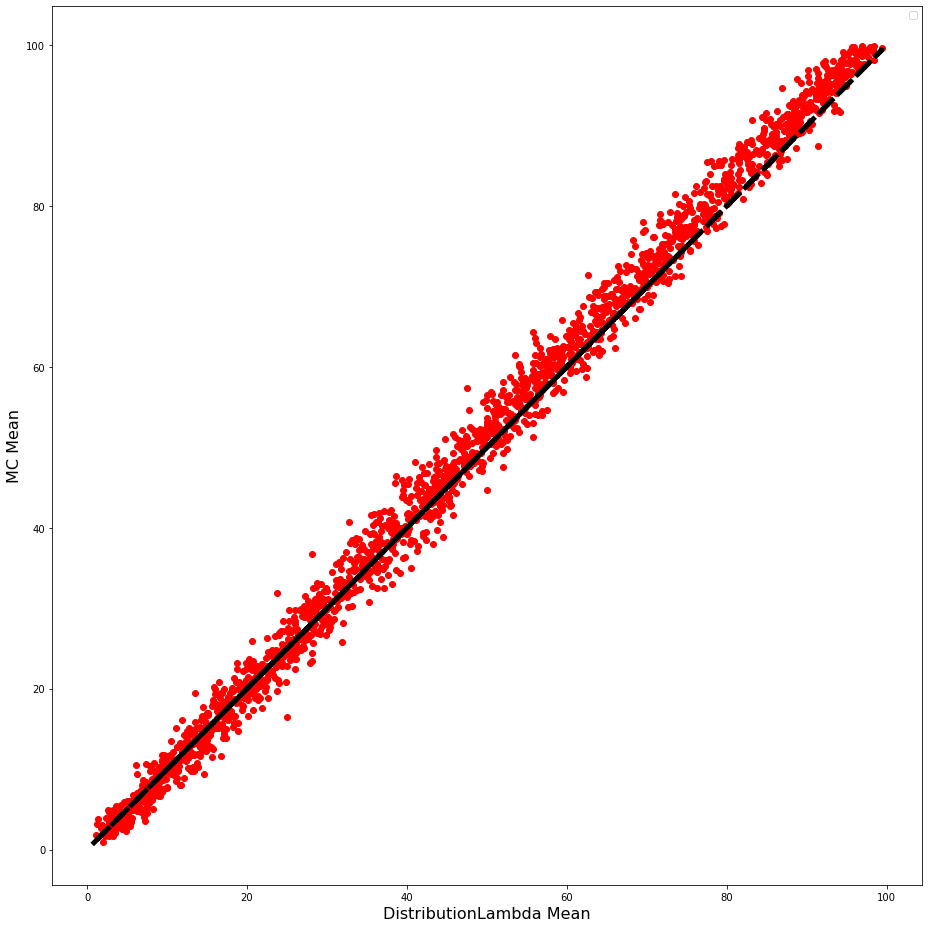

In [107]:
script.plot_compare_pred_values(yhat=model(X_test), predictions= pred, y_test= y_test)

... Very unclear what this shape means... I keep seeing it... idk...

No handles with labels found to put in legend.


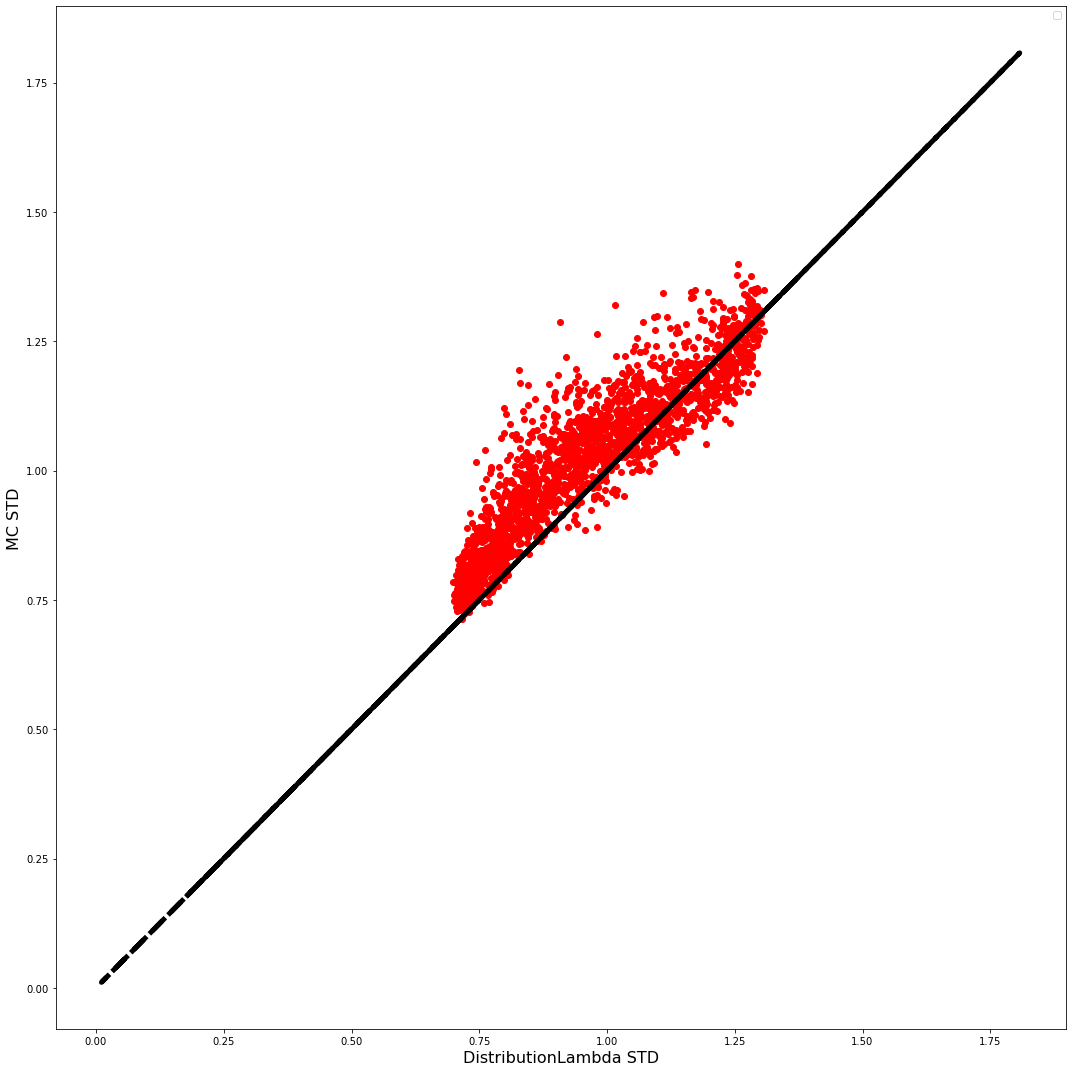

In [108]:
script.plot_compare_STDs(yhat=model(X_test), predictions= pred, y_test= y_test)

### Empirical Examination of Posterior Distribution

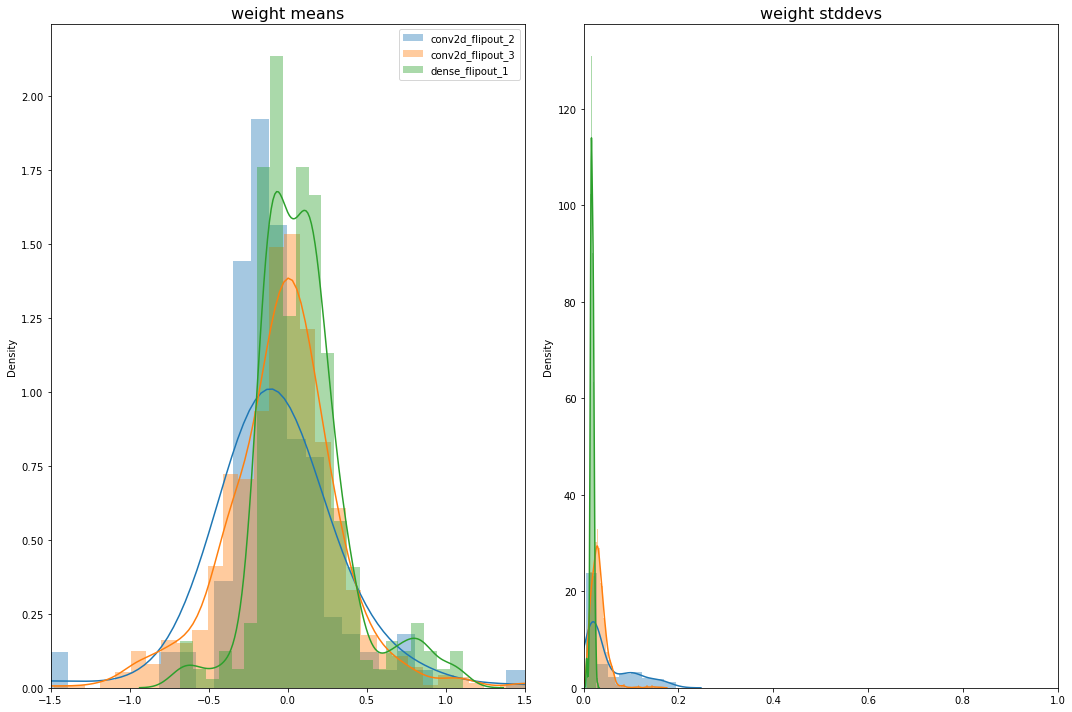

In [109]:
script.plot_qm_qs_vals(bnn_model= model)

## Learn STD and Mean

### Error Bars

METHOD 1:  Empirical error bars for the posterior using Monte Carlo  

METHOD 2: Sigma in output layer  

In [110]:
yhat = model(X_test) # model.predict(X_test)

MC predictions do really well here but what happens when we sample from the Lambda_distribution function?

Compare two prediction methods. MC sampling and Disttribution lambda are about the same so this is really good. MC can take a very long time so I guess this means in this case I don't need to use the MC sampling of the model.

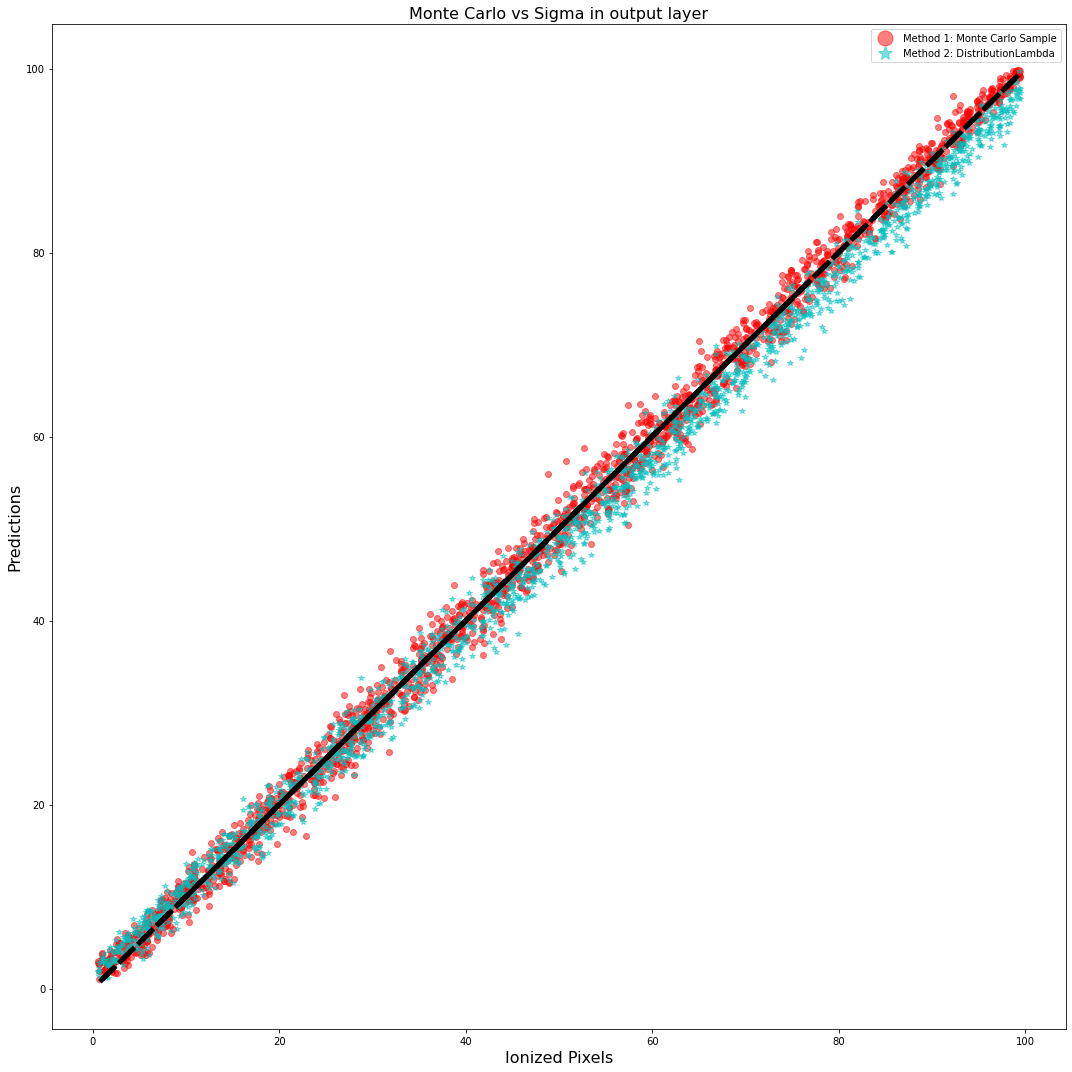

In [111]:
script.plot_one_to_one_pred_MC_DistributionLambda(yhat=model(X_test), predictions= pred, y_test= y_test)

We see some divergence as the number of ionized pixels increases. This is probably because I'm plotting the absolute error instead of the relative error. That could fix things maybe?

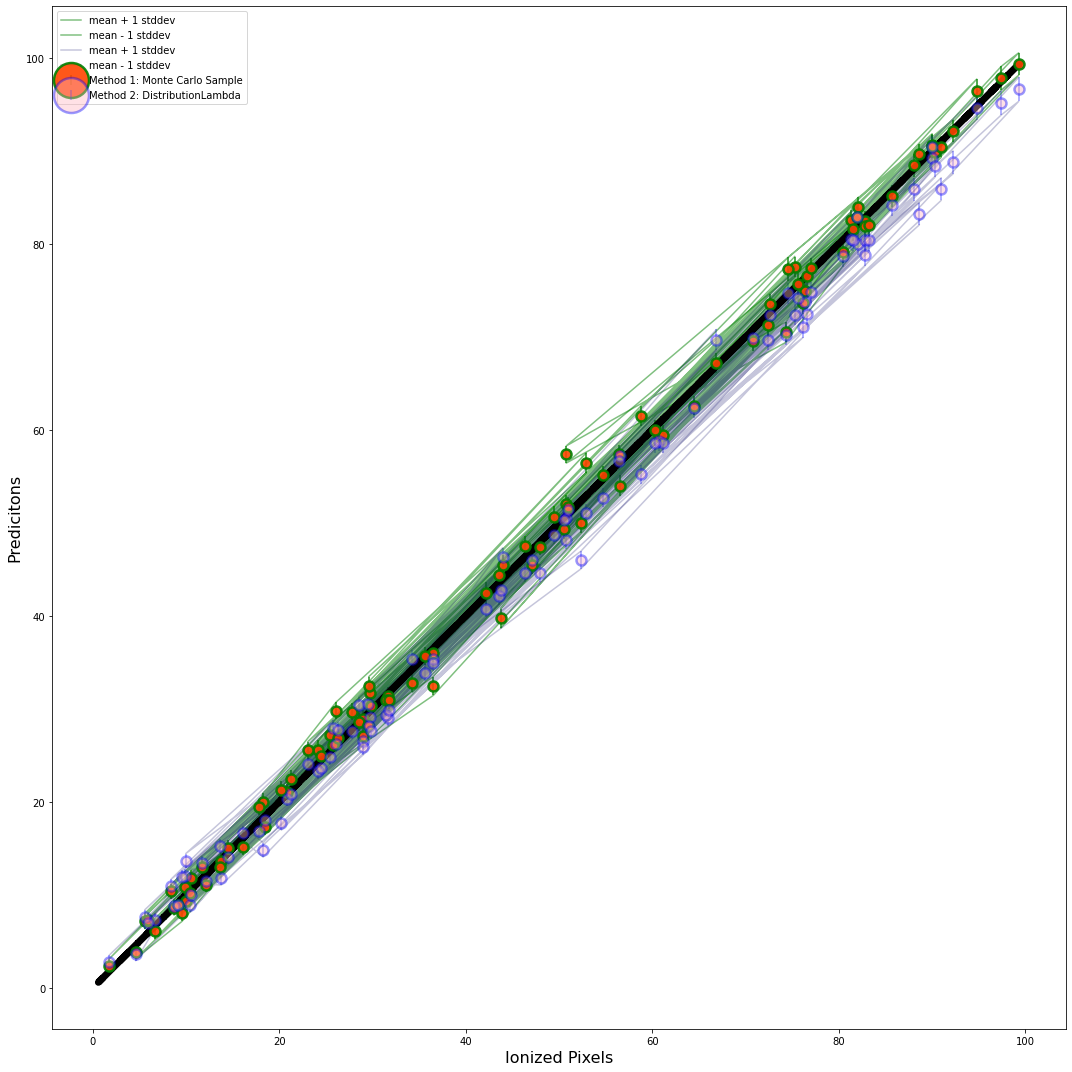

In [112]:
script.plot_error1(yhat=model(X_test), predictions= pred, y_test= y_test)

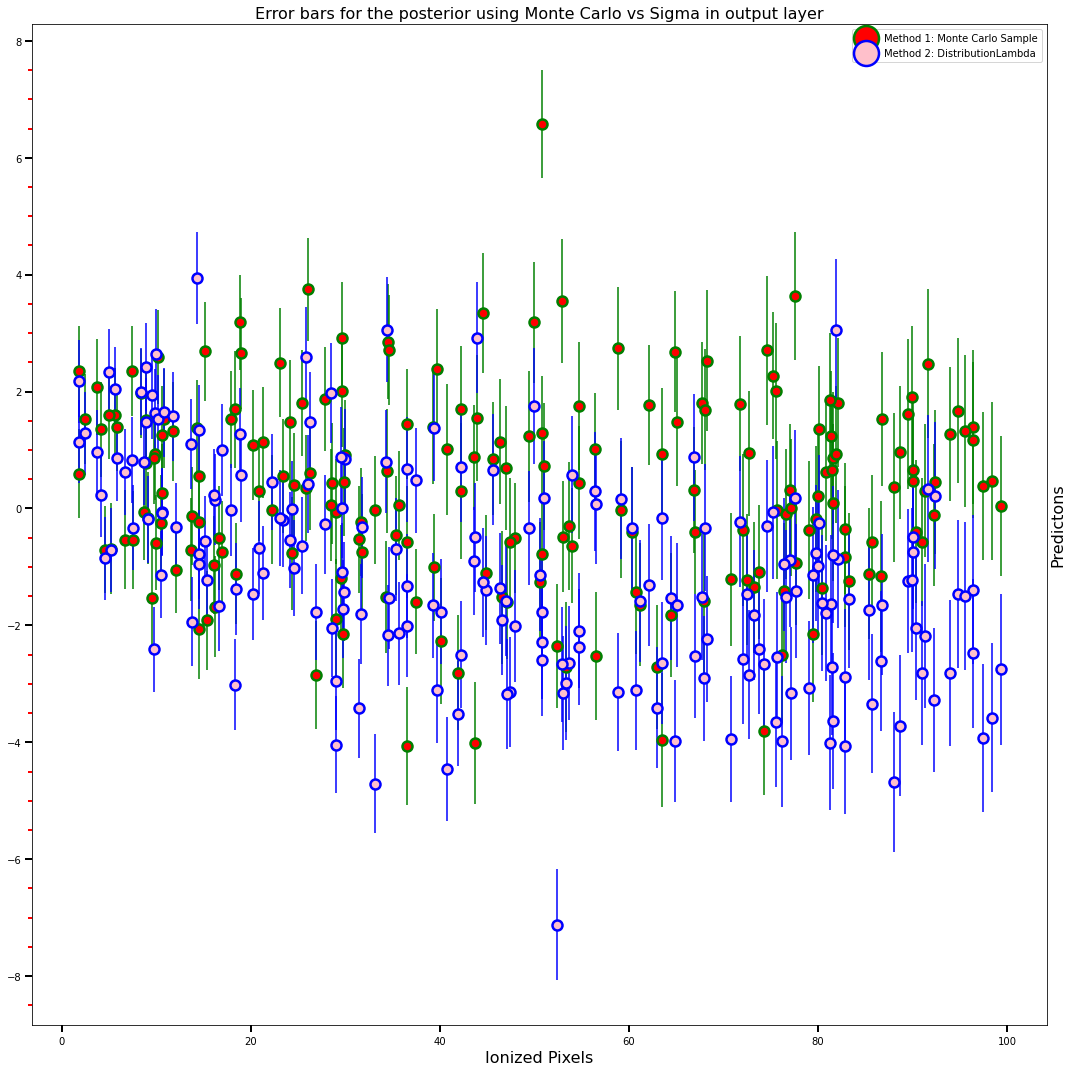

In [113]:
script.plot_error2(yhat=model(X_test), predictions= pred, y_test= y_test)

The variance of the predictions using the DistributionLambda method is approximately uniform

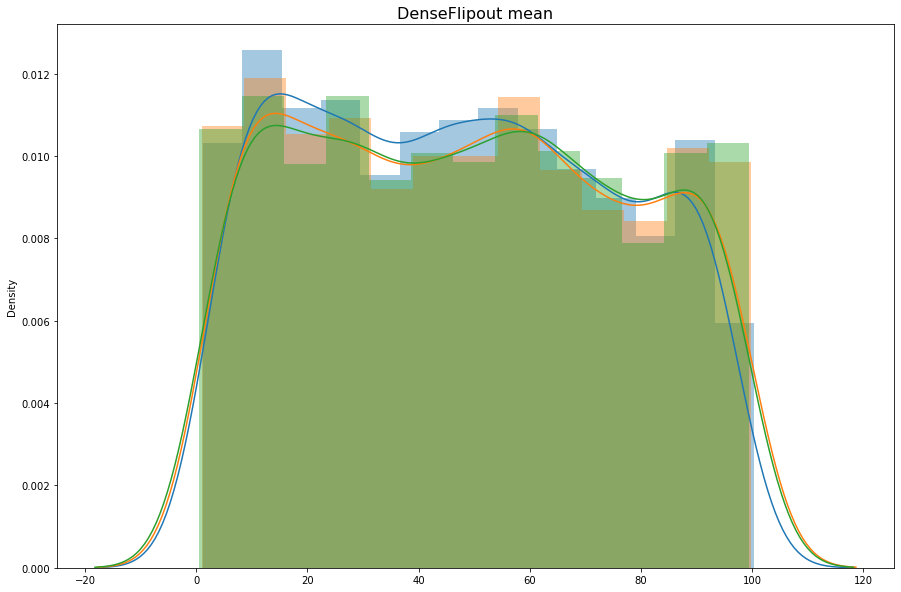

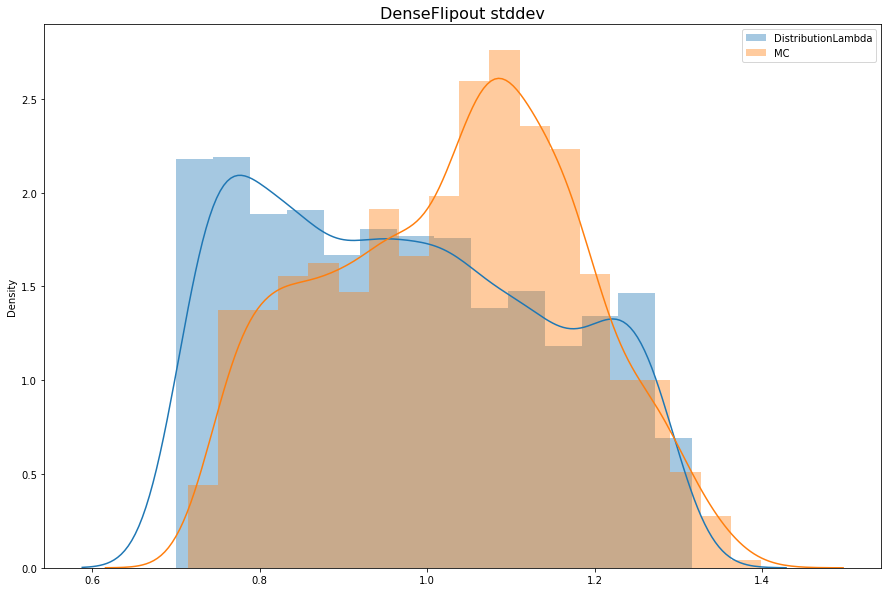

In [114]:
script.plot_distribution_mean_std(yhat=model(X_test), predictions= pred, y_test= y_test)

# Model 4

## Train Model Using Deterministic Loss Function



In [115]:
outputdir = ""
if os.path.isdir(project_name): # check to see if path exists
    os.system("rm -rvf {}".format(project_name))

def model4_dloss(hp):

    # Making a model.
    model = Sequential()

    # Added Layers.
    model.add(tfp.layers.Convolution2DFlipout(filters = 64,
                                              input_shape=(nx, ny, 1), kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu'
                                              , padding = 'valid',
                                              ))
    model.add(BatchNormalization())
    #model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(tfp.layers.Convolution2DFlipout(filters = 32, kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu'
                                              , padding = 'valid',
                                              ))
    model.add(BatchNormalization())
    #model.add(MaxPooling2D(pool_size=(2, 2)))
                          
    model.add(tfp.layers.Convolution2DFlipout(filters = 16, kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu'
                                              , padding = 'valid',
                                              ))
    model.add(BatchNormalization())
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(tfp.layers.Convolution2DFlipout(filters = 8, kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu'
                                              , padding = 'valid',
                                              ))
    model.add(BatchNormalization())
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(tfp.layers.Convolution2DFlipout(filters = 4, kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu'
                                              , padding = 'valid',
                                              ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(tfp.layers.DenseFlipout(1, activation="linear", kernel_divergence_fn=kl_divergence_function,))

    #for l in range(hp.Int('loss', 0, len(losses))):
    model.compile(optimizer= "adam", loss = hp.Choice('loss_type', ["mse", "mae", "mape", "Mean_Squared_over_true_Error"], ordered=False, default="mse"), metrics=["mse"])

    # Visualize Model
    print(model.summary())

    return model


In [116]:
# Random searrch through choices
tuner_models = script.random_search(model= model4_dloss,
                                    num_models= num_models,
                                    outputdir= outputdir,
                                    project_name= project_name,
                                    X_train= X_train, 
                                    y_train= y_train,
                                    X_test= X_test, 
                                    y_test= y_test,
                                    epochs= HP_EPOCH,
                                    HP_BATCH_SIZE=HP_BATCH_SIZE,
                                   )


Trial 4 Complete [00h 39m 09s]
val_loss: 5.1431097984313965

Best val_loss So Far: 0.43279048800468445
Total elapsed time: 02h 30m 50s
INFO:tensorflow:Oracle triggered exit
--------------------------------------------------
Tuning Summary
--------------------------------------------------
Results summary
Results in ./toy_model_tuner_32
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
loss_type: Mean_Squared_over_true_Error
Score: 0.43279048800468445
Trial summary
Hyperparameters:
loss_type: mae
Score: 5.1431097984313965
Trial summary
Hyperparameters:
loss_type: mse
Score: 11.273423194885254
Trial summary
Hyperparameters:
loss_type: mape
Score: 13.478673934936523
Search space summary
Default search space size: 1
loss_type (Choice)
{'default': 'mse', 'conditions': [], 'values': ['mse', 'mae', 'mape', 'Mean_Squared_over_true_Error'], 'ordered': False}
Model: "sequential"
_________________________________________________________________
Laye

In [117]:
# print best performing model's loss function
tuner_models[0].loss

'Mean_Squared_over_true_Error'

In [118]:
# returns a list of model
tuner_models

In [119]:
# List of losses: the quantity that a model should seek to minimize during training.
tuner_models[0].losses

[<tf.Tensor 'conv2d_flipout/divergence_kernel:0' shape=() dtype=float32>,
 <tf.Tensor 'conv2d_flipout_1/divergence_kernel:0' shape=() dtype=float32>,
 <tf.Tensor 'conv2d_flipout_2/divergence_kernel:0' shape=() dtype=float32>,
 <tf.Tensor 'conv2d_flipout_3/divergence_kernel:0' shape=() dtype=float32>,
 <tf.Tensor 'conv2d_flipout_4/divergence_kernel:0' shape=() dtype=float32>,
 <tf.Tensor 'dense_flipout/divergence_kernel:0' shape=() dtype=float32>]

### Monte Carlo 

Use Monte Carlo sampling of the models and average the predicted predictions to get the predicted values and make one-to-one plot. In the plot below I compare the models and then from there it's clear who doesn't do well at all (blue line). Obvisouly, if I trained the model for a longer time then I would expect it to improve the other predictions but this is good enough. 

In [120]:
# make list of predictions using all of the model
predictions = script.mc_pred_tuner_models(tuner_models=tuner_models, X_test=X_test)

(2000, 32, 32, 1)
(5, 2000)


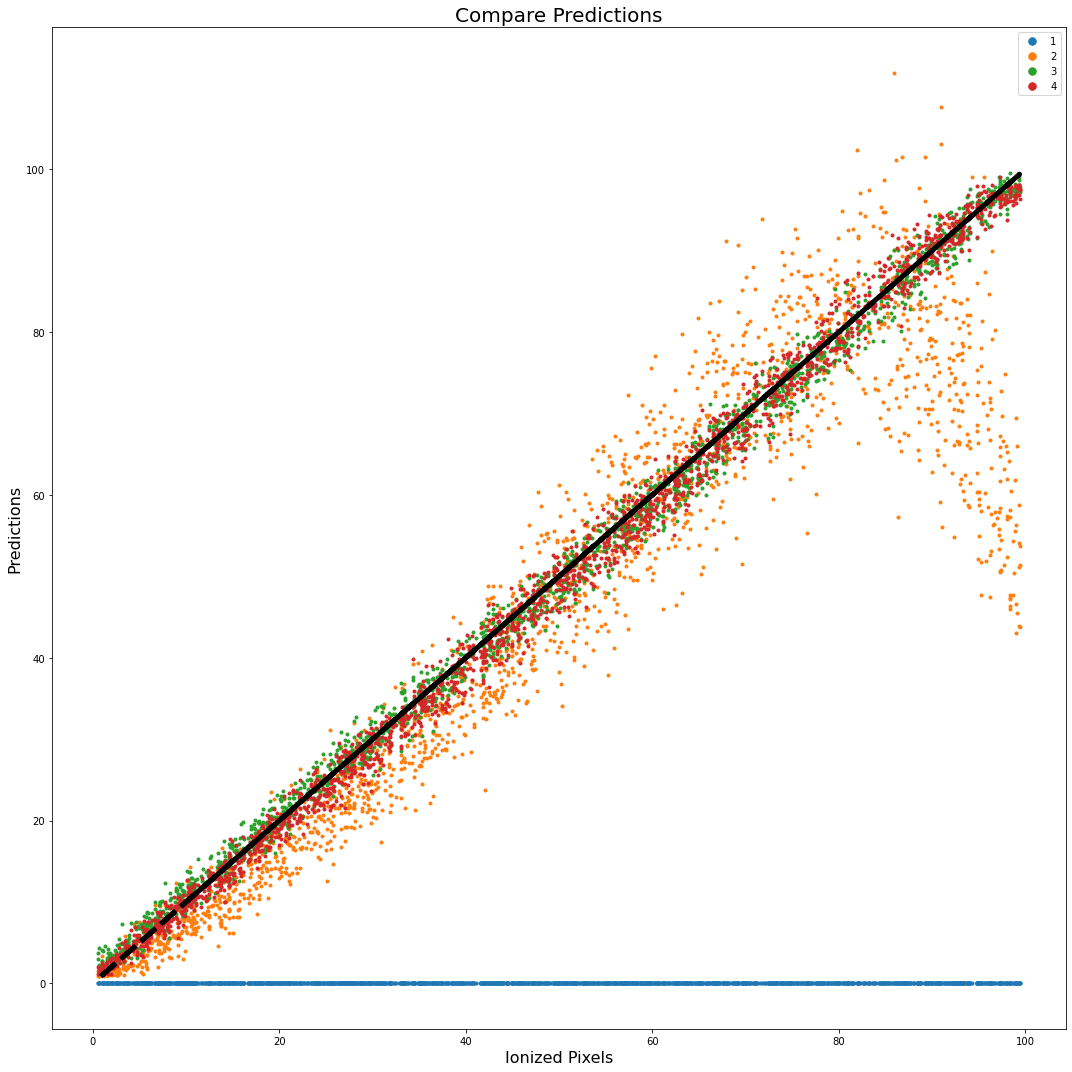

In [121]:
script.plot_one_to_one_pred(tuner_models= tuner_models, y_test= y_test, predictions=predictions)

In [122]:
predictions.shape

(5, 2000)

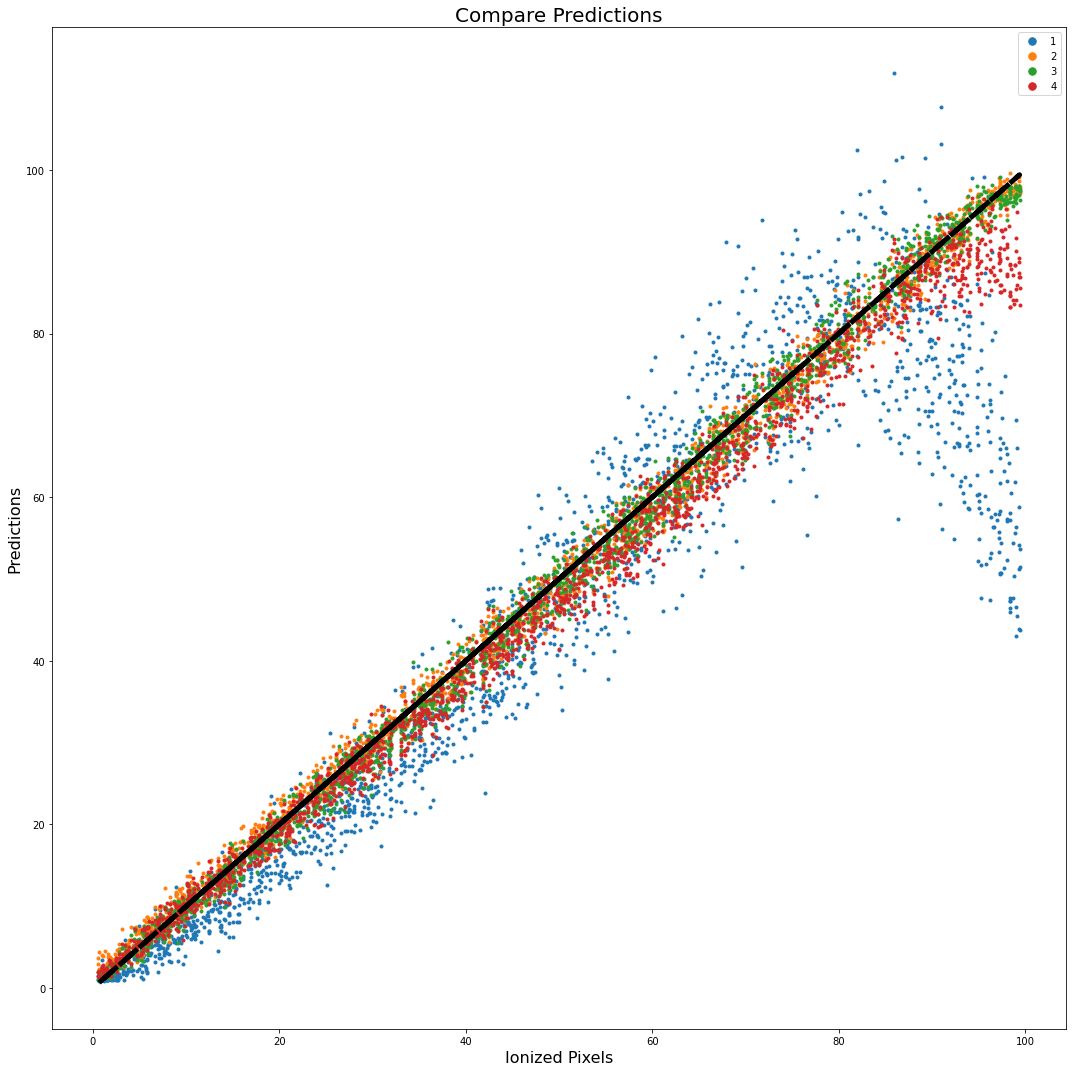

In [123]:
script.plot_one_to_one_pred(tuner_models= tuner_models, y_test= y_test, predictions=predictions[1:,:])

In [124]:
tuner_models[-2].loss

'mse'

In [125]:
# make list of predictions using the best model
pred = script.mc_pred(bestmodel=tuner_models[-2], X_test=X_test)

In the plot below I look at a subset of predicted ionized pixel values. I would have selected any range but I chose 0-2. Well, the good thing is that it looks like the model doesn't try to guess values less than 0... That would make no sense. We do see multiple peaks. More than two peaks is no longer a bimodal distribution. It's a Multimidal distribution and would also represent multiple local maximums; these are points where the data points stop increasing and start decreasing.  

https://www.statisticshowto.com/what-is-a-bimodal-distribution/

No handles with labels found to put in legend.


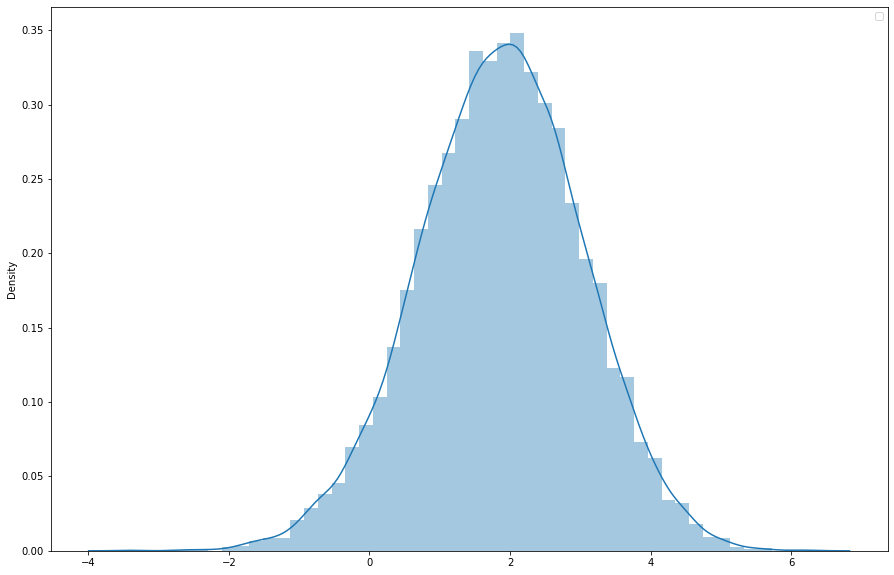

In [126]:
script.plot_pred_distribution_range(predictions=pred, y_test=y_test, upper_lim=2, lower_lim=0)

Ideally we would want this distribution to be centred at zero because we are looking at the distribution of the difference between the pred and the true value. There is clearly some presence of divergence the distribution. I can't see much skewed behavior but I do see the presenece of kurtosis (positive and negative).  Some of thee distributions have pretty fat tails too.

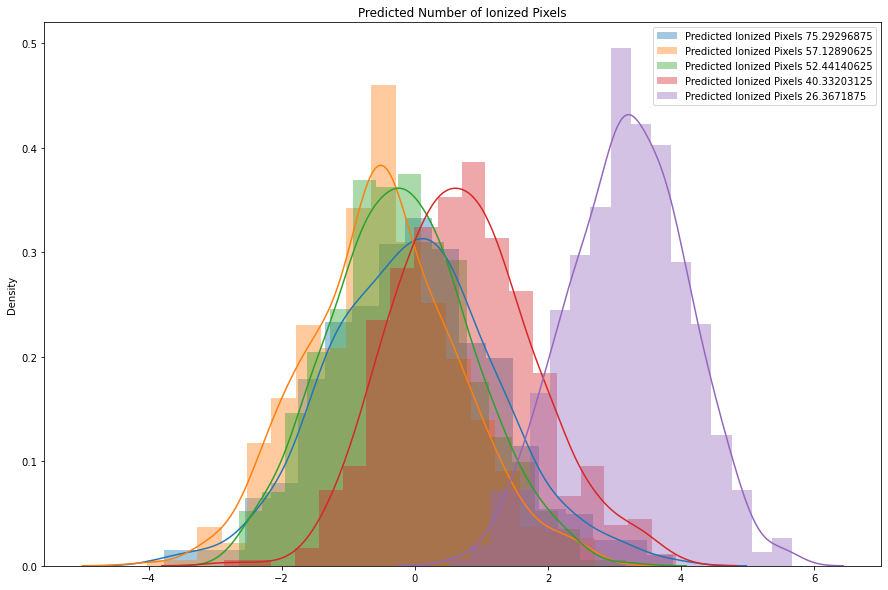

In [127]:
script.plot_pred_distribution(predictions= pred, y_test= y_test)

### Empirical Examination of Posterior Distribution

Looks like the std of the weights areen't negative... Good. There are very clear double peaks (bimodal distirbution?).  

Weight distribution says something interesting I think. Going from the 1st convolution layer to the second more weights are zero. So, they aren't important when looking at this data.

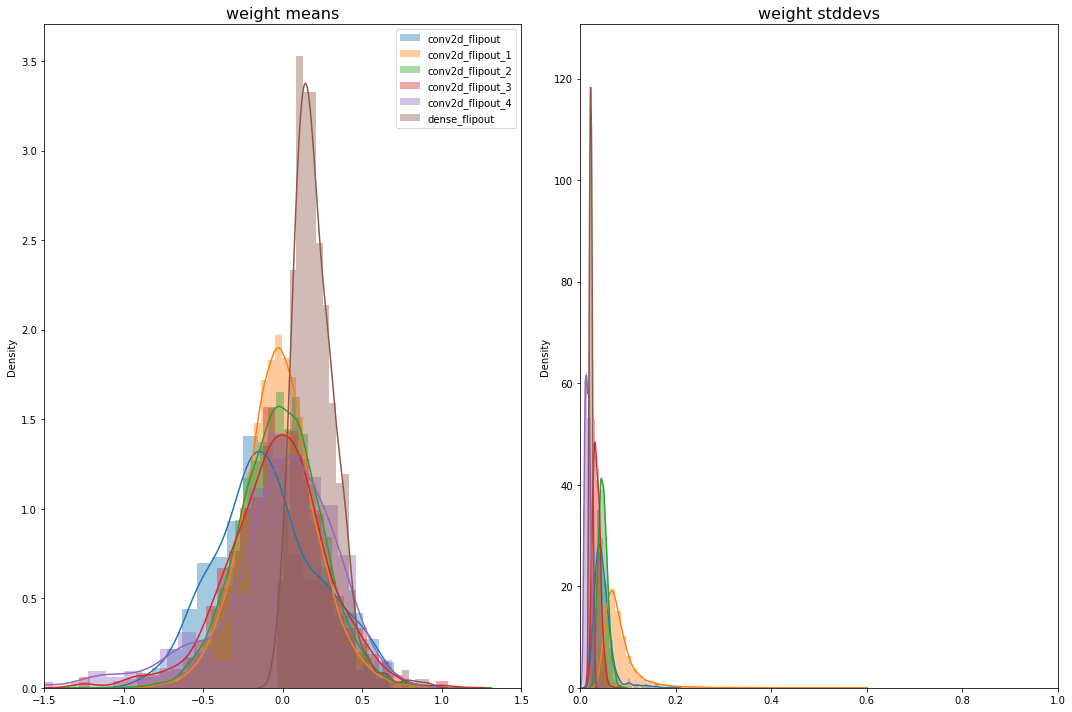

In [128]:
script.plot_qm_qs_vals(bnn_model= tuner_models[-2])

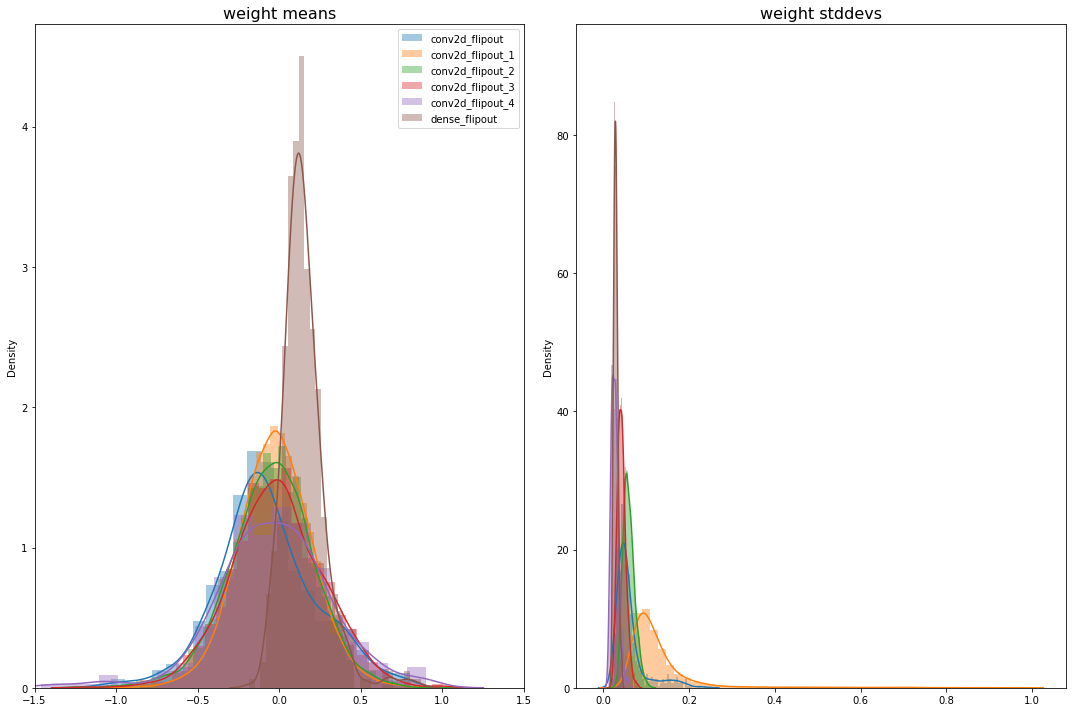

In [129]:
def plot_qm_qs_vals(bnn_model=tuner_models[-2]):
    
    names = [layer.name for layer in bnn_model.layers if "flipout" in layer.name]
    
    qm_vals = [
        layer.kernel_posterior.mean()
        for layer in bnn_model.layers
        if "flipout" in layer.name
    ]
    qs_vals = [
        layer.kernel_posterior.stddev()
        for layer in bnn_model.layers
        if "flipout" in layer.name
    ]


    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(1, 2, 1)
    for n, qm in zip(names, qm_vals):
        sns.distplot(tf.reshape(qm, shape=[-1]), ax=ax, label=n)
    ax.set_title("weight means",size = 16 )
    ax.set_xlim([-1.5, 1.5])
    ax.legend()
    ax = fig.add_subplot(1, 2, 2)
    for n, qs in zip(names, qs_vals):
        sns.distplot(tf.reshape(qs, shape=[-1]), ax=ax)
    ax.set_title("weight stddevs", size = 16)
    #ax.set_xlim([0, 1.0])
    fig.tight_layout()
    plt.show()
    
plot_qm_qs_vals(bnn_model=tuner_models[-1])

## Train Model Using Probabilistic Loss Function

This is the same architecture as above but instead train the model using a non-deterministic loss function and train it 6 times as long. This does extremely well as you can see in the one-to-one. I shuold try this with "elbo" loss function too. You can also compare the performance of the twoo models because they have a common metric "mse". In the model above "Score: 1.8561763763427734". In this model the "Score: 1.650"

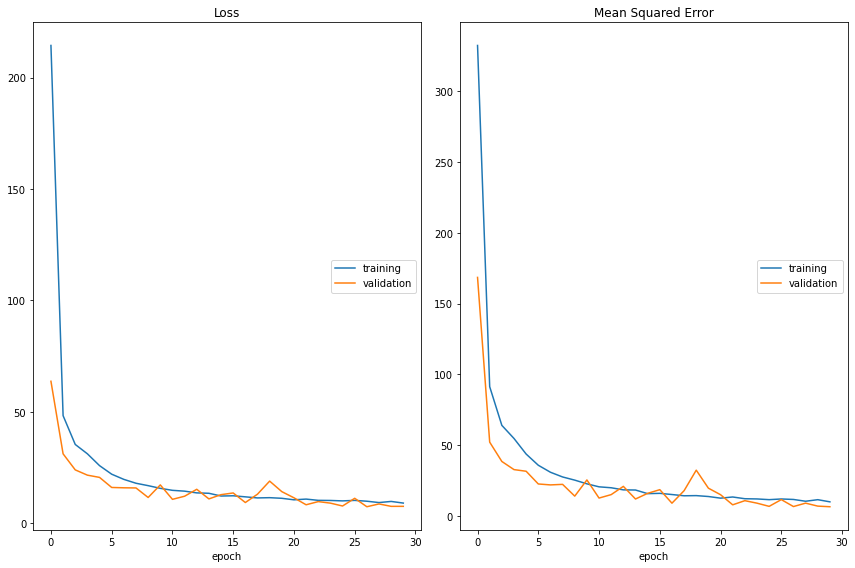

Loss
	training         	 (min:    9.078, max:  214.406, cur:    9.078)
	validation       	 (min:    7.434, max:   63.733, cur:    7.612)
Mean Squared Error
	training         	 (min:    9.921, max:  332.424, cur:    9.921)
	validation       	 (min:    6.459, max:  168.517, cur:    6.459)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout_5 (Conv2DFlip (None, 30, 30, 32)        608       
_________________________________________________________________
batch_normalization_5 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_flipout_6 (Conv2DFlip (None, 28, 28, 32)        18464     
_________________________________________________________________
batch_normalization_6 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_flipout_7 (Conv2DFlip (

In [130]:
def model4_ploss():

    # Making a model.
    model = Sequential()

    # Added Layers.
    model.add(tfp.layers.Convolution2DFlipout(filters = 32,
                                              input_shape=(nx, ny, 1), kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu'
                                              , padding = 'valid',
                                              ))
    model.add(BatchNormalization())
    #model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(tfp.layers.Convolution2DFlipout(filters = 32, kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu'
                                              , padding = 'valid',
                                              ))
    model.add(BatchNormalization())
    #model.add(MaxPooling2D(pool_size=(2, 2)))
                          
    model.add(tfp.layers.Convolution2DFlipout(filters = 16, kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu'
                                              , padding = 'valid',
                                              ))
    model.add(BatchNormalization())
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(tfp.layers.Convolution2DFlipout(filters = 8, kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu'
                                              , padding = 'valid',
                                              ))
    model.add(BatchNormalization())
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(tfp.layers.Convolution2DFlipout(filters = 4, kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu'
                                              , padding = 'valid',
                                              ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(tfp.layers.DenseFlipout(1, activation="linear", kernel_divergence_fn=kl_divergence_function,))
    model.add(tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(loc=t[..., :1],
                             #scale = 1)))
                             scale=1e-3 + tf.math.softplus(0.01 * t[..., :1]))))

    model.compile(optimizer= "adam", loss = "neg_log_likelihood", metrics=["mse"])

    plotlosses = PlotLossesKeras()

    model.fit(X_train, y_train, validation_data=(X_test, y_test),
              epochs=HP_EPOCH, batch_size=HP_BATCH_SIZE,
              callbacks=[plotlosses],
              verbose=1)

    # Visualize Model
    print(model.summary())

    loss = model.evaluate(X_test, y_test)
    return model
                                                                                                                                                                                      
model = model4_ploss()



### Monte Carlo 

In [131]:
# make predictions  
pred_distLambda = script.mc_pred(bestmodel=model, X_test=X_test)

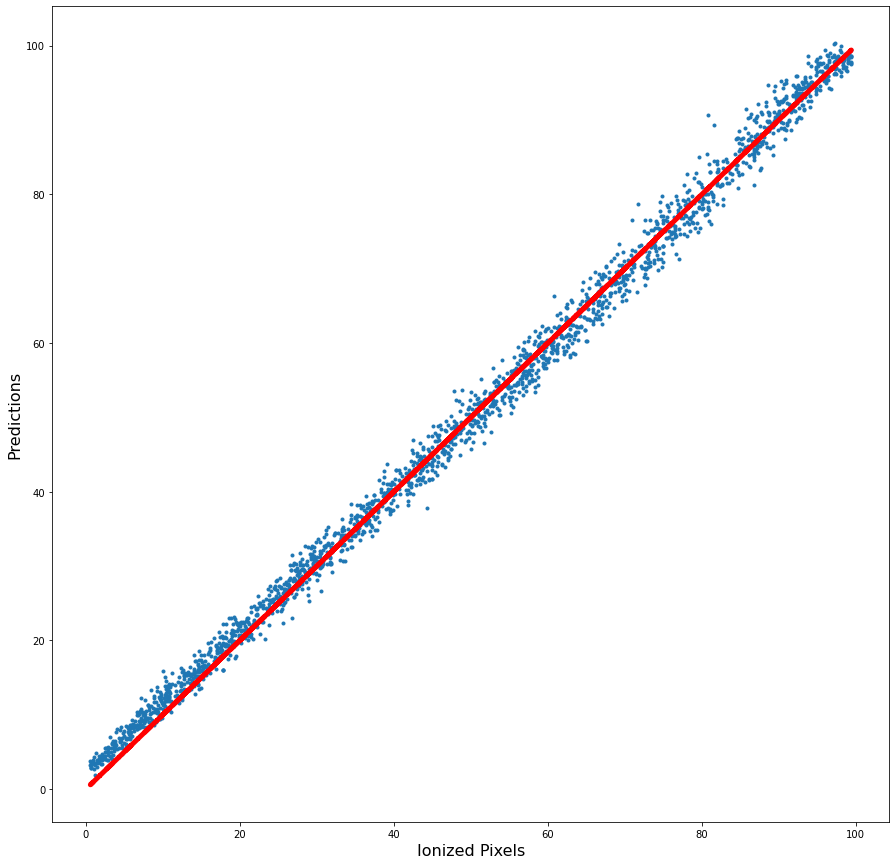

In [132]:
# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("")
plt.xlabel("Ionized Pixels", size = 16)
plt.ylabel("Predictions", size = 16)
plt.plot(y_test, np.mean(np.array(pred_distLambda), axis=0), '.')
plt.plot(y_test,y_test, "r--", linewidth=5)

These distibutions have fat tails too but they are closer to being centered at zero.

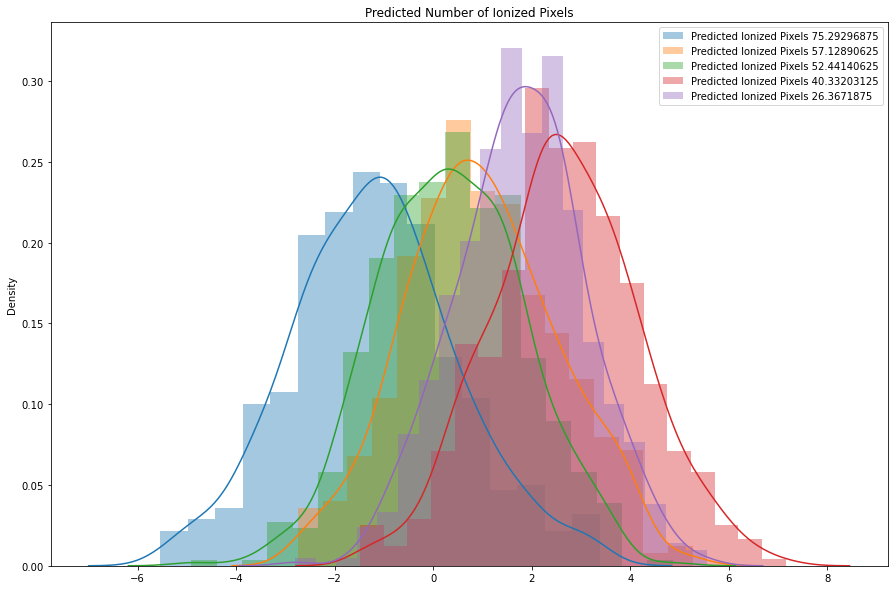

In [133]:
script.plot_pred_distribution(predictions= pred_distLambda, y_test= y_test)

### Plot the distribution of the predictions within a certain range.

No handles with labels found to put in legend.


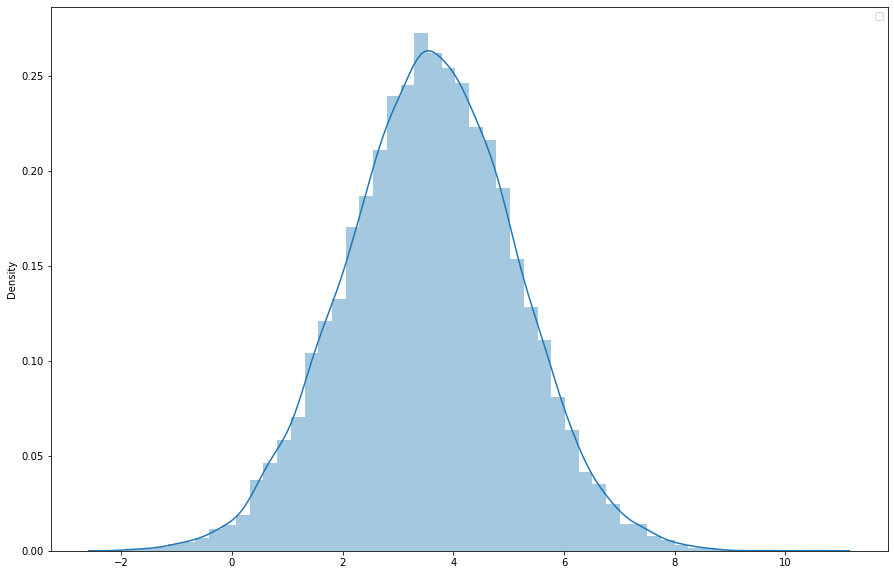

In [134]:
script.plot_pred_distribution_range(predictions=pred_distLambda, y_test=y_test, upper_lim=2, lower_lim=0)

No handles with labels found to put in legend.


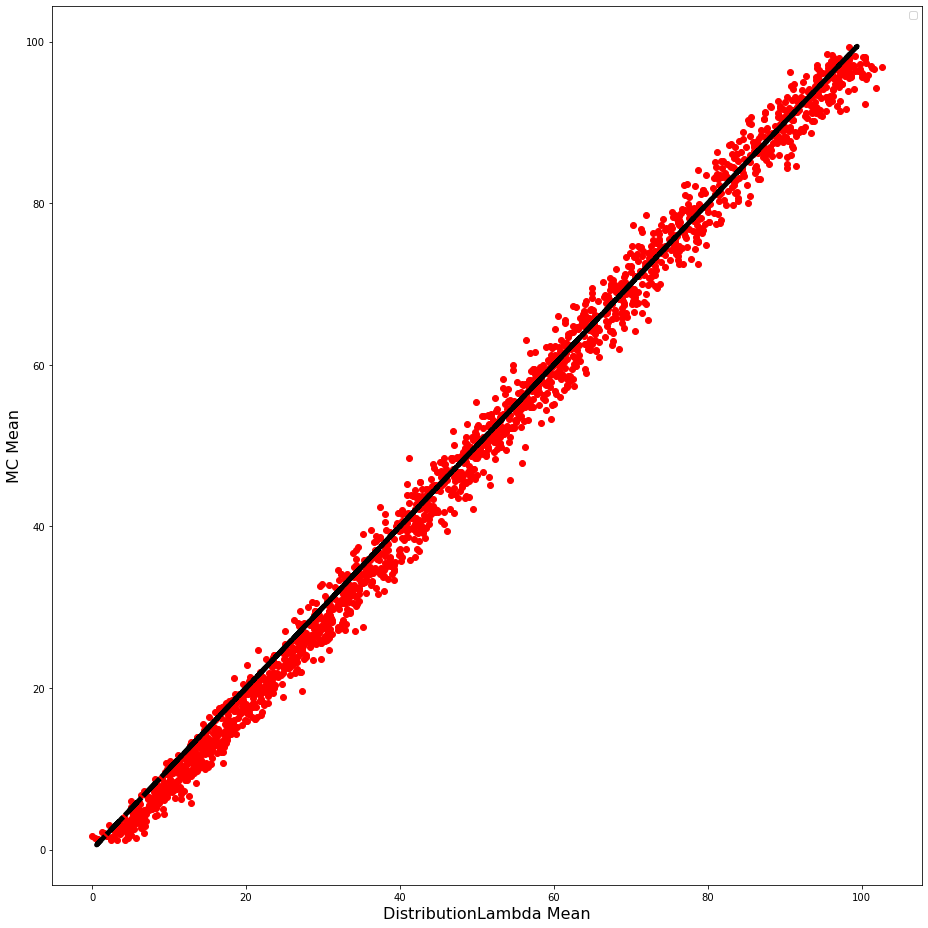

In [135]:
script.plot_compare_pred_values(yhat=model(X_test), predictions= pred, y_test= y_test)

... Very unclear what this shape means... I keep seeing it... idk...

No handles with labels found to put in legend.


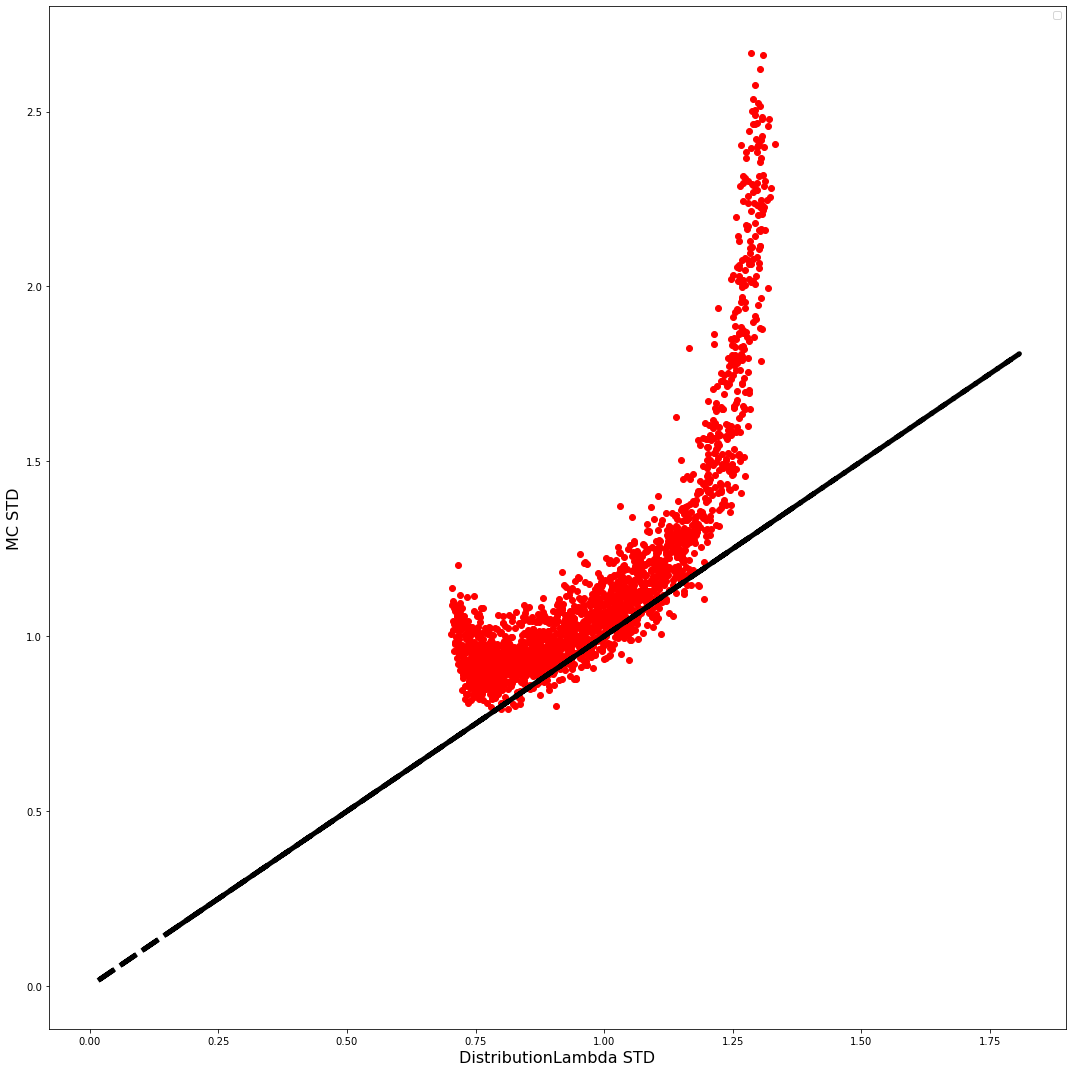

In [136]:
script.plot_compare_STDs(yhat=model(X_test), predictions= pred, y_test= y_test)

### Empirical Examination of Posterior Distribution

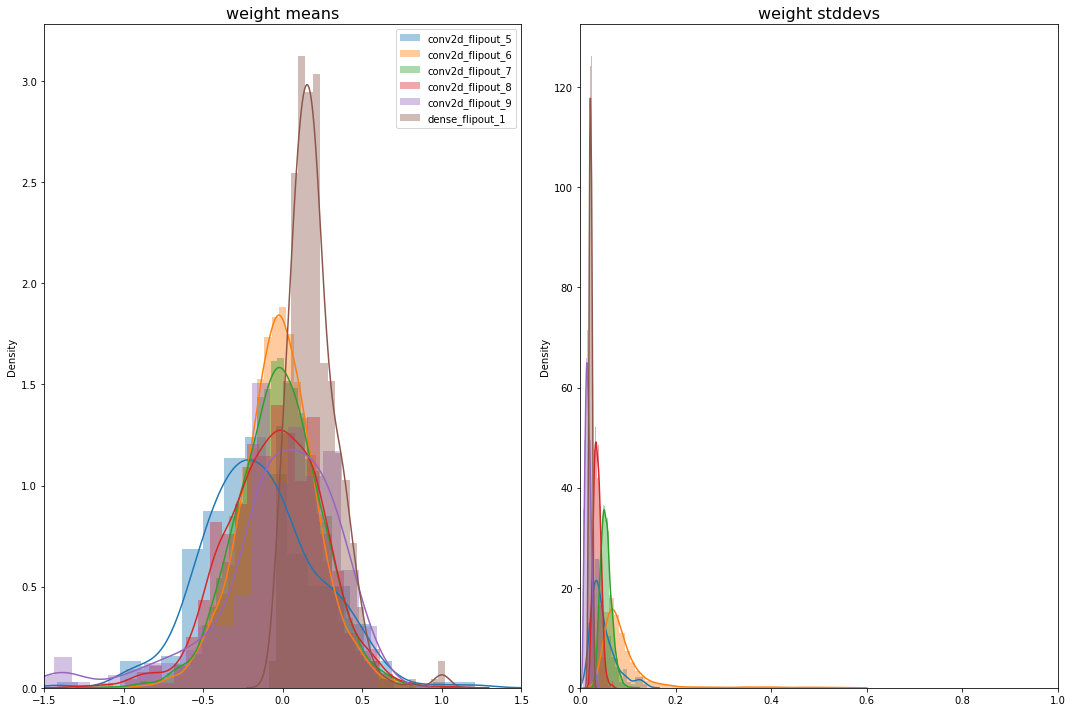

In [137]:
script.plot_qm_qs_vals(bnn_model= model)

## Learn STD and Mean

### Error Bars

METHOD 1:  Empirical error bars for the posterior using Monte Carlo  

METHOD 2: Sigma in output layer  

In [138]:
yhat = model(X_test) # model.predict(X_test)

MC predictions do really well here but what happens when we sample from the Lambda_distribution function?

Compare two prediction methods. MC sampling and Disttribution lambda are about the same so this is really good. MC can take a very long time so I guess this means in this case I don't need to use the MC sampling of the model.

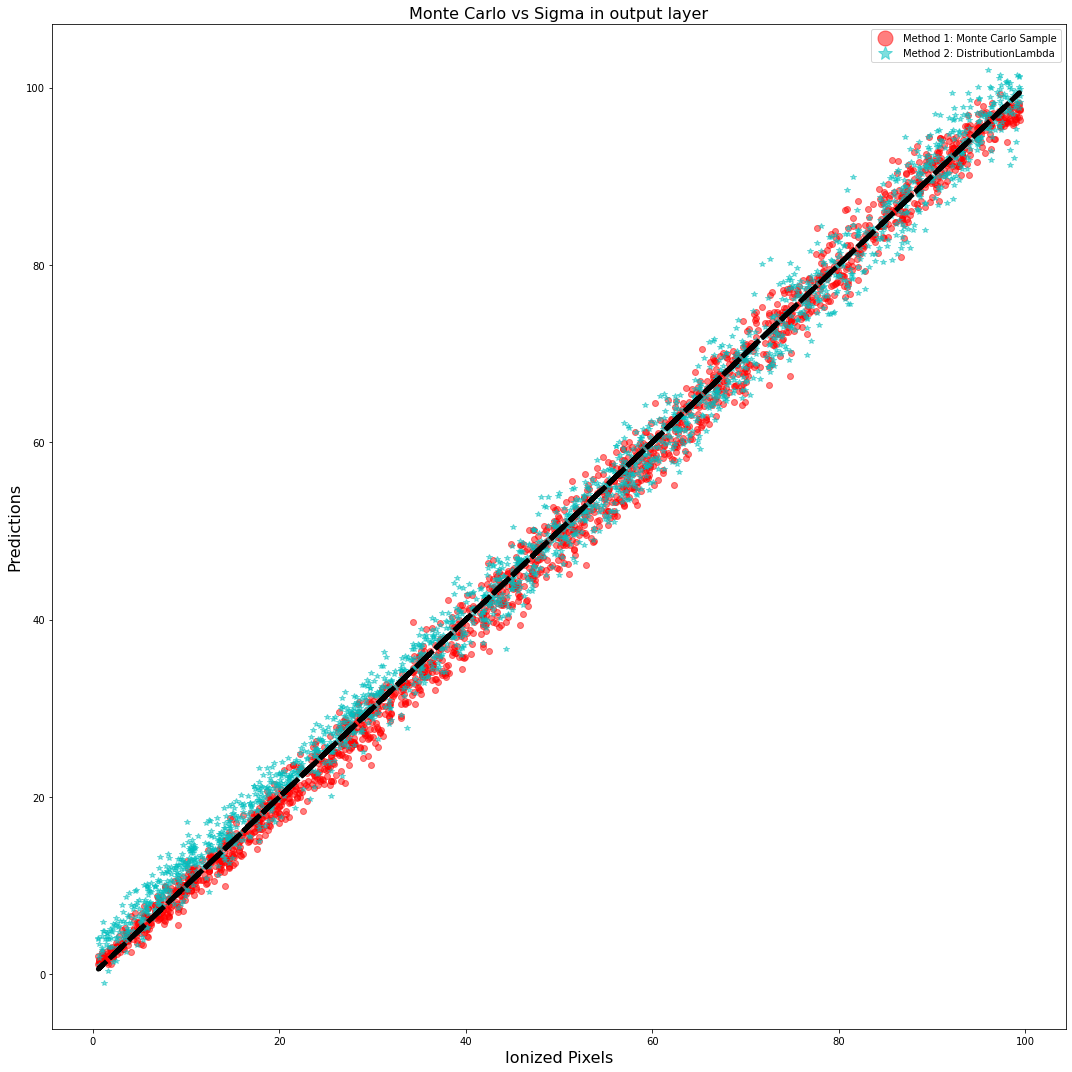

In [139]:
script.plot_one_to_one_pred_MC_DistributionLambda(yhat=model(X_test), predictions= pred, y_test= y_test)

We see some divergence as the number of ionized pixels increases. This is probably because I'm plotting the absolute error instead of the relative error. That could fix things maybe?

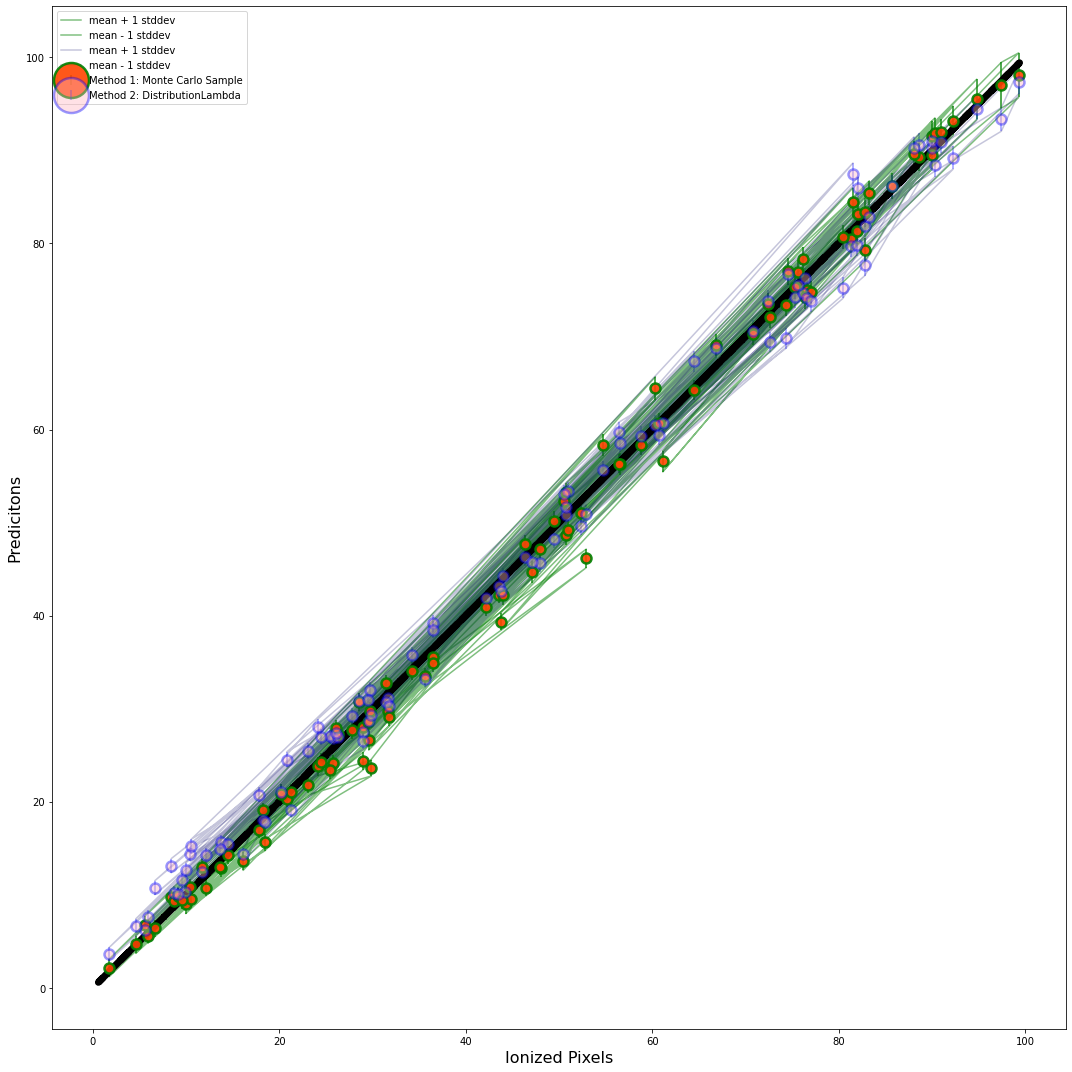

In [140]:
script.plot_error1(yhat=model(X_test), predictions= pred, y_test= y_test)

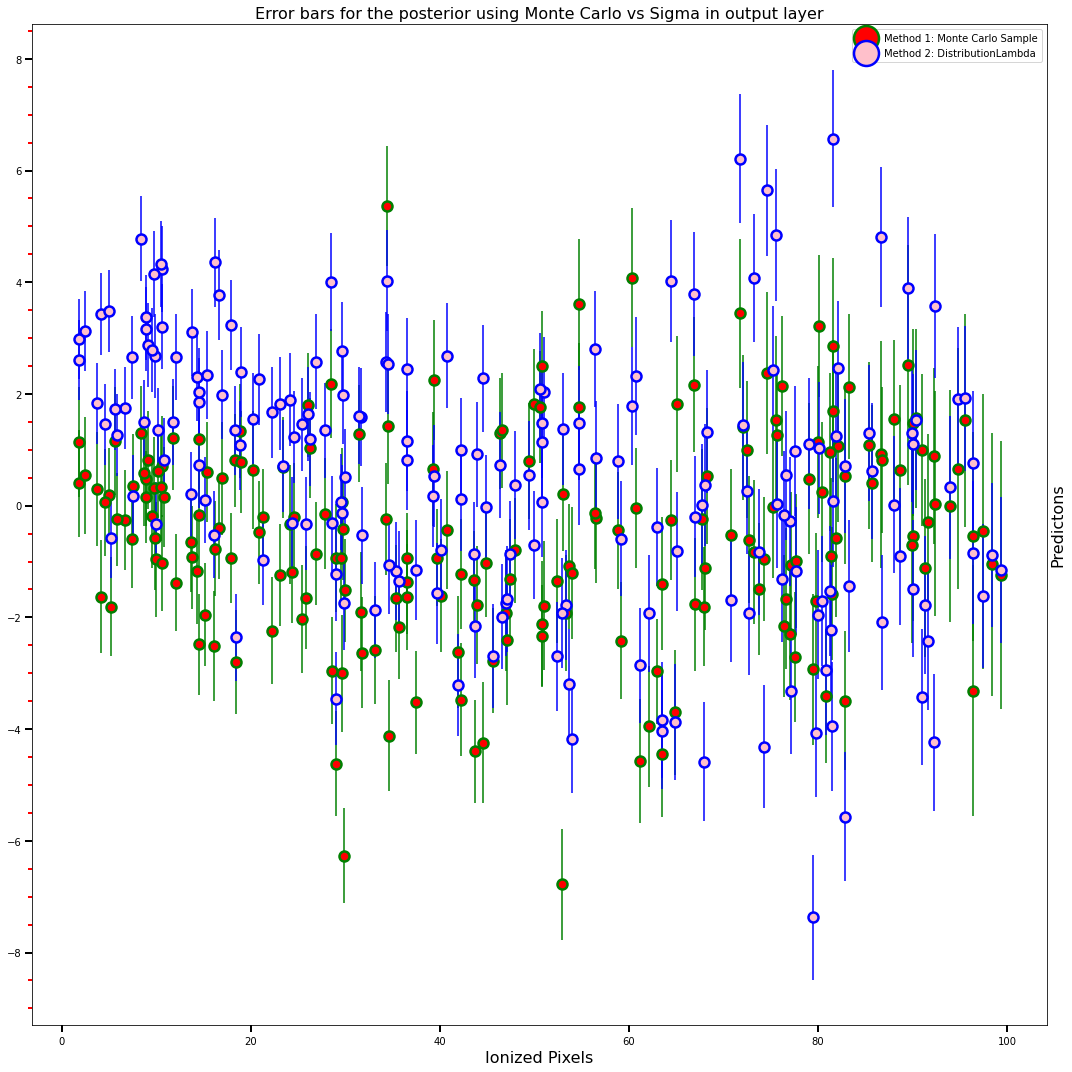

In [141]:
script.plot_error2(yhat=model(X_test), predictions= pred, y_test= y_test)

The variance of the predictions using the DistributionLambda method is approximately uniform

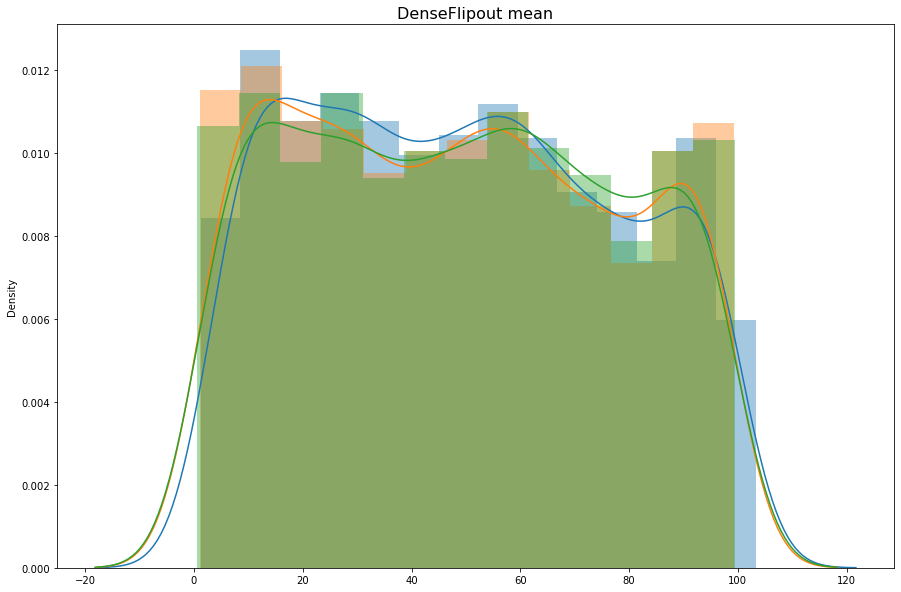

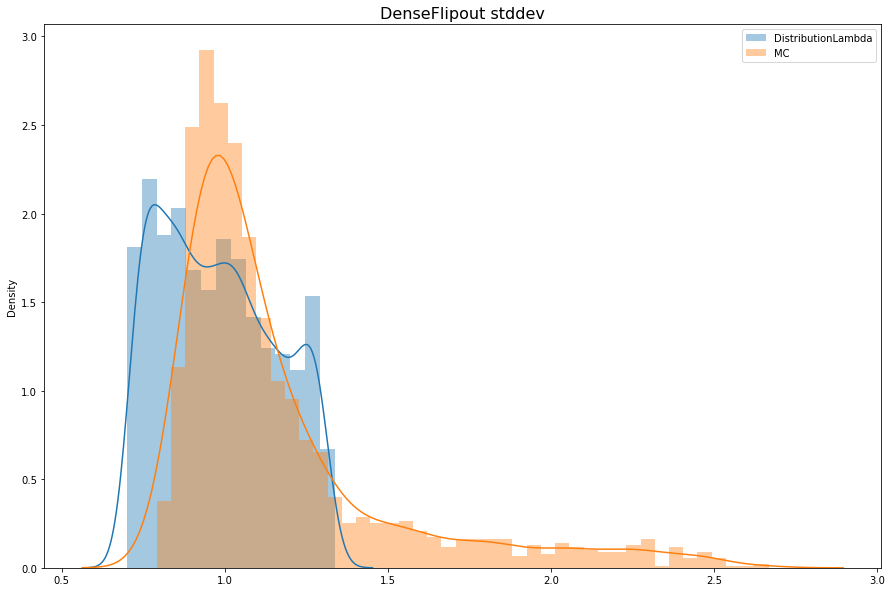

In [142]:
script.plot_distribution_mean_std(yhat=model(X_test), predictions= pred, y_test= y_test)

# Model 5

## Train Model Using Deterministic Loss Function



In [143]:
outputdir = ""
if os.path.isdir(project_name): # check to see if path exists
    os.system("rm -rvf {}".format(project_name))

def model5_dloss(hp):

    # Making a model.
    model = Sequential()

    # Added Layers.
    model.add(tfp.layers.Convolution2DFlipout(filters = 32,
                                              input_shape=(nx, ny, 1), kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu'
                                              , padding = 'valid',
                                              ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(tfp.layers.Convolution2DFlipout(filters = 28, kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu'
                                              , padding = 'valid',
                                              ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    model.add(Dropout(0.2))
    model.add(tfp.layers.DenseFlipout(100, activation="linear", kernel_divergence_fn=kl_divergence_function,))
    
    model.add(Dropout(0.2))
    model.add(tfp.layers.DenseFlipout(10, activation="linear", kernel_divergence_fn=kl_divergence_function,))

    model.add(Dropout(0.2))
    model.add(tfp.layers.DenseFlipout(1, activation="linear", kernel_divergence_fn=kl_divergence_function,))

    #for l in range(hp.Int('loss', 0, len(losses))):
    model.compile(optimizer= "adam", loss = hp.Choice('loss_type', ["mse", "mae", "mape", "Mean_Squared_over_true_Error"], ordered=False, default="mse"), metrics=["mse"])

    # Visualize Model
    print(model.summary())

    return model


In [144]:
# Random searrch through choices
tuner_models = script.random_search(model= model5_dloss,
                                    num_models= num_models,
                                    outputdir= outputdir,
                                    project_name= project_name,
                                    X_train= X_train, 
                                    y_train= y_train,
                                    X_test= X_test, 
                                    y_test= y_test,
                                    epochs= HP_EPOCH,
                                    HP_BATCH_SIZE=HP_BATCH_SIZE,
                                   )


Trial 4 Complete [00h 08m 36s]
val_loss: 9.754859924316406

Best val_loss So Far: 0.46339914202690125
Total elapsed time: 00h 33m 46s
INFO:tensorflow:Oracle triggered exit
--------------------------------------------------
Tuning Summary
--------------------------------------------------
Results summary
Results in ./toy_model_tuner_32
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
loss_type: Mean_Squared_over_true_Error
Score: 0.46339914202690125
Trial summary
Hyperparameters:
loss_type: mae
Score: 9.754859924316406
Trial summary
Hyperparameters:
loss_type: mape
Score: 28.189353942871094
Trial summary
Hyperparameters:
loss_type: mse
Score: 38.01873016357422
Search space summary
Default search space size: 1
loss_type (Choice)
{'default': 'mse', 'conditions': [], 'values': ['mse', 'mae', 'mape', 'Mean_Squared_over_true_Error'], 'ordered': False}
Model: "sequential"
_________________________________________________________________
Layer (

In [145]:
# print best performing model's loss function
tuner_models[0].loss

'Mean_Squared_over_true_Error'

In [146]:
# returns a list of model
tuner_models

In [147]:
# List of losses: the quantity that a model should seek to minimize during training.
tuner_models[0].losses

[<tf.Tensor 'conv2d_flipout/divergence_kernel:0' shape=() dtype=float32>,
 <tf.Tensor 'conv2d_flipout_1/divergence_kernel:0' shape=() dtype=float32>,
 <tf.Tensor 'dense_flipout/divergence_kernel:0' shape=() dtype=float32>,
 <tf.Tensor 'dense_flipout_1/divergence_kernel:0' shape=() dtype=float32>,
 <tf.Tensor 'dense_flipout_2/divergence_kernel:0' shape=() dtype=float32>]

### Monte Carlo 

Use Monte Carlo sampling of the models and average the predicted predictions to get the predicted values and make one-to-one plot. In the plot below I compare the models and then from there it's clear who doesn't do well at all (blue line). Obvisouly, if I trained the model for a longer time then I would expect it to improve the other predictions but this is good enough. 

In [148]:
# make list of predictions using all of the model
predictions = script.mc_pred_tuner_models(tuner_models=tuner_models, X_test=X_test)

(2000, 32, 32, 1)
(5, 2000)


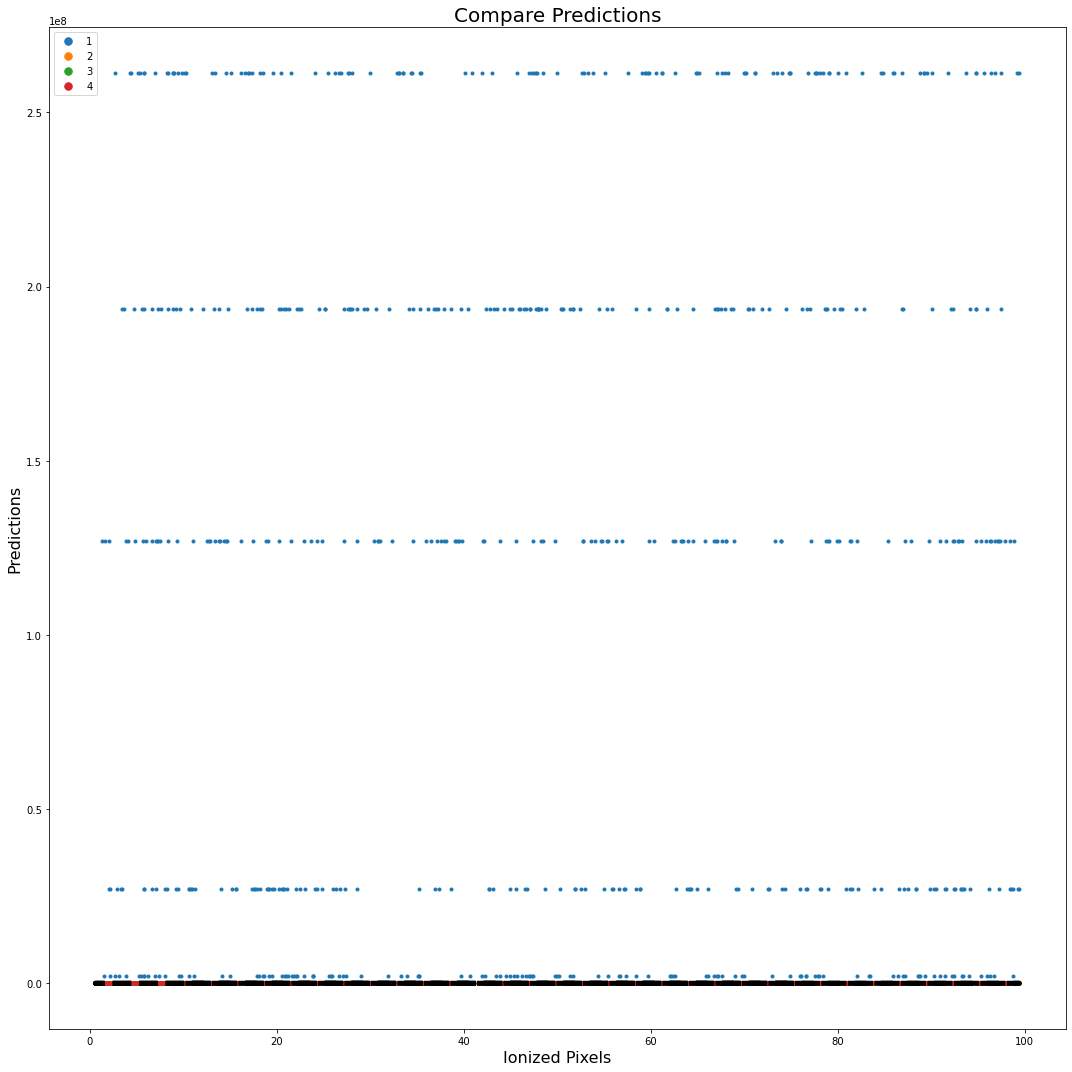

In [149]:
script.plot_one_to_one_pred(tuner_models= tuner_models, y_test= y_test, predictions=predictions)

In [150]:
predictions.shape

(5, 2000)

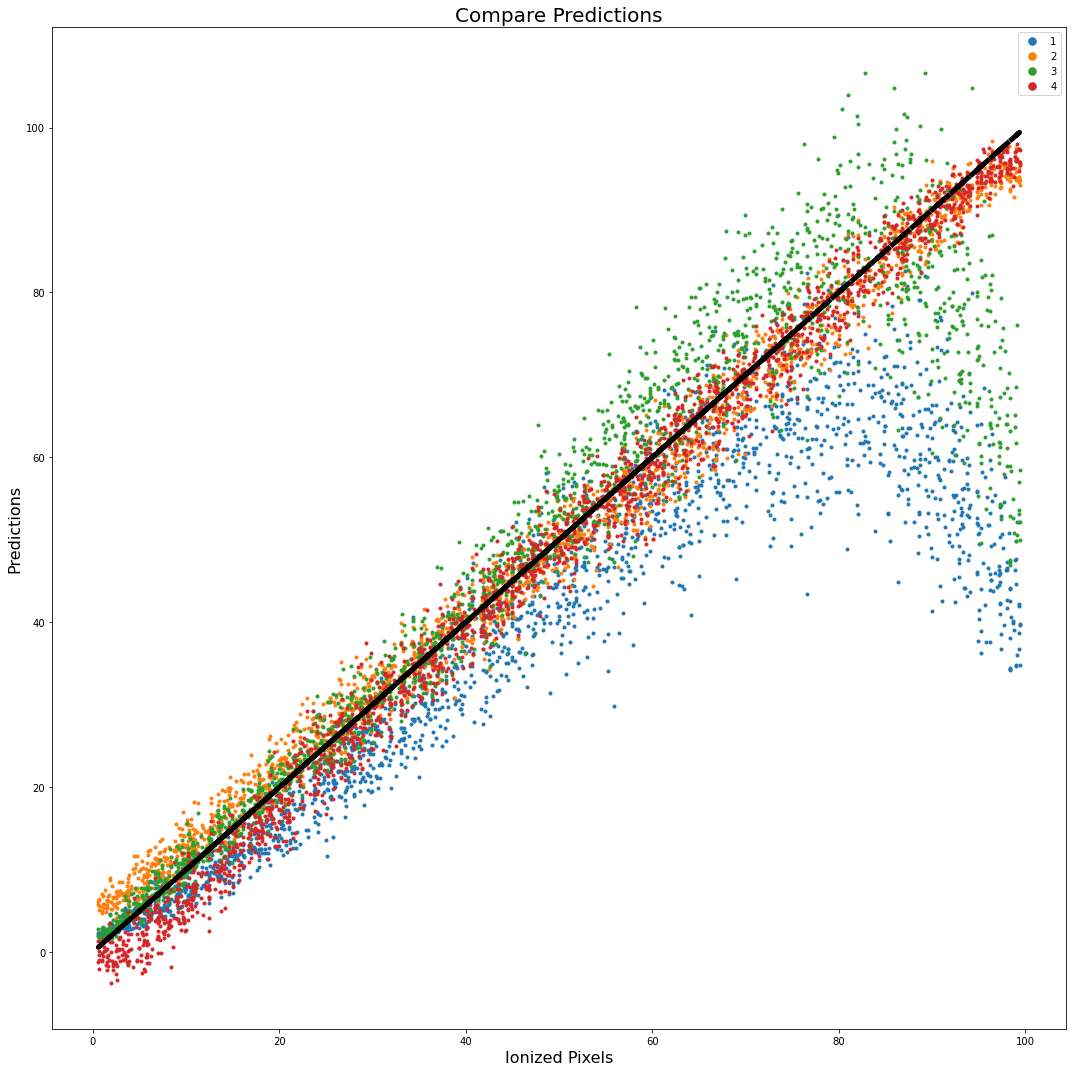

In [151]:
script.plot_one_to_one_pred(tuner_models= tuner_models, y_test= y_test, predictions=predictions[1:,:])

In [152]:
tuner_models[-2].loss

'mape'

In [153]:
# make list of predictions using the best model
pred = script.mc_pred(bestmodel=tuner_models[-2], X_test=X_test)

In the plot below I look at a subset of predicted ionized pixel values. I would have selected any range but I chose 0-2. Well, the good thing is that it looks like the model doesn't try to guess values less than 0... That would make no sense. We do see multiple peaks. More than two peaks is no longer a bimodal distribution. It's a Multimidal distribution and would also represent multiple local maximums; these are points where the data points stop increasing and start decreasing.  

https://www.statisticshowto.com/what-is-a-bimodal-distribution/

No handles with labels found to put in legend.


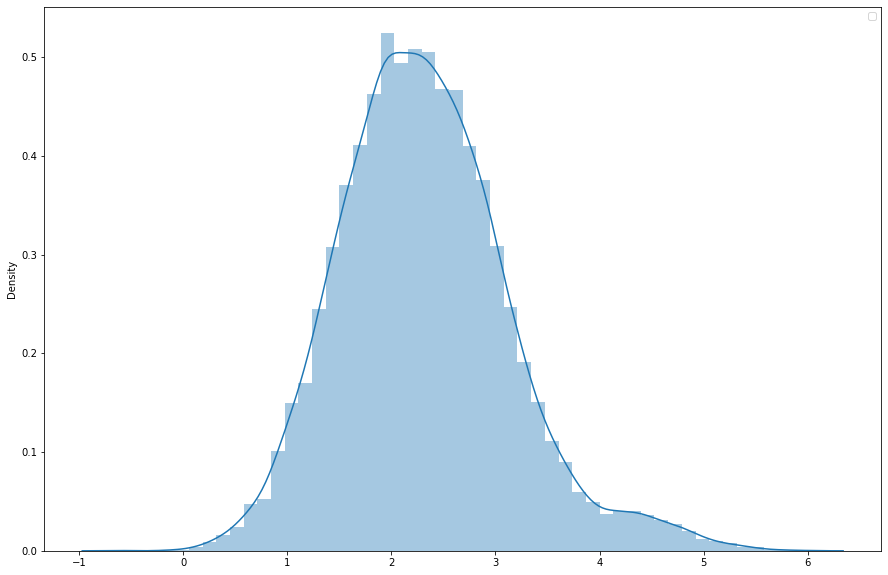

In [154]:
script.plot_pred_distribution_range(predictions=pred, y_test=y_test, upper_lim=2, lower_lim=0)

Ideally we would want this distribution to be centred at zero because we are looking at the distribution of the difference between the pred and the true value. There is clearly some presence of divergence the distribution. I can't see much skewed behavior but I do see the presenece of kurtosis (positive and negative).  Some of thee distributions have pretty fat tails too.

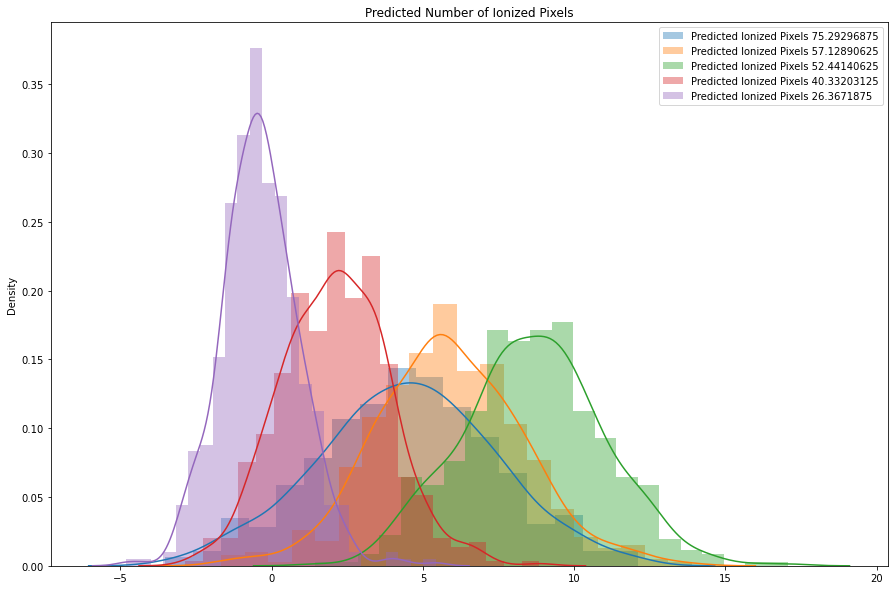

In [155]:
script.plot_pred_distribution(predictions= pred, y_test= y_test)

### Empirical Examination of Posterior Distribution

Looks like the std of the weights areen't negative... Good. There are very clear double peaks (bimodal distirbution?).  

Weight distribution says something interesting I think. Going from the 1st convolution layer to the second more weights are zero. So, they aren't important when looking at this data.

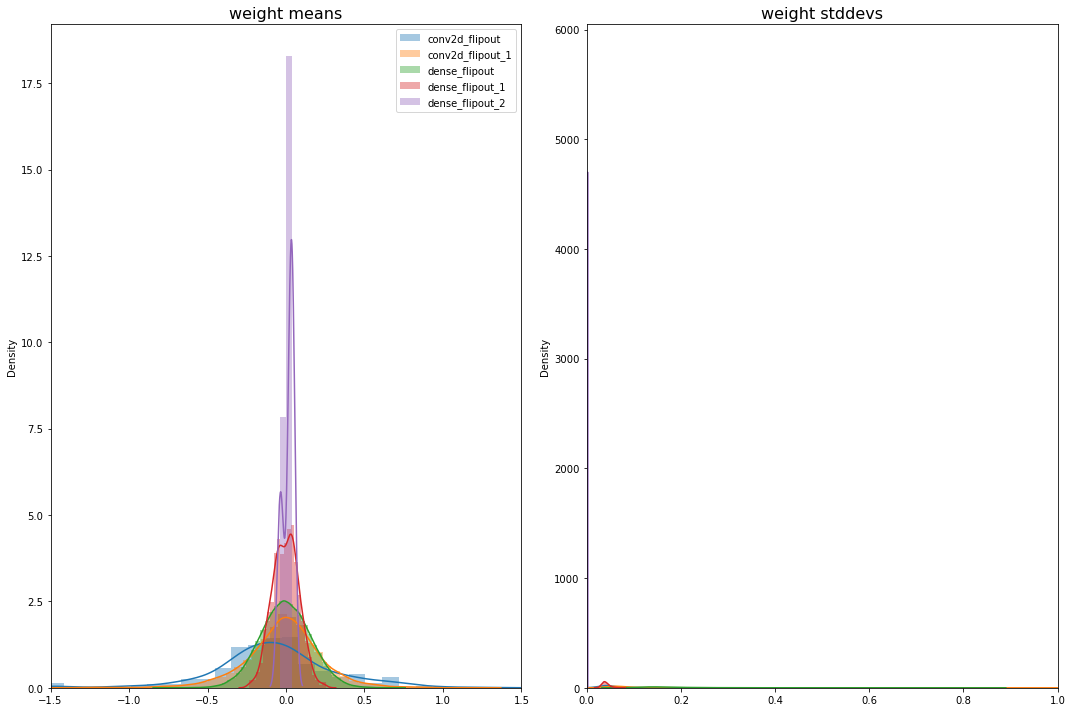

In [156]:
script.plot_qm_qs_vals(bnn_model= tuner_models[-2])

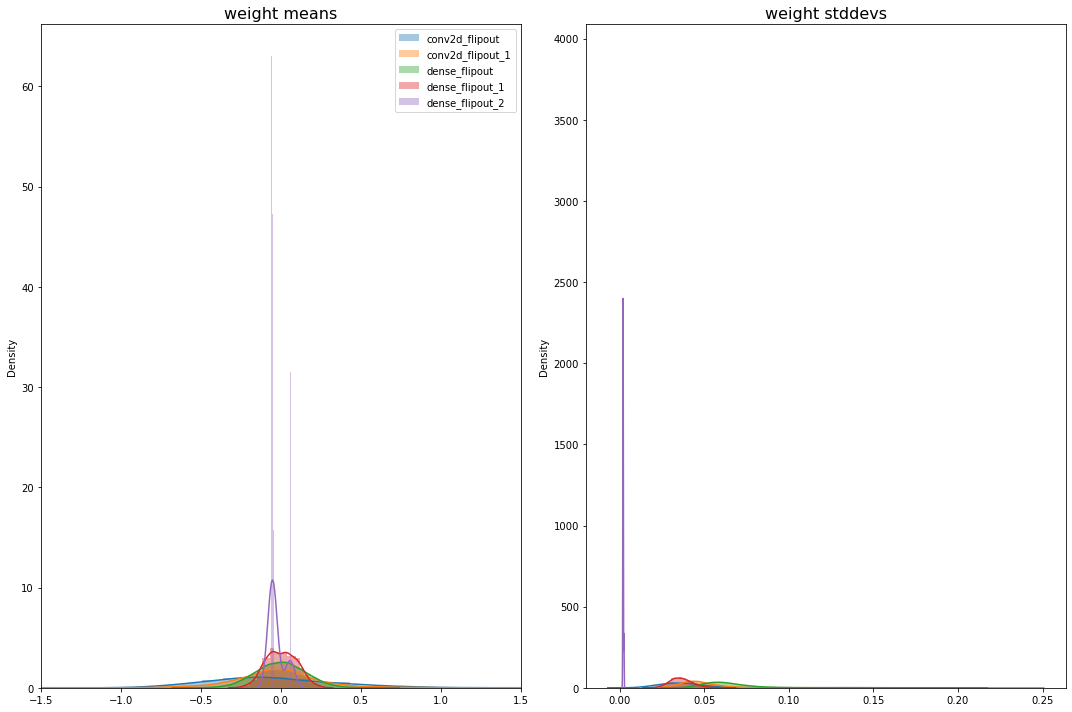

In [157]:
def plot_qm_qs_vals(bnn_model=tuner_models[-2]):
    
    names = [layer.name for layer in bnn_model.layers if "flipout" in layer.name]
    
    qm_vals = [
        layer.kernel_posterior.mean()
        for layer in bnn_model.layers
        if "flipout" in layer.name
    ]
    qs_vals = [
        layer.kernel_posterior.stddev()
        for layer in bnn_model.layers
        if "flipout" in layer.name
    ]


    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(1, 2, 1)
    for n, qm in zip(names, qm_vals):
        sns.distplot(tf.reshape(qm, shape=[-1]), ax=ax, label=n)
    ax.set_title("weight means",size = 16 )
    ax.set_xlim([-1.5, 1.5])
    ax.legend()
    ax = fig.add_subplot(1, 2, 2)
    for n, qs in zip(names, qs_vals):
        sns.distplot(tf.reshape(qs, shape=[-1]), ax=ax)
    ax.set_title("weight stddevs", size = 16)
    #ax.set_xlim([0, 1.0])
    fig.tight_layout()
    plt.show()
    
plot_qm_qs_vals(bnn_model=tuner_models[-1])

## Train Model Using Probabilistic Loss Function

This is the same architecture as above but instead train the model using a non-deterministic loss function and train it 6 times as long. This does extremely well as you can see in the one-to-one. I shuold try this with "elbo" loss function too. You can also compare the performance of the twoo models because they have a common metric "mse". In the model above "Score: 1.8561763763427734". In this model the "Score: 1.650"

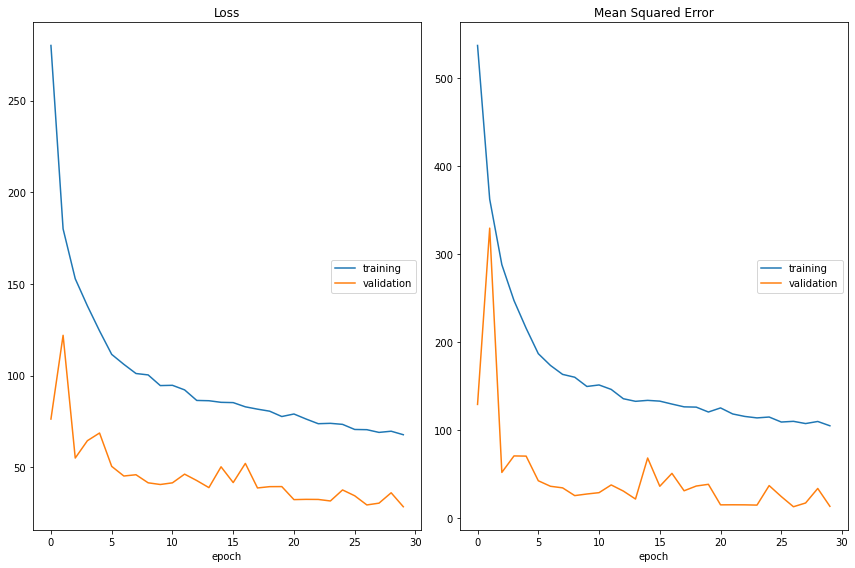

Loss
	training         	 (min:   67.764, max:  280.055, cur:   67.764)
	validation       	 (min:   28.487, max:  121.983, cur:   28.487)
Mean Squared Error
	training         	 (min:  105.083, max:  536.989, cur:  105.083)
	validation       	 (min:   13.143, max:  329.527, cur:   13.605)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout_2 (Conv2DFlip (None, 30, 30, 32)        608       
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_flipout_3 (Conv2DFlip (None, 13, 13, 28)        16156     
_________________________________________________________________
batch_normalization_3 (Batch (

In [158]:
def model5_ploss():

    # Making a model.
    model = Sequential()

    # Added Layers.
    model.add(tfp.layers.Convolution2DFlipout(filters = 32,
                                              input_shape=(nx, ny, 1), kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu'
                                              , padding = 'valid',
                                              ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(tfp.layers.Convolution2DFlipout(filters = 28, kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu'
                                              , padding = 'valid',
                                              ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    model.add(Dropout(0.2))
    model.add(tfp.layers.DenseFlipout(100, activation="linear", kernel_divergence_fn=kl_divergence_function,))
    
    model.add(Dropout(0.2))
    model.add(tfp.layers.DenseFlipout(10, activation="linear", kernel_divergence_fn=kl_divergence_function,))

    model.add(Dropout(0.2))
    model.add(tfp.layers.DenseFlipout(1, activation="linear", kernel_divergence_fn=kl_divergence_function,))
    model.add(tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(loc=t[..., :1],
                             #scale = 1)))
                             scale=1e-3 + tf.math.softplus(0.01 * t[..., :1]))))

    model.compile(optimizer= "adam", loss = "neg_log_likelihood", metrics=["mse"])

    plotlosses = PlotLossesKeras()

    model.fit(X_train, y_train, validation_data=(X_test, y_test),
              epochs=HP_EPOCH, batch_size=HP_BATCH_SIZE,
              callbacks=[plotlosses],
              verbose=1)

    # Visualize Model
    print(model.summary())

    loss = model.evaluate(X_test, y_test)
    return model

                                                                                                                                                                                      
model = model5_ploss()



### Monte Carlo 

In [159]:
# make predictions  
pred_distLambda = script.mc_pred(bestmodel=model, X_test=X_test)

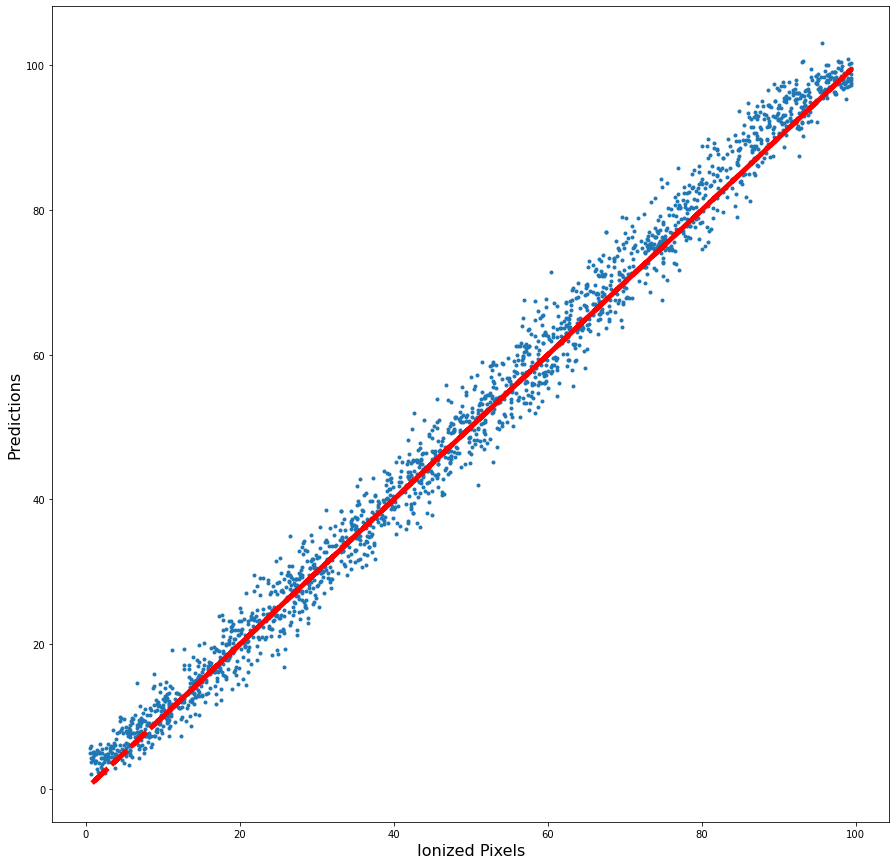

In [160]:
# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("")
plt.xlabel("Ionized Pixels", size = 16)
plt.ylabel("Predictions", size = 16)
plt.plot(y_test, np.mean(np.array(pred_distLambda), axis=0), '.')
plt.plot(y_test,y_test, "r--", linewidth=5)

These distibutions have fat tails too but they are closer to being centered at zero.

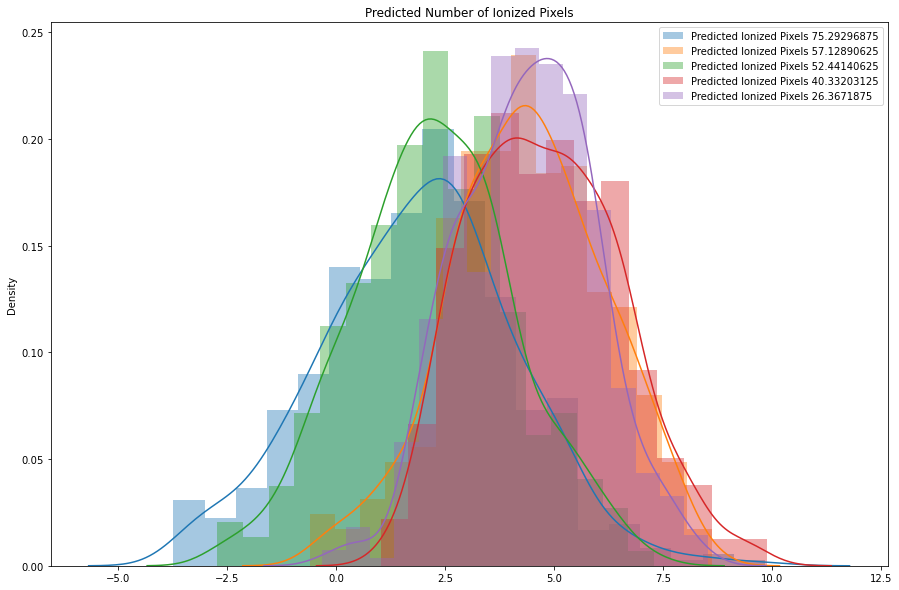

In [161]:
script.plot_pred_distribution(predictions= pred_distLambda, y_test= y_test)

### Plot the distribution of the predictions within a certain range.

No handles with labels found to put in legend.


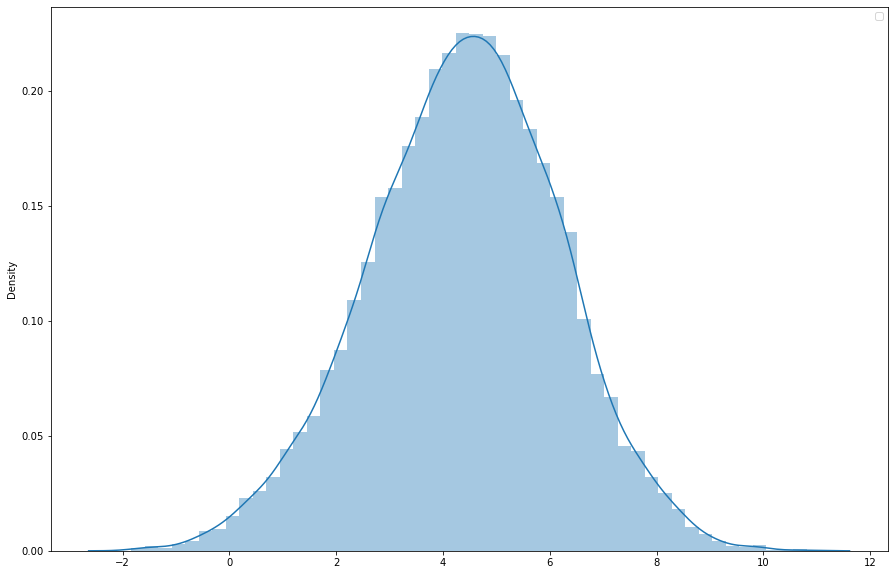

In [162]:
script.plot_pred_distribution_range(predictions=pred_distLambda, y_test=y_test, upper_lim=2, lower_lim=0)

No handles with labels found to put in legend.


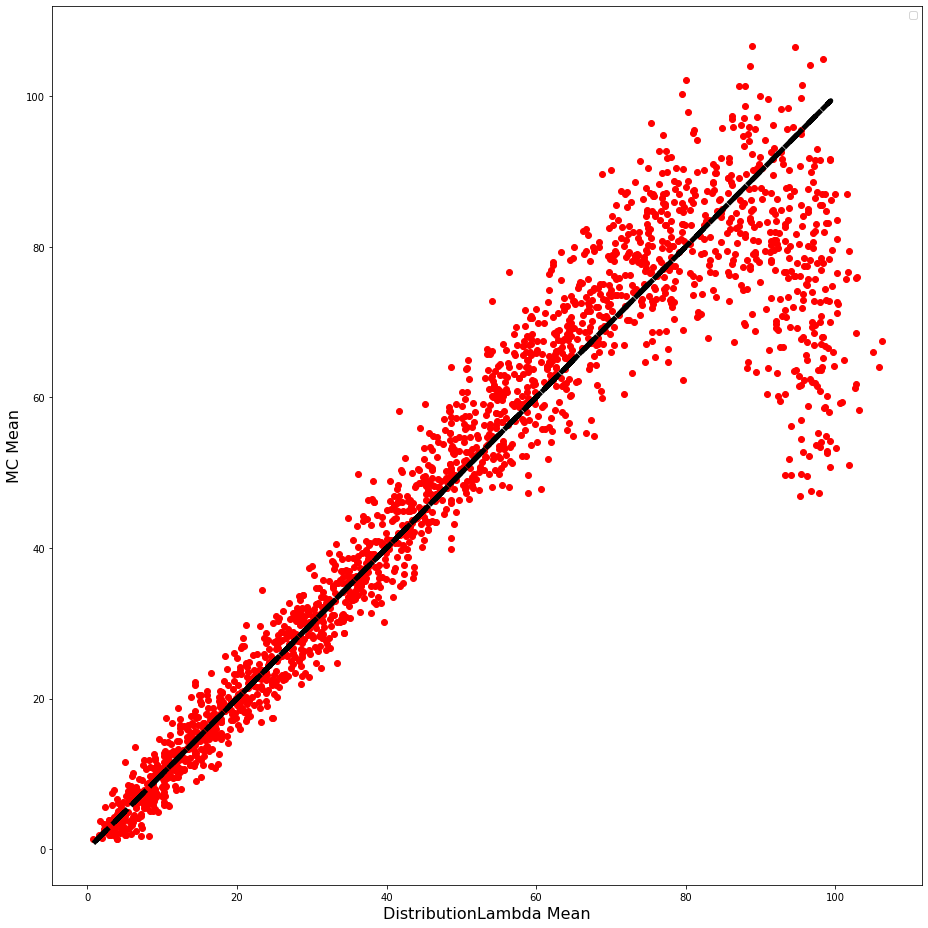

In [163]:
script.plot_compare_pred_values(yhat=model(X_test), predictions= pred, y_test= y_test)

... Very unclear what this shape means... I keep seeing it... idk...

No handles with labels found to put in legend.


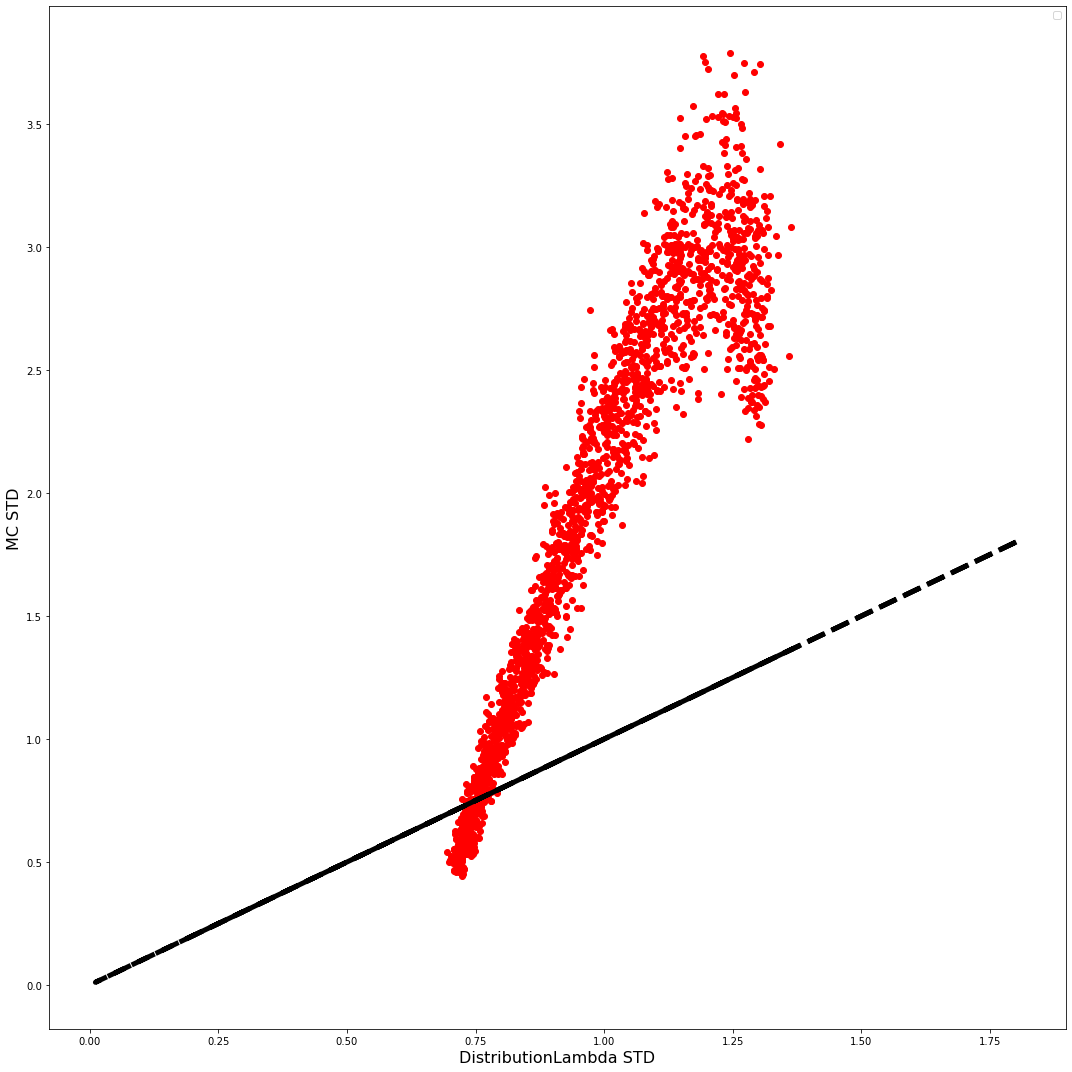

In [164]:
script.plot_compare_STDs(yhat=model(X_test), predictions= pred, y_test= y_test)

### Empirical Examination of Posterior Distribution

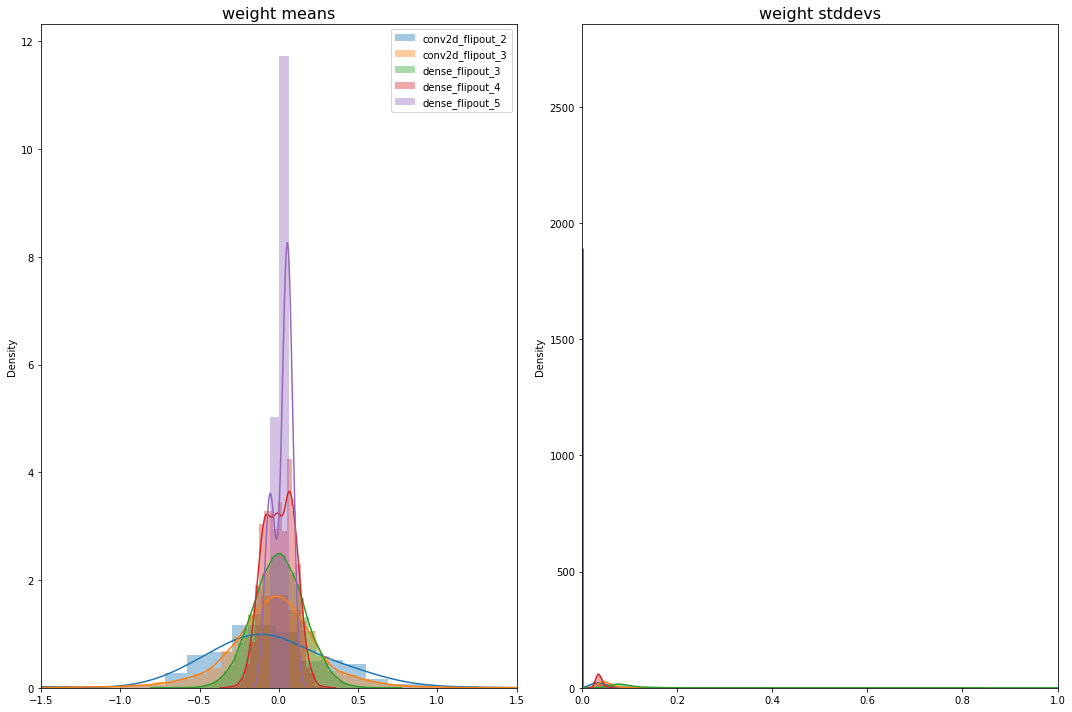

In [165]:
script.plot_qm_qs_vals(bnn_model= model)

## Learn STD and Mean

### Error Bars

METHOD 1:  Empirical error bars for the posterior using Monte Carlo  

METHOD 2: Sigma in output layer  

In [166]:
yhat = model(X_test) # model.predict(X_test)

MC predictions do really well here but what happens when we sample from the Lambda_distribution function?

Compare two prediction methods. MC sampling and Disttribution lambda are about the same so this is really good. MC can take a very long time so I guess this means in this case I don't need to use the MC sampling of the model.

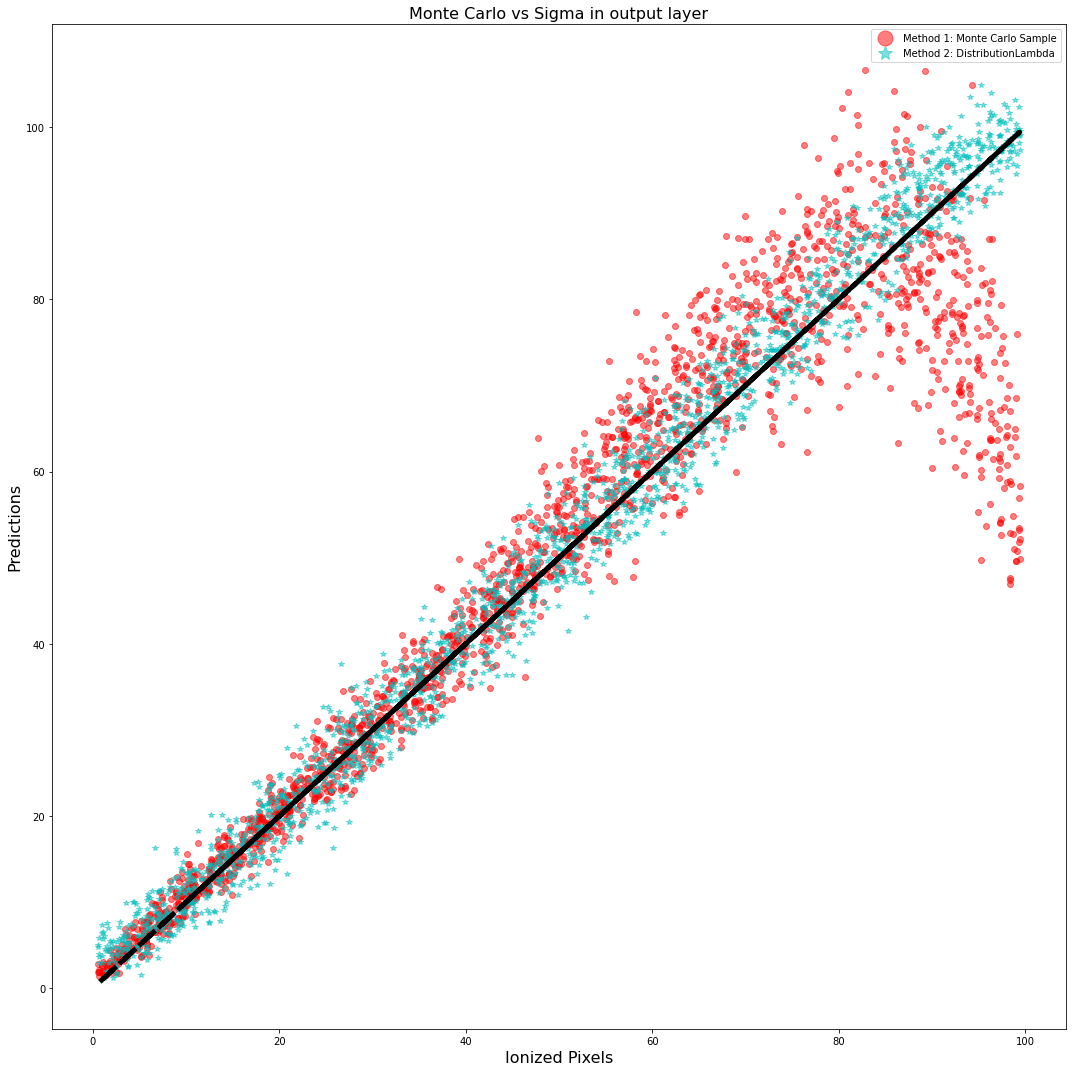

In [167]:
script.plot_one_to_one_pred_MC_DistributionLambda(yhat=model(X_test), predictions= pred, y_test= y_test)

We see some divergence as the number of ionized pixels increases. This is probably because I'm plotting the absolute error instead of the relative error. That could fix things maybe?

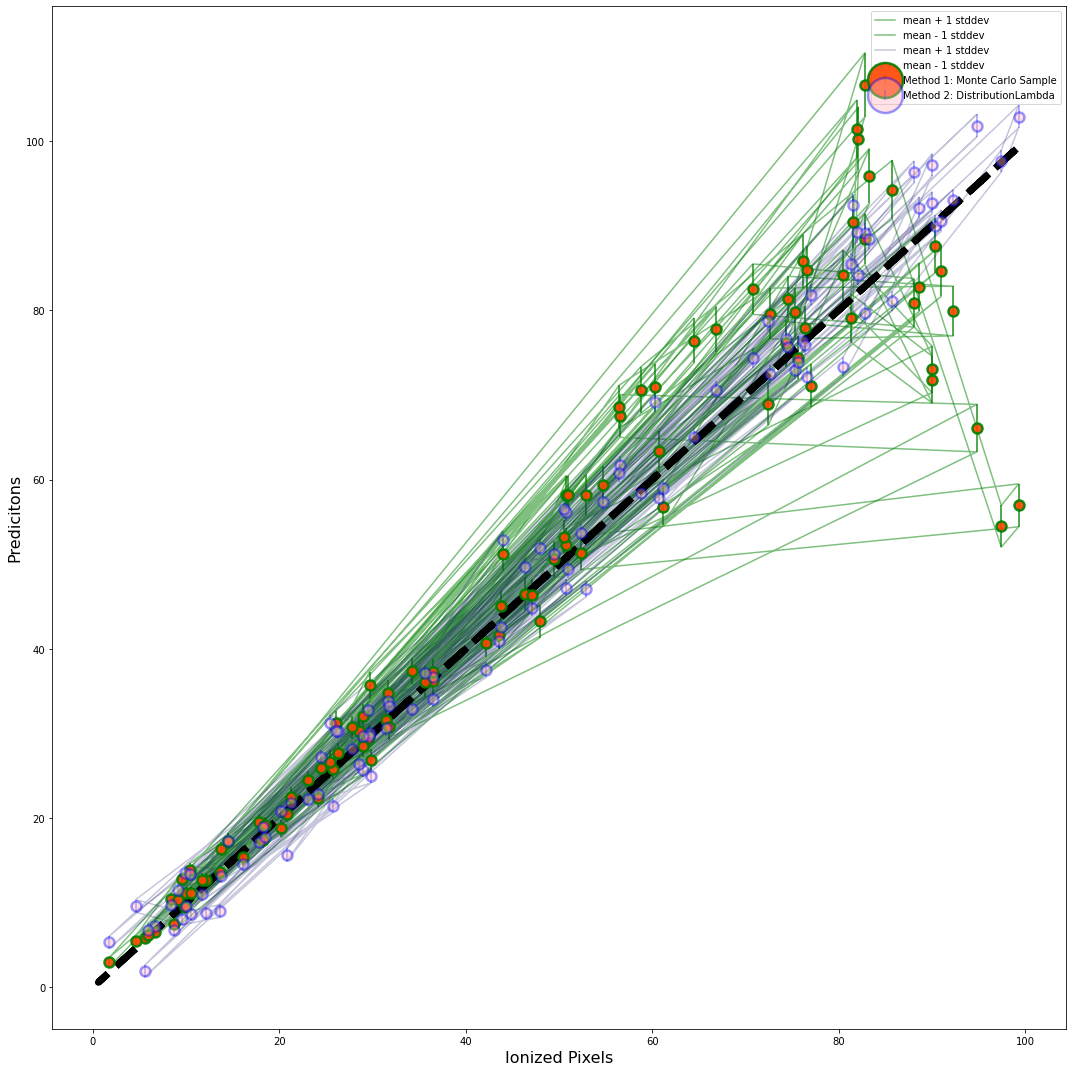

In [168]:
script.plot_error1(yhat=model(X_test), predictions= pred, y_test= y_test)

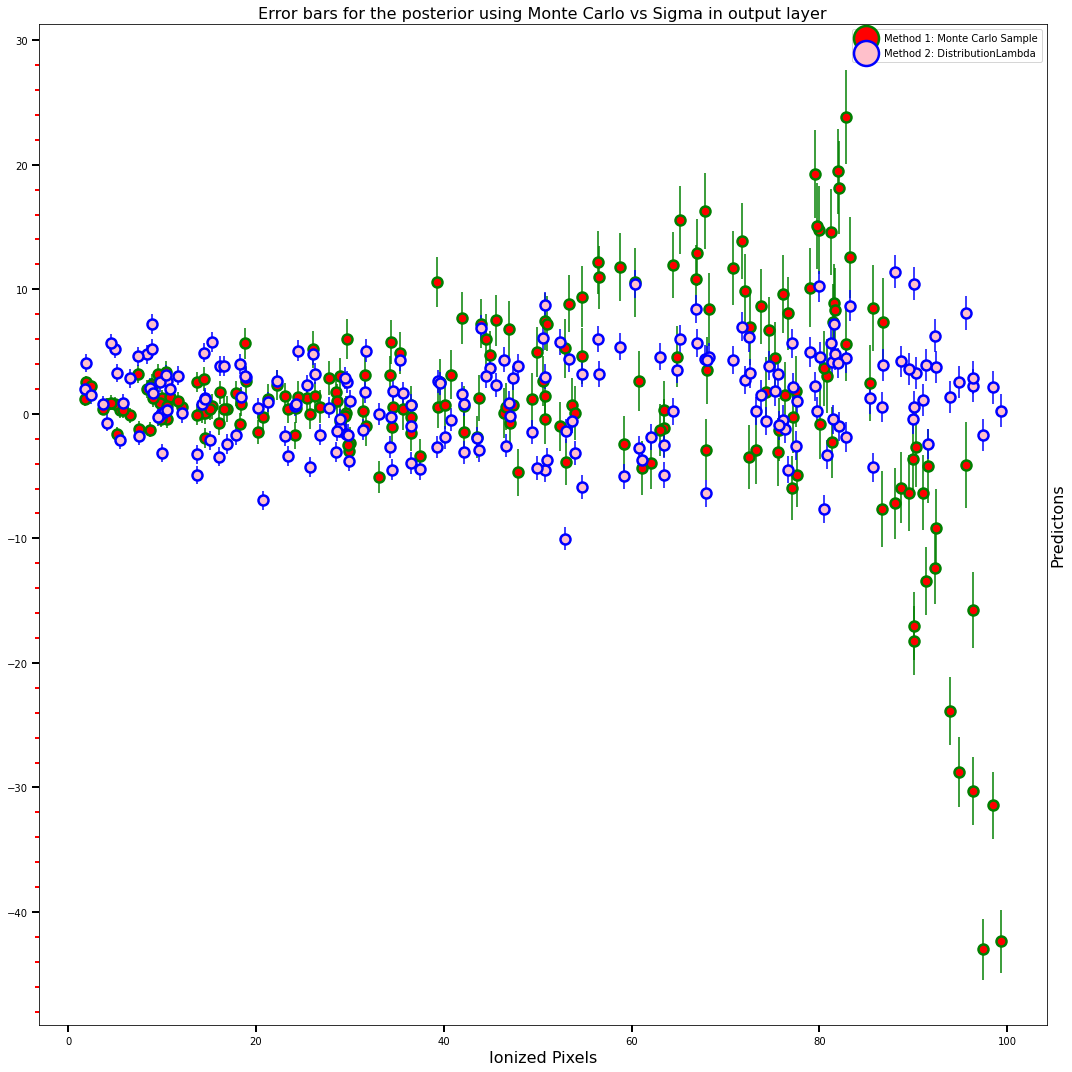

In [169]:
script.plot_error2(yhat=model(X_test), predictions= pred, y_test= y_test)

The variance of the predictions using the DistributionLambda method is approximately uniform

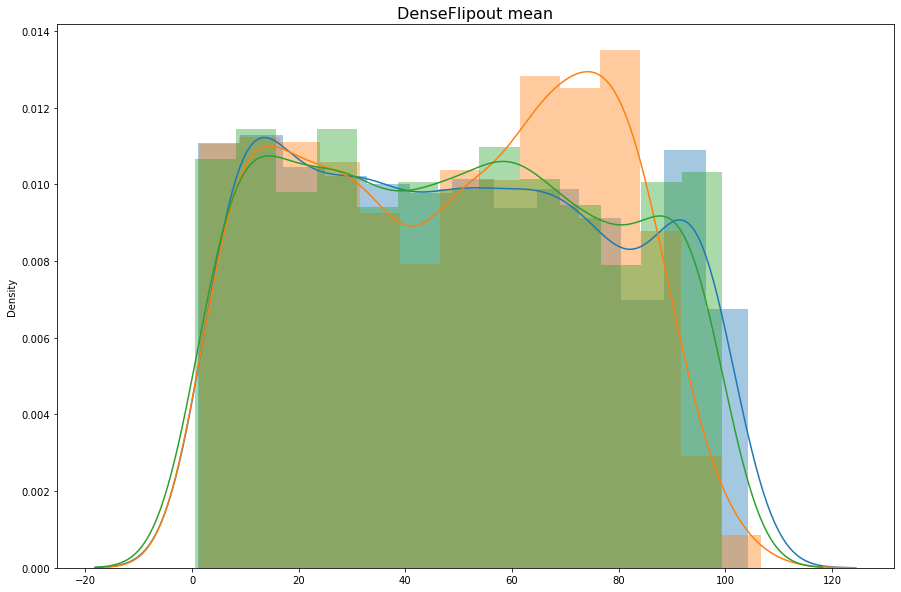

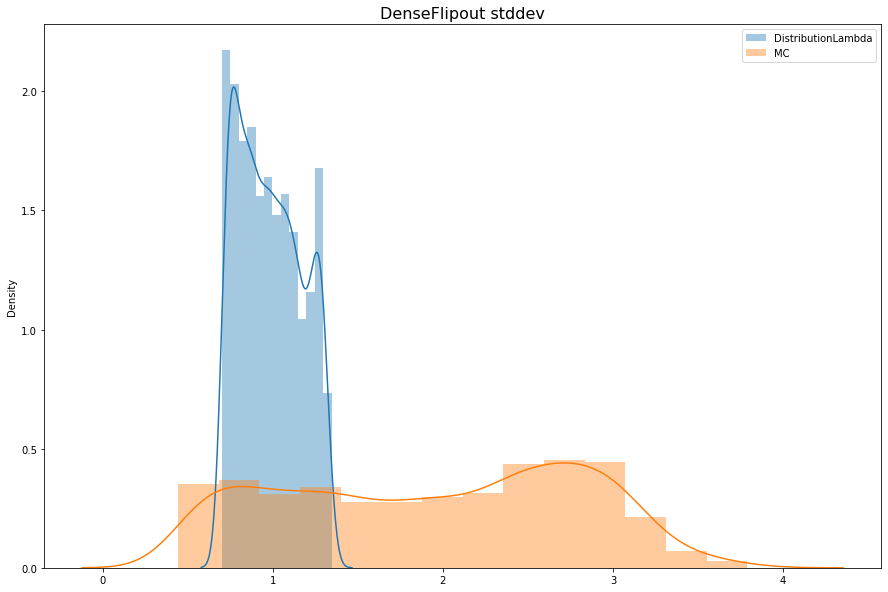

In [170]:
script.plot_distribution_mean_std(yhat=model(X_test), predictions= pred, y_test= y_test)